# Xebra MC LCE
**Status:** June 2019

In [1]:
# True if using preprocessed data from pickle files only
# False if using data from simulation output ROOT files
b_preprocessed = False

In [2]:
## Check Python version:
!python -V
## Check ROOT version:
!which root

Python 3.7.3


In [3]:
## Largest positive integer supported by the platform's Py_ssize_t type:
import sys
sys.maxsize

9223372036854775807

## Imports and function definitions

In [4]:
## Imports:

import glob

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline

In [5]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

### Properties PMTs

<img src="../../Technical_Drawings_and_Data_Sheets/PMTs/pmts_verbessert.png" alt="pmts_verbessert.png" style="width: 700px;"/>

In [6]:
PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

PMT_ID  PMT_position_x  PMT_position_y  PMT_position_R  PMT_position_Phi
1       1           -14.0           -28.0       31.304952         -2.034444
2       2           -28.0             0.0       28.000000          3.141593
3       3           -14.0            28.0       31.304952          2.034444
4       4            14.0            28.0       31.304952          1.107149
5       5            28.0             0.0       28.000000          0.000000
6       6            14.0           -28.0       31.304952         -1.107149
7       7             0.0             0.0        0.000000          0.000000

In [7]:
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

### Imports and data porcessing

In [8]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Analysis/Calibration_simulations_pointsource/data
#! ls ../../Analysis/LCE/data/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/LCE
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters

optPhot_S2_1.0e+07_pmtGap0_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap10c_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap13-23_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap15c_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap20c_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap23c_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap3_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap4.5_PTFEUnpolished005_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap4.5_SS_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S2_1.0e+07_pmtGap5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.3_LXeAbs1000_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.3_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.3_LXeAbs10_Tmesh0.89770509.root
optPho

In [9]:
## Selection of file to be analyzed:
#filename_list = ['/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root']
filename_list = glob.glob("/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
 
    
if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]

elif filename[6:25] == 'Simulation_Data/Mod':
    filenameprefix = filename[:-5][44:]

elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]

elif filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][45:]

elif filename[:63] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][63:]

elif filename[:70] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][70:]

elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][44:]

elif filename[:62] == '/media/alex/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][62:]

elif filename[:69] == '/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][69:]

else:
    filenameprefix = 'filenameprefix'
    
print(filenameprefix)

optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04


In [10]:
'''
if b_preprocessed == False:
    ## Inspect branches:
    f = uproot.open(filename)['events/events']
    eventid = f['eventid'].array()
    f.keys()
    print(f.keys())
''';

In [11]:
'''## Determine number of events in all files:
MC_files = [filename]
nevents = [_chunk[1] for _chunk in uproot.iterate(MC_files, "events/events", ["?"], reportentries=True, entrysteps=10000000, outputtype=collections.namedtuple)][-1]
print(nevents)''';

In [12]:
if b_preprocessed == False:
    ## Import as panda dataframes

    import pandas as pd

    branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        #_chunk =_chunk[ _chunk['ed'].apply(lambda x: len(x)==1) ] # Remove events with more than one scatter
        #_chunk =_chunk.applymap(lambda x: x[0]) # Convert lists in cells by taking only the 0th element
        #_chunk.type_pri =_chunk.type_pri.apply(lambda x: x.decode("utf-8")) # Decode bytestrings for primary type
        _chunk_collect = _chunk_collect.append(_chunk)

    #print(_chunk.tail(10))
    #_chunk_collect.tail(10)
    #_chunk_collect.head(10)
    #_chunk_collect
    
if b_preprocessed == True:
    # import all relevant pandas dataframes already saved as .pkl files
    
    LCE_z_hist = pd.read_pickle('output/'+filenameprefix+'_LCE_z_hist.pkl')
    LCE_r2_hist = pd.read_pickle('output/'+filenameprefix+'_LCE_r2_hist.pkl')
    LCE_xy_hist = pd.read_pickle('output/'+filenameprefix+'_LCE_xy_hist.pkl')
    LCE_r2z_hist = pd.read_pickle('output/'+filenameprefix+'_LCE_r2z_hist.pkl')
    
    '''    
    tmp = pd.read_pickle('output/'+filenameprefix+'_LCE_z_hist.pkl')
    exec(filenameprefix+'_LCE_z_hist'+' = tmp')

    tmp = pd.read_pickle('output/'+filenameprefix+'_LCE_r2_hist.pkl')
    exec(filenameprefix+'_LCE_r2_hist'+' = tmp')

    tmp = pd.read_pickle('output/'+filenameprefix+'_LCE_xy_hist.pkl')
    exec(filenameprefix+'_LCE_xy_hist'+' = tmp')

    tmp = pd.read_pickle('output/'+filenameprefix+'_LCE_r2z_hist.pkl')
    exec(filenameprefix+'_LCE_r2z_hist'+' = tmp')

    del(tmp)
    '''

In [13]:
'''
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')
''';

In [14]:
'''## Iterate TChain like with all possible branches in a single collection:

MC_files = [filename]
N = nevents

for _chunk in uproot.iterate(MC_files, "events/events", ["*"], entrysteps=N, outputtype=collections.namedtuple):
    break''';

In [15]:
if b_preprocessed == False:
    ## Process data:
    _chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)
    _chunk_collect['rp_pri'] = pd.Series(np.sqrt(_chunk_collect.xp_pri * _chunk_collect.xp_pri + _chunk_collect.yp_pri * _chunk_collect.yp_pri), index=_chunk_collect.index)
    _chunk_collect['rp_pri2'] = pd.Series(_chunk_collect.rp_pri * _chunk_collect.rp_pri, index=_chunk_collect.index)

In [16]:
if b_preprocessed == False:
    print(_chunk_collect.head(10))
    print(_chunk_collect.describe())

      xp_pri     yp_pri    zp_pri  nbpmthits  ntpmthits  \
0   6.308426 -27.029482  3.953108     1399.0     1236.0   
1  12.007748  16.602249  4.091348     1394.0     1333.0   
2   6.830651   6.422556  2.933570     1502.0     1371.0   
3   9.652061  -4.358411  2.918644     1447.0     1378.0   
4  -3.395517  17.888252  3.757587     1377.0     1326.0   
5  -4.836117 -33.675201  2.775981     1509.0     1170.0   
6  14.368170  18.664253  3.939679     1390.0     1343.0   
7  34.632839  -1.535040  2.803430     1469.0     1315.0   
8  -6.649735  -8.304984  3.905668     1396.0     1494.0   
9 -32.264790   9.570838  3.316545     1436.0     1206.0   

                                  pmthits  napmthits     rp_pri      rp_pri2  
0   [1399, 241, 59, 29, 30, 97, 630, 150]     2635.0  27.755886   770.389221  
1  [1394, 25, 58, 113, 567, 234, 42, 294]     2727.0  20.489527   419.820709  
2  [1502, 58, 84, 125, 192, 245, 81, 586]     2873.0   9.375875    87.907021  
3  [1447, 97, 64, 59, 109, 307, 20

In [17]:
if b_preprocessed == False:
    nphotons = len(_chunk_collect.xp_pri)
    nbpmthits_sum = int(_chunk_collect.nbpmthits.sum())
    ntpmthits_sum = int(_chunk_collect.ntpmthits.sum())
    napmthits_sum = int(_chunk_collect.napmthits.sum())

    print('Total Photons:   '+str(nphotons))
    print('Bottom PMT Hits:  '+str(nbpmthits_sum))
    print('Top PMT Hits:      '+str(ntpmthits_sum))
    print('Total PMT Hits:   '+str(napmthits_sum))
    print('Total LCE:        '+str(round(100*napmthits_sum/nphotons,2))+' %')
    
elif b_preprocessed == True:
    nphotons = LCE_z_hist['n_total'].loc['all'].sum()
    nbpmthits_sum = LCE_z_hist['n_hits'].loc['bottom'].sum()
    ntpmthits_sum = LCE_z_hist['n_hits'].loc['top'].sum()
    napmthits_sum = LCE_z_hist['n_hits'].loc['all'].sum()

    print('Total Photons:   '+str(nphotons))
    print('Bottom PMT Hits:  '+str(nbpmthits_sum))
    print('Top PMT Hits:      '+str(ntpmthits_sum))
    print('Total PMT Hits:   '+str(napmthits_sum))
    print('Total LCE:        '+str(round(100*napmthits_sum/nphotons,2))+' %')

Total Photons:   1000000
Bottom PMT Hits:  1389967757
Top PMT Hits:      1299208934
Total PMT Hits:   2689176691
Total LCE:        268917.67 %


## Analysis

In [18]:
if nphotons > 5000000:
    numberbins = 70
else:
    numberbins = 35
print(numberbins)

35


### LCE and LY derivations

#### Light Collection Efficiency
The absolute LCE, as defined in this scope, can be obtained from the MC in the following way (where (x,y,z) is the corresponding bin) as the ratio of hits of the photocathode and the total number of initial photons (generated in that specific bin):   

$\text{LCE(x,y,z)} = \frac{N_{hits}(x,y,z)}{N_{generated}(x,y,z)}$  

$N_{detected}(x,y,z)$: The number of photons generated at (x,y,z) and hitting a PMT photocathode (are registered by the PMTHitsCollection).  
$N_{generated}(x,y,z)$: The number of photons generated at (x,y,z).

#### Relative LightCollectionEfficiency
The rLCE is defined as the LCE relative to its mean value and can be obtained for MC and real data:

$\text{rLCE}_{MC}(x,y,z) = \frac{\text{LCE}(x,y,z)}{\text{LCE}_{mean}}$  
$\text{rLCE}_{data}(x,y,z) = \frac{\text{ly}(x,y,z)}{\text{ly}_{mean}}$ 

#### Photon Detection Efficiency
The photon detection efficiency can be obtained from the LCE by taking the PMT specific properties such as Quantum Efficiency and Collection Efficiency into account:

$\text{DE(x,y,z)} = LCE(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}$

$\text{QE}$: Quantum Efficiency which has to be applied per-PMT.  
$\text{CE}$: Collection Efficiency of the PMTs (from the photocathode to the first dynode).  
  
* **What is the exact calculation in the source code?**  
  
  The simulations are performed with 1 photon per Geant4 event, therefore we have a maximum of one PMT triggered. Using the hits recorded separeately for the individual PMTs in pmthits allows us to use the corresponding QE and check if the PMT is excluded from analysis. A PMT hit is recorded each time when a photon is registered in the PMT photocathode (100% CE).  
  
  $\text{DE(x,y,z)} = \frac{\sum\limits_{\text{events inside TPC}}^e \text{PMThits}_e \cdot \text{QE}( \text{PMTID}_e) \cdot \text{CE}( \text{PMTID}_e) \cdot \text{QE_increase}}{\sum\limits_{\text{events inside TPC}}^e \text{photons}_{\text{generated}}(x,y,z)}$ 

#### Light yield
The ly of the MC simulation can be assumed as:

$\text{ly(x,y,z)} = \frac{1}{W} \cdot \text{DE(x,y,z)}$ = $\frac{1}{W} \cdot LCE(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}$

$W$: Average energy that is required to produce one scintillation photon (photon yield). 

#### Values used:

#### Quantum efficiency
Quantum efficiencies at 175 nm according to data sheets:
- R11410-21: Min. 28%, Typ. 32.5% -> take QE of 32.5%
- R8520-406: Min.   -, Typ. 30  % -> take QE of 30  %

#### Collection efficiency
Collection efficiencies according to Marc:
- R11410-21: 95%
- R8520-406: 70%

#### Average photon yield 
- values from Lutz to compare to: 
  - from NEST (analysis Lutz): 1/W = 50 ph/keV, at 32 keV, at 150 V/cm; 
  - from thesis Lutz: W = (21.61 +/- 0.21) eV
- values simulated by Daniel with NEST:
  - for 40 keV, 571 V/cm, ER: 1/W = 37.725 ph/keV (first estimate)
  - for 32.1517 keV, 500 V/cm, ER: 1/W = 40.52 ph/keV
  - for 32.1517 keV, 0.0001 V/cm, ER: 1/W = 68.29 ph/keV
  - Annotation: we actually need the recoil spectrum in the NEST simulations, here we input the total energy (however consistent with Lutz)?

In [19]:
QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


In [20]:
'''
_chunk_collect['LCEwBottom'] = pd.Series(_chunk_collect.nbpmthits/nphotons, index=_chunk_collect.index)
_chunk_collect['LCEwTop'] = pd.Series(_chunk_collect.ntpmthits/nphotons, index=_chunk_collect.index)
_chunk_collect['LCEwAll'] = pd.Series(_chunk_collect.napmthits/nphotons, index=_chunk_collect.index)
''';

In [21]:
'''
## works easily since there's only one bottom PMT:
_chunk_collect['DEwBottom'] = pd.Series(_chunk_collect.LCEwBottom*QE_Bottom*CE_Bottom, index=_chunk_collect.index)

## simplified for same QE and CE of top PMTs:
_chunk_collect['DEwTop'] = pd.Series(_chunk_collect.LCEwTop*QE_Top*CE_Top, index=_chunk_collect.index)
## for different QEs / CEs of top PMTs, however quite cumbersome:
# _chunk_collect['DEwTop'] = pd.Series(np.array(sum_tuple_subentries(_chunk_collect.pmthits*np.array([0,QE_PMT1*CE_PMT1/nphotons,QE_PMT2*CE_PMT2/nphotons,QE_PMT3*CE_PMT3/nphotons,QE_PMT4*CE_PMT4/nphotons,QE_PMT5*CE_PMT5/nphotons,QE_PMT6*CE_PMT6/nphotons,QE_PMT7*CE_PMT7/nphotons]))), index=_chunk_collect.index)

## total
_chunk_collect['DEwAll'] = pd.Series(_chunk_collect.DEwTop + _chunk_collect.DEwBottom, index=_chunk_collect.index)
''';

In [22]:
'''
_chunk_collect['LYwAll'] = pd.Series(_chunk_collect.DEwAll/W, index=_chunk_collect.index)
''';

In [23]:
'''_chunk_collect''';

In [24]:
'''
# Average values:

fileLCE = open(filenameprefix+'_LCEvalues.txt','w') 

fileLCE.write(filenameprefix+'\n\n')

LCEaverageAll = _chunk_collect.LCEwAll.sum()
print('LCE_All    = '+str(round(100*LCEaverageAll,2))+' %')
fileLCE.write('LCE_All    = '+str(round(100*LCEaverageAll,2))+' %\n') 
LCEaverageTop = _chunk_collect.LCEwTop.sum()
print('LCE_Top    =  '+str(round(100*LCEaverageTop,2))+' %')
fileLCE.write('LCE_Top    =  '+str(round(100*LCEaverageTop,2))+' %\n') 
LCEaverageBottom = _chunk_collect.LCEwBottom.sum()
print('LCE_Bottom = '+str(round(100*LCEaverageBottom,2))+' %\n')
fileLCE.write('LCE_Bottom = '+str(round(100*LCEaverageBottom,2))+' %\n\n') 

DEaverageAll = _chunk_collect.DEwAll.sum()
print('DE_All     =  '+str(round(100*DEaverageAll,2))+' %')
fileLCE.write('DE_All     =  '+str(round(100*DEaverageAll,2))+' %\n') 
DEaverageTop = _chunk_collect.DEwTop.sum()
print('DE_Top     =  '+str(round(100*DEaverageTop,2))+' %')
fileLCE.write('DE_Top     =  '+str(round(100*DEaverageTop,2))+' %\n') 
DEaverageBottom = _chunk_collect.DEwBottom.sum()
print('DE_Bottom  =  '+str(round(100*DEaverageBottom,2))+' %\n')
fileLCE.write('DE_Bottom  =  '+str(round(100*DEaverageBottom,2))+' %\n\n') 

LYaverageAll = _chunk_collect.LYwAll.sum()
print('LY_All     =  '+str(round(LYaverageAll,2))+' pe/keV')
fileLCE.write('LY_All     =  '+str(round(LYaverageAll,2))+' pe/keV\n') 

LY0averageAll = LYaverageAll * W/W0
print('LY0_All    =  '+str(round(LY0averageAll,2))+' pe/keV')
fileLCE.write('LY0_All    =  '+str(round(LY0averageAll,2))+' pe/keV\n') 

fileLCE.close() 
''';

### 1D Light Collection Efficiency

#### Histogram in z

range: (2.5, 5.0) 

LCE_All    = 268915.37 %
LCE_Top    =  129922.5 %
LCE_Bottom = 138992.87 %

DE_All     =  70197.77 %
DE_Top     =  27283.72 %
DE_Bottom  =  42914.05 %

LY_All     =  28444.61 pe/keV
LY0_All    =  47935.43 pe/keV


n_total  \
all     [28446.0, 28763.0, 28747.0, 28467.0, 28748.0, ...   
top     [28446.0, 28763.0, 28747.0, 28467.0, 28748.0, ...   
bottom  [28446.0, 28763.0, 28747.0, 28467.0, 28748.0, ...   

                                                   n_hits  \
all     [77537803.0, 78361953.0, 78300160.0, 77476991....   
top     [36341091.0, 36796163.0, 36828584.0, 36495436....   
bottom  [41196712.0, 41565790.0, 41471576.0, 40981555....   

                                                   bins_z  \
all     [2.5, 2.5714285, 2.642857, 2.7142856, 2.785714...   
top     [2.5, 2.5714285, 2.642857, 2.7142856, 2.785714...   
bottom  [2.5, 2.5714285, 2.642857, 2.7142856, 2.785714...   

                                             binscenter_z  \
all     [2.5357141, 2.607143, 2.6785712, 2.75, 2.82142...   
top     [2.5357141, 2.607143, 2.6785712, 2.75, 2.82142...   
bottom  [2.5357141, 2.607143, 2.6785712, 2.75, 2.82142...   

                                                      LCE  \
all     [2725.789320115306, 2724.4012446545908, 2723.7...   
top     [1277.5466146382619, 1279.2880784340994, 1281....   
bottom  [1448.2427054770442, 1445.1131662204916, 1442....   

                                                     rLCE  \
all     [1.0136234611311998, 1.0131072855623773, 1.012...   
top     [0.9833143742556988, 0.9846547608710066, 0.986...   
bottom  [1.041954642511869, 1.0397030599939967, 1.0379...   

                                                       DE  \
all     [715.4297243900724, 714.8291865417377, 714.452...   
top     [268.28478907403496, 268.65049647116086, 269.0...   
bottom  [447.1449353160374, 446.1786900705768, 445.415...   

                                                       LY  \
all     [28989.69224551946, 28965.358049145598, 28950....   
top     [10871.07958233207, 10885.898291330537, 10901....   
bottom  [18118.612663187392, 18079.45975781506, 18048....   

                                                      LY0  
all     [48854.01248030951, 48813.00400311428, 48787.2...  
top     [18320.16197659956, 18345.134763072143, 18371....  
bottom  [30533.850503709946, 30467.86924004213, 30415....

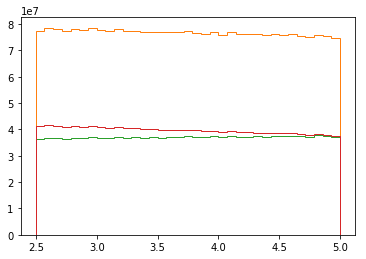

In [25]:
if b_preprocessed == False:
    numberbins_z = numberbins
    rng = (round(np.min(_chunk_collect.zp_pri),2), round(np.max(_chunk_collect.zp_pri),2))
    print('range: '+str(rng)+' \n')

    n_z_total, bins_z_total, patches_z_total = plt.hist(_chunk_collect.zp_pri, numberbins_z, weights = None, range = rng, histtype = 'step');
    n_z_hits_a, bins_z_hits_a, patches_z_hits_a = plt.hist(_chunk_collect.zp_pri, numberbins_z, weights = _chunk_collect.napmthits, range = rng, histtype = 'step');
    n_z_hits_t, bins_z_hits_t, patches_z_hits_t = plt.hist(_chunk_collect.zp_pri, numberbins_z, weights = _chunk_collect.ntpmthits, range = rng, histtype = 'step');
    n_z_hits_b, bins_z_hits_b, patches_z_hits_b = plt.hist(_chunk_collect.zp_pri, numberbins_z, weights = _chunk_collect.nbpmthits, range = rng, histtype = 'step');

    binscenter_z_total = (bins_z_total[:-1]+bins_z_total[1:])/2
    binscenter_z_hits_a = (bins_z_hits_a[:-1]+bins_z_hits_a[1:])/2
    binscenter_z_hits_t = (bins_z_hits_t[:-1]+bins_z_hits_t[1:])/2
    binscenter_z_hits_b = (bins_z_hits_b[:-1]+bins_z_hits_b[1:])/2

    n_z_LCE_a = n_z_hits_a / n_z_total
    n_z_LCE_t = n_z_hits_t / n_z_total
    n_z_LCE_b = n_z_hits_b / n_z_total

    n_z_rLCE_a = n_z_LCE_a / n_z_LCE_a.mean()
    n_z_rLCE_t = n_z_LCE_t / n_z_LCE_t.mean()
    n_z_rLCE_b = n_z_LCE_b / n_z_LCE_b.mean()

    n_z_DE_t = n_z_LCE_t * QE_Top * CE_Top
    n_z_DE_b = n_z_LCE_b * QE_Bottom * CE_Bottom
    n_z_DE_a = n_z_DE_t + n_z_DE_b

    n_z_LY_t = n_z_DE_t/W
    n_z_LY_b = n_z_DE_b/W
    n_z_LY_a = n_z_DE_a/W

    n_z_LY0_t = n_z_DE_t/W0
    n_z_LY0_b = n_z_DE_b/W0
    n_z_LY0_a = n_z_DE_a/W0

    # Average values:
    print('LCE_All    = '+str(round(100*n_z_LCE_a.mean(),2))+' %')
    print('LCE_Top    =  '+str(round(100*n_z_LCE_t.mean(),2))+' %')
    print('LCE_Bottom = '+str(round(100*n_z_LCE_b.mean(),2))+' %\n')
    print('DE_All     =  '+str(round(100*n_z_DE_a.mean(),2))+' %')
    print('DE_Top     =  '+str(round(100*n_z_DE_t.mean(),2))+' %')
    print('DE_Bottom  =  '+str(round(100*n_z_DE_b.mean(),2))+' %\n')
    print('LY_All     =  '+str(round(n_z_LY_a.mean(),2))+' pe/keV')
    print('LY0_All    =  '+str(round(n_z_LY0_a.mean(),2))+' pe/keV')

    LCE_z_hist = pd.DataFrame({'n_total' : [n_z_total,n_z_total,n_z_total], 'n_hits' : [n_z_hits_a,n_z_hits_t,n_z_hits_b], 'bins_z' : [bins_z_hits_a,bins_z_hits_t,bins_z_hits_b], 'binscenter_z' : [binscenter_z_hits_a,binscenter_z_hits_t,binscenter_z_hits_b], 'LCE' : [n_z_LCE_a,n_z_LCE_t,n_z_LCE_b], 'rLCE' : [n_z_rLCE_a,n_z_rLCE_t,n_z_rLCE_b], 'DE' : [n_z_DE_a,n_z_DE_t,n_z_DE_b], 'LY' : [n_z_LY_a,n_z_LY_t,n_z_LY_b], 'LY0' : [n_z_LY0_a,n_z_LY0_t,n_z_LY0_b]}, index=['all','top','bottom'])
    columns = ['n_total', 'n_hits', 'bins_z', 'binscenter_z', 'LCE', 'rLCE', 'DE', 'LY', 'LY0']
    LCE_z_hist.to_pickle(filenameprefix+"_LCE_z_hist.pkl")
    
if b_preprocessed == True:
    numberbins_z = numberbins
    rng = (LCE_z_hist['bins_z'].loc['all'].min(), LCE_z_hist['bins_z'].loc['all'].max())
    print('range: '+str(rng)+' \n')
    
    print('LCE_All    = '+str(round(100*LCE_z_hist['LCE'].loc['all'].mean(),2))+' %')
    print('LCE_Top    =  '+str(round(100*LCE_z_hist['LCE'].loc['top'].mean(),2))+' %')
    print('LCE_Bottom = '+str(round(100*LCE_z_hist['LCE'].loc['bottom'].mean(),2))+' %\n')
    print('DE_All     =  '+str(round(100*LCE_z_hist['DE'].loc['all'].mean(),2))+' %')
    print('DE_Top     =  '+str(round(100*LCE_z_hist['DE'].loc['top'].mean(),2))+' %')
    print('DE_Bottom  =  '+str(round(100*LCE_z_hist['DE'].loc['bottom'].mean(),2))+' %\n')
    print('LY_All     =  '+str(round(LCE_z_hist['LY'].loc['all'].mean(),2))+' pe/keV')
    print('LY0_All    =  '+str(round(LCE_z_hist['LY0'].loc['all'].mean(),2))+' pe/keV')
    
LCE_z_hist

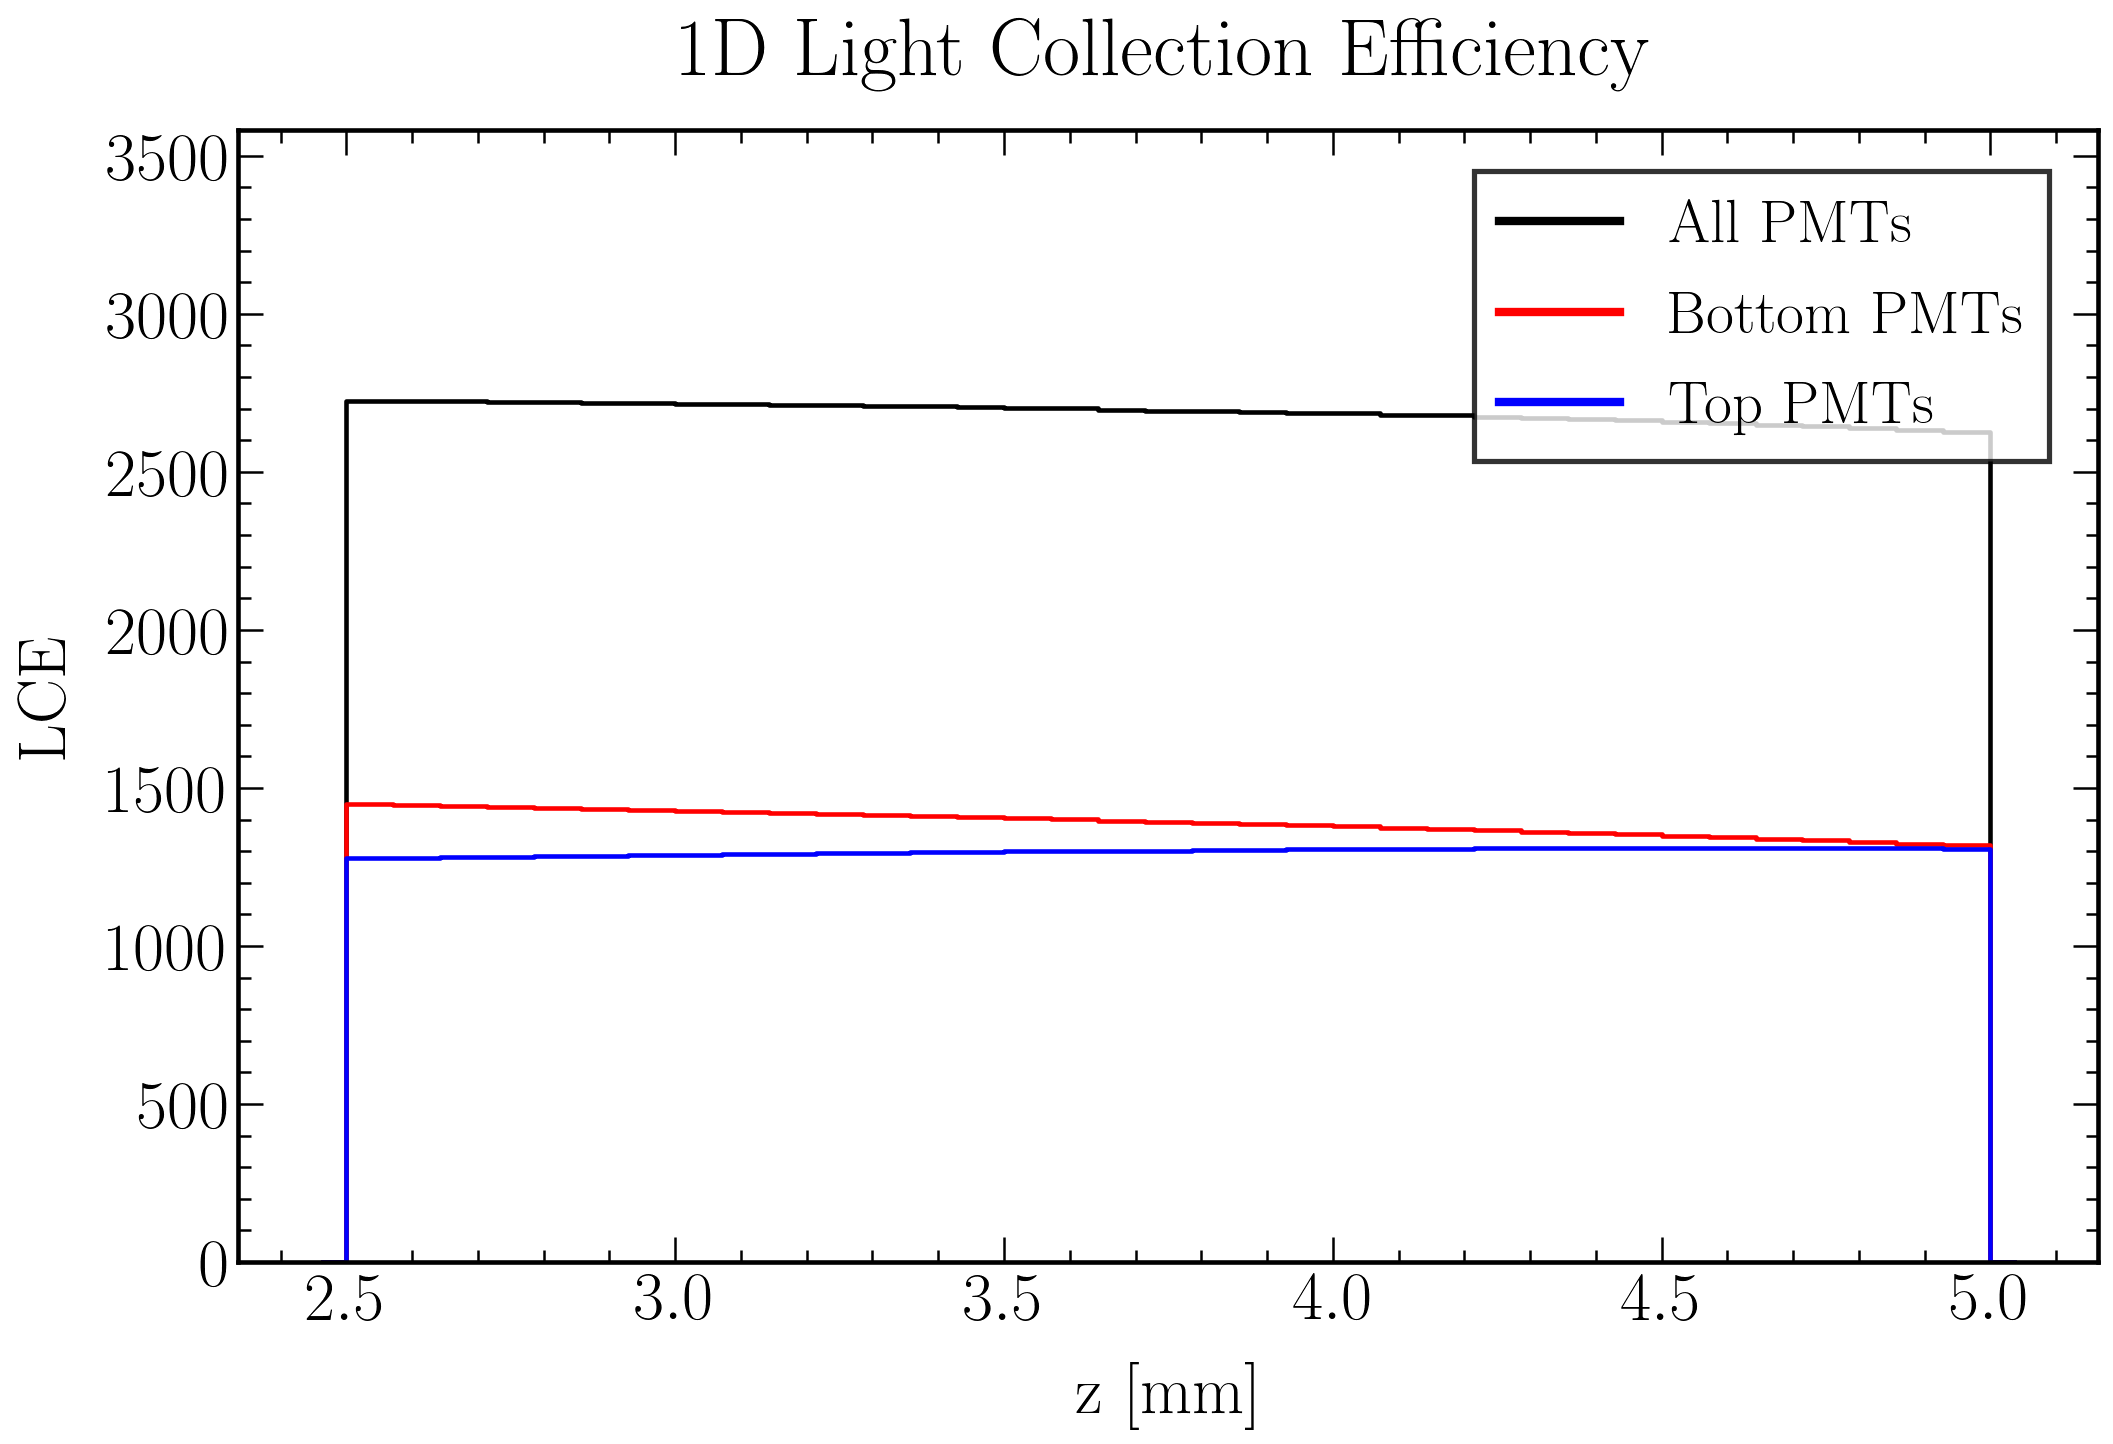

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

#numberbins = 70
#n, bins, patches = plt.hist(zp_pri, numberbins, weights = [1/(len(zp_pri)/numberbins)]*len(zp_pri), histtype = 'step', linewidth = 2.2, color = 'k')
'''
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.napmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.nbpmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.ntpmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''

#plt.ylim(bottom = 0)
plt.ylim(0, 1.33*np.median(LCE_z_hist['LCE'].loc['all']))

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_z_comparison.png")
plt.show()

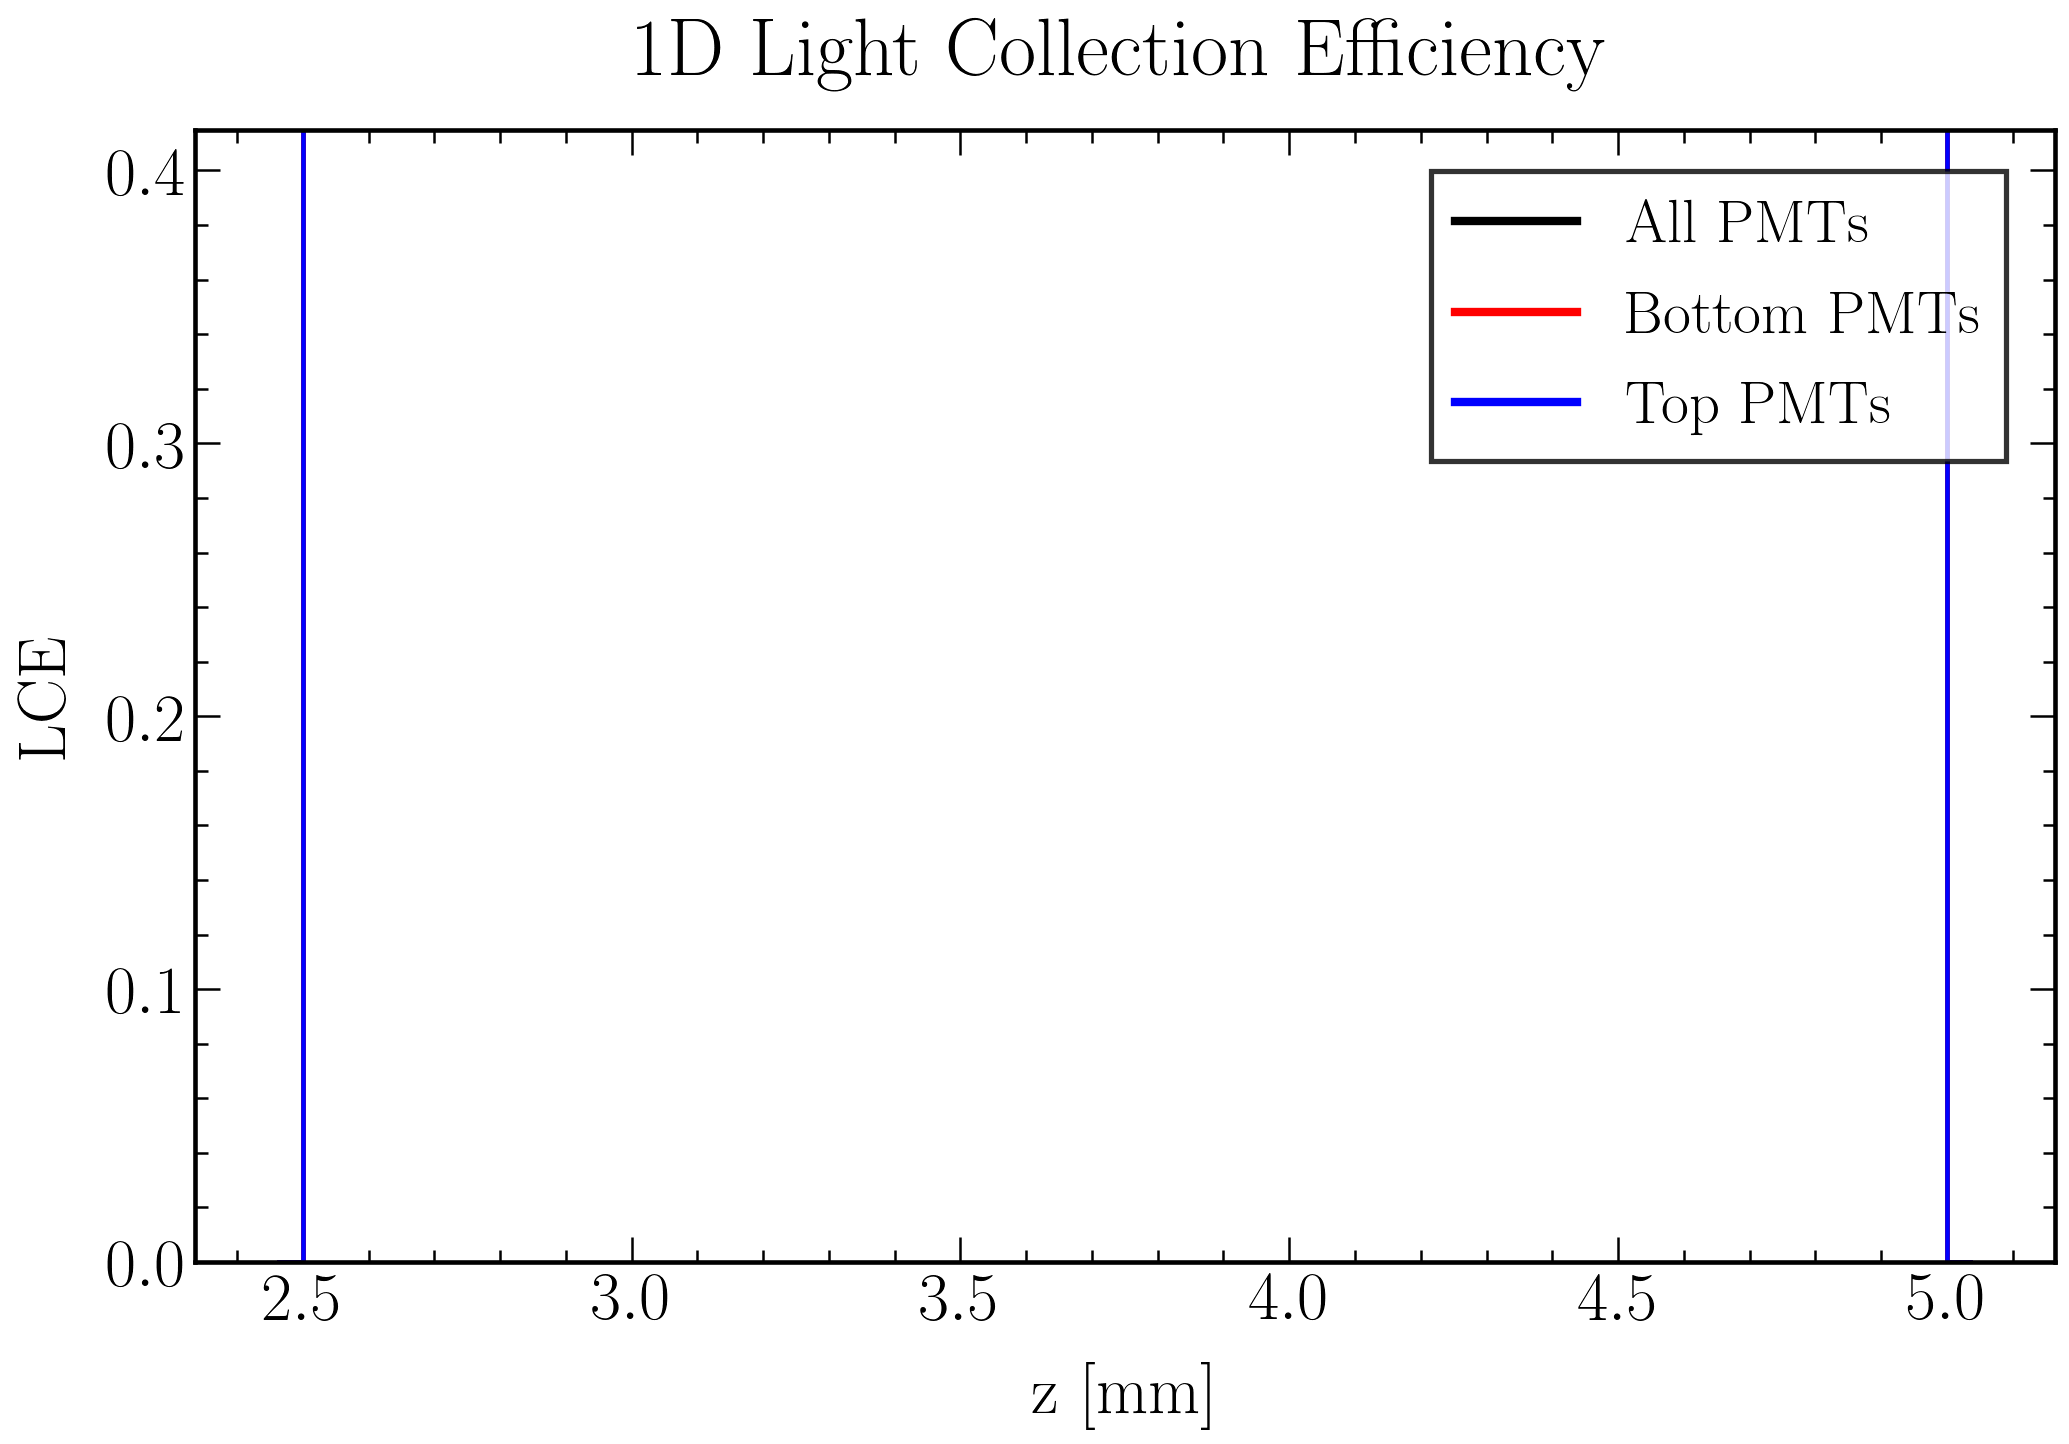

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_z_hist['LCE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

#numberbins = 70
#n, bins, patches = plt.hist(zp_pri, numberbins, weights = [1/(len(zp_pri)/numberbins)]*len(zp_pri), histtype = 'step', linewidth = 2.2, color = 'k')
'''
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.napmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.nbpmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.ntpmthits/nphotons*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
plt.ylim(0.,0.415)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_z_comparison_scaled.png")
plt.show()

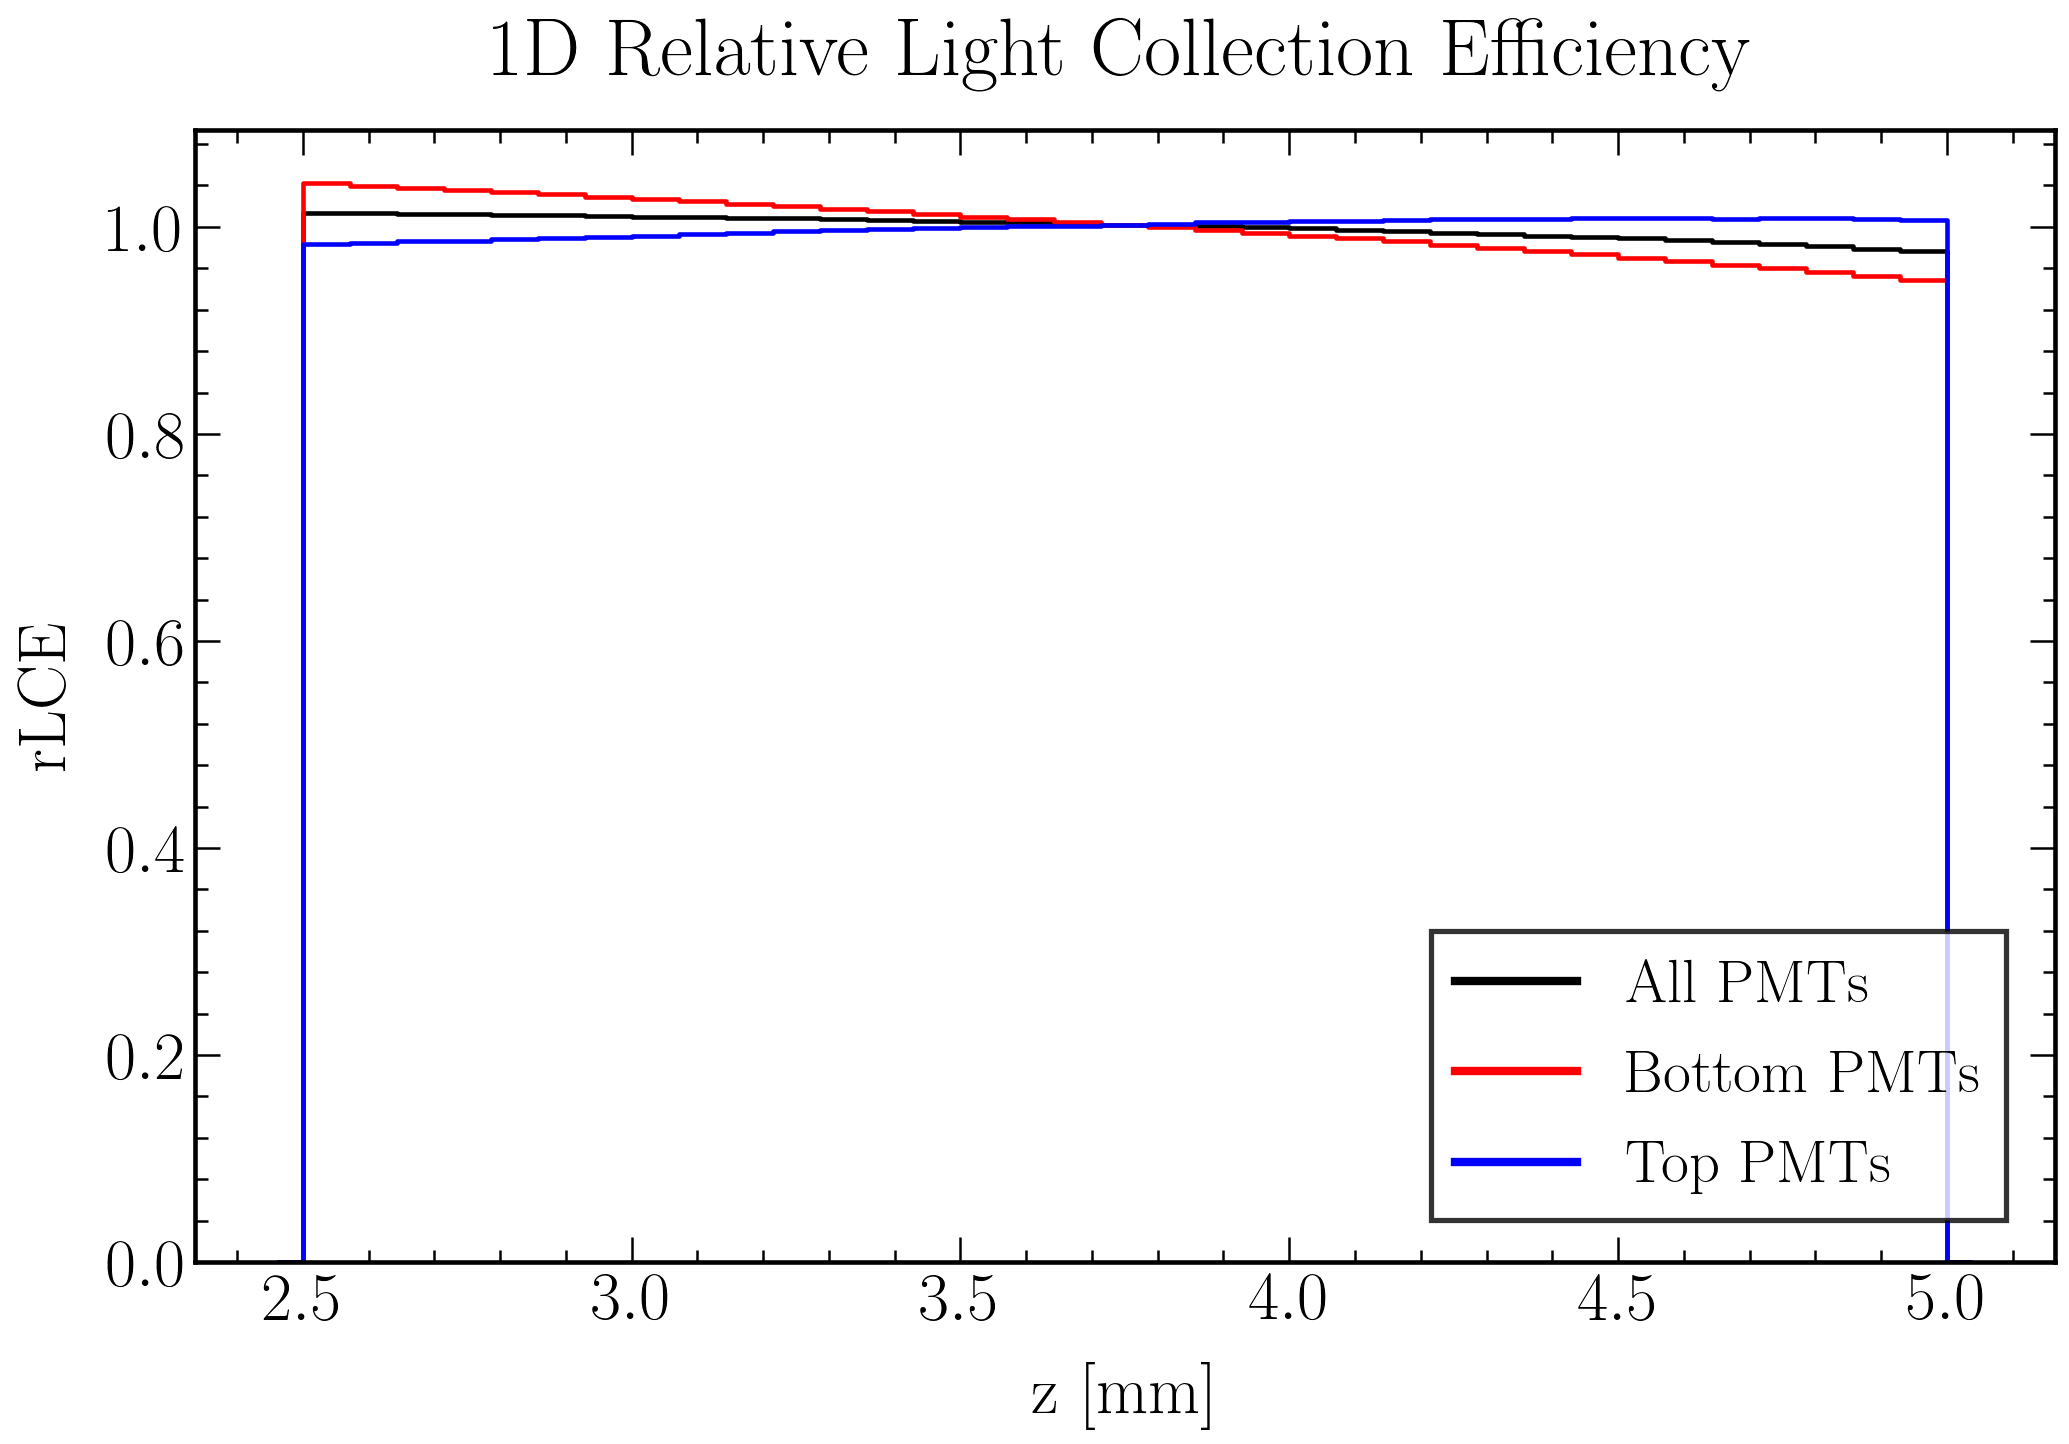

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['rLCE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_z_hist['rLCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_z_hist['rLCE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.ylim(bottom = 0)

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('rLCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Relative Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_rLCE_z_comparison.png")
plt.show()

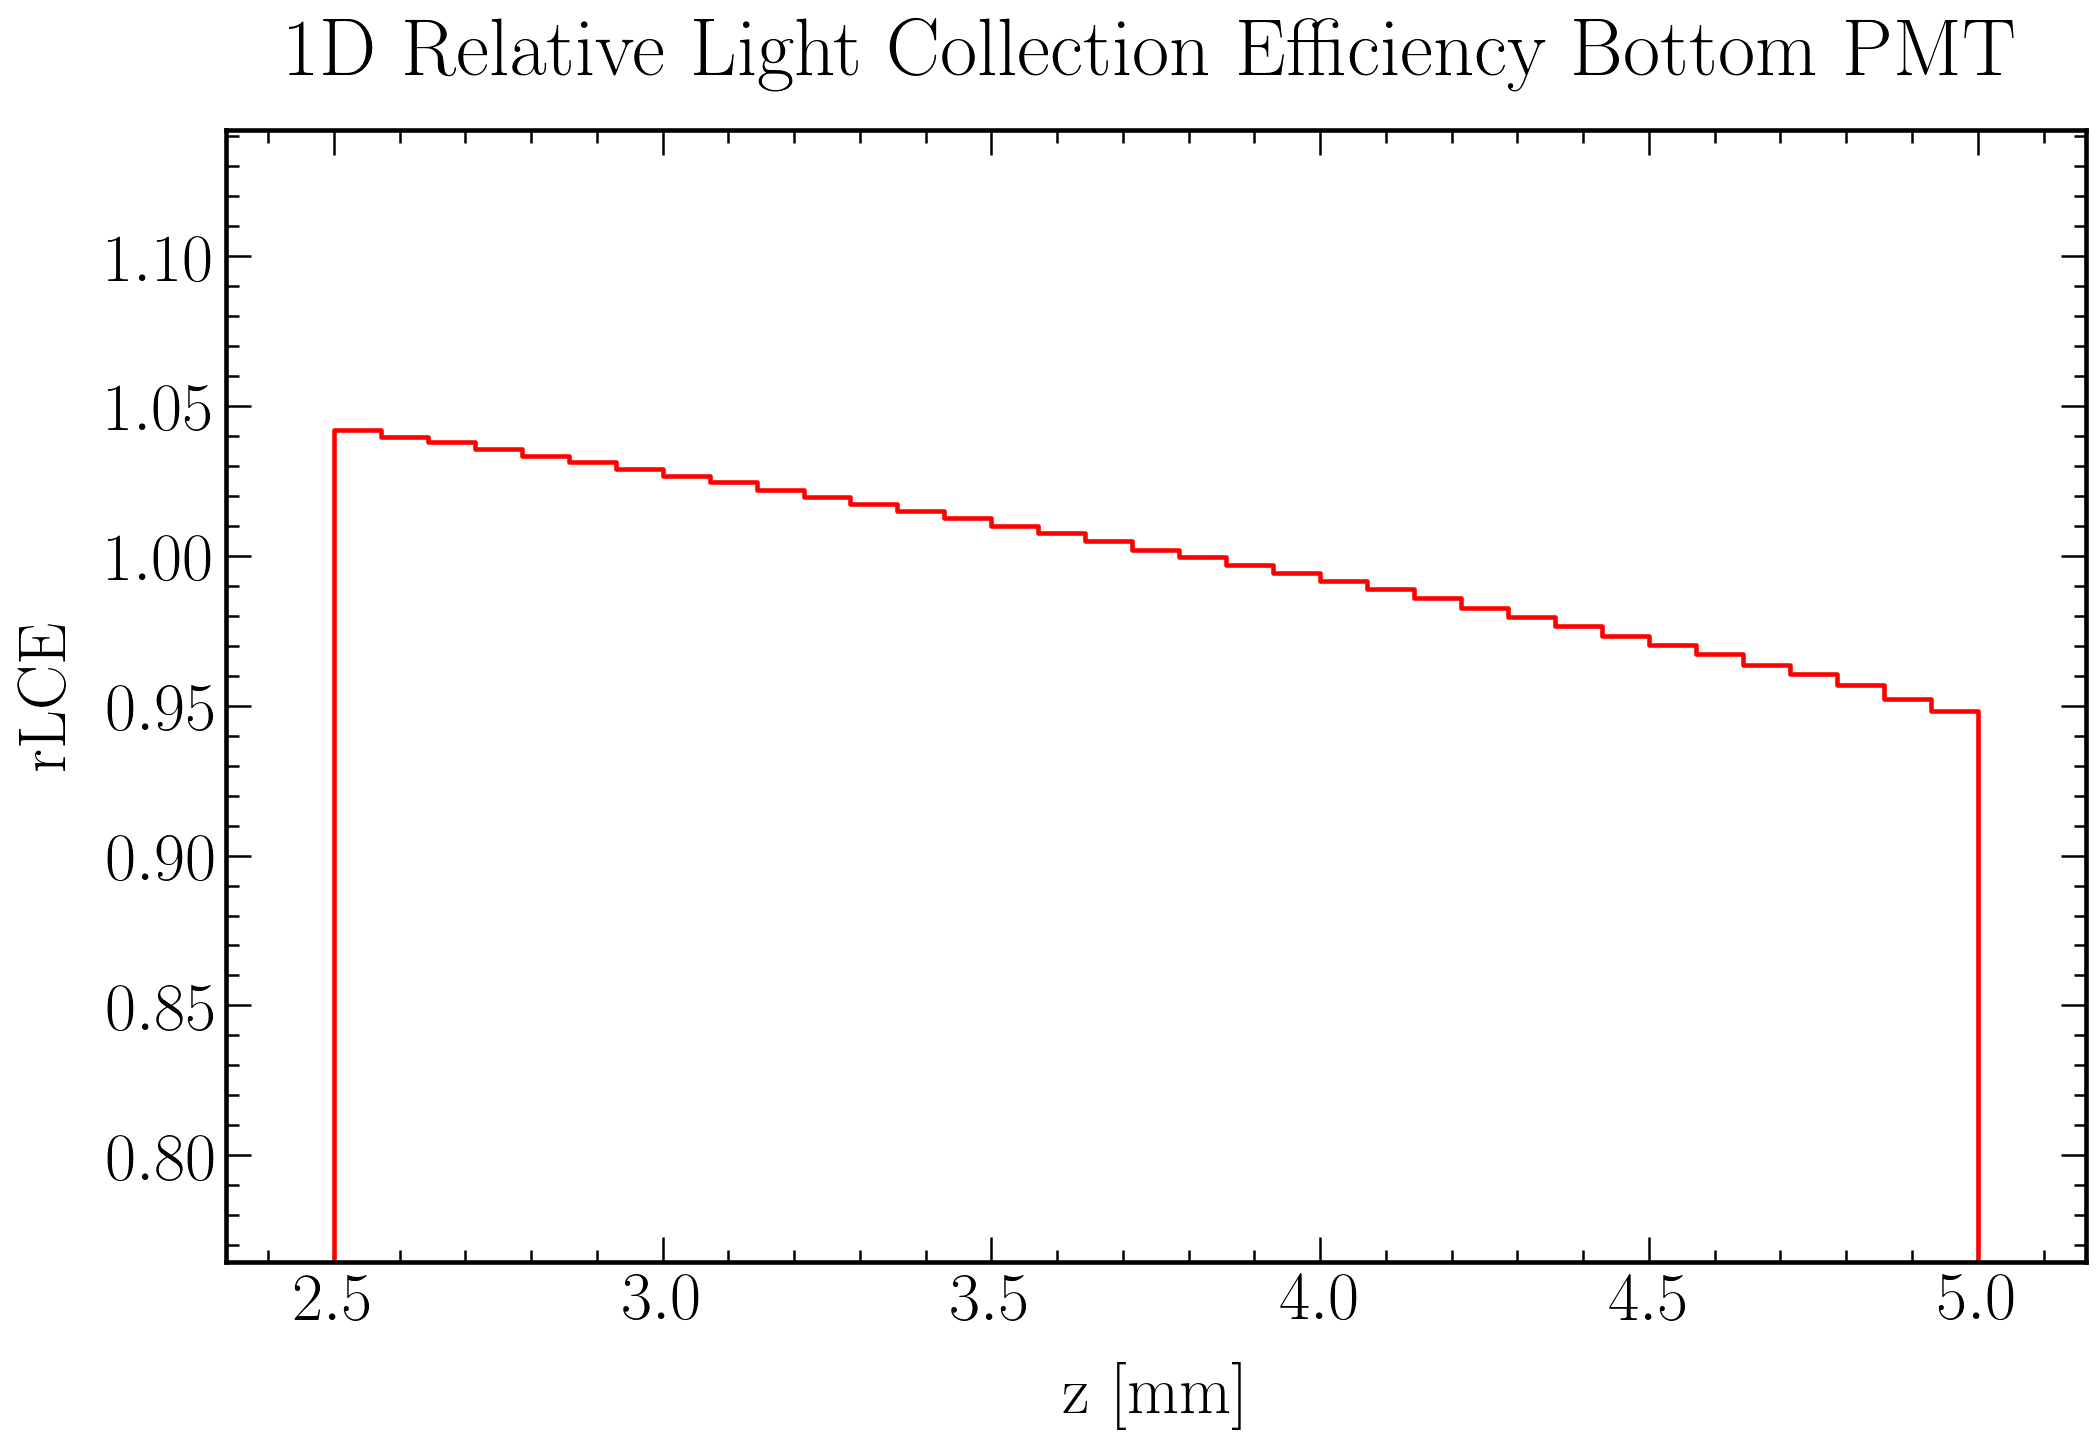

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['rLCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')

plt.ylim(0.8*np.percentile(LCE_z_hist['rLCE'].loc['bottom'],5), 1.1*np.percentile(LCE_z_hist['rLCE'].loc['bottom'],95))

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('rLCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Relative Light Collection Efficiency Bottom PMT', fontsize = title_size, pad = title_pad)

fig.savefig(filenameprefix+"_rLCE_z_bottom.png")
plt.show()

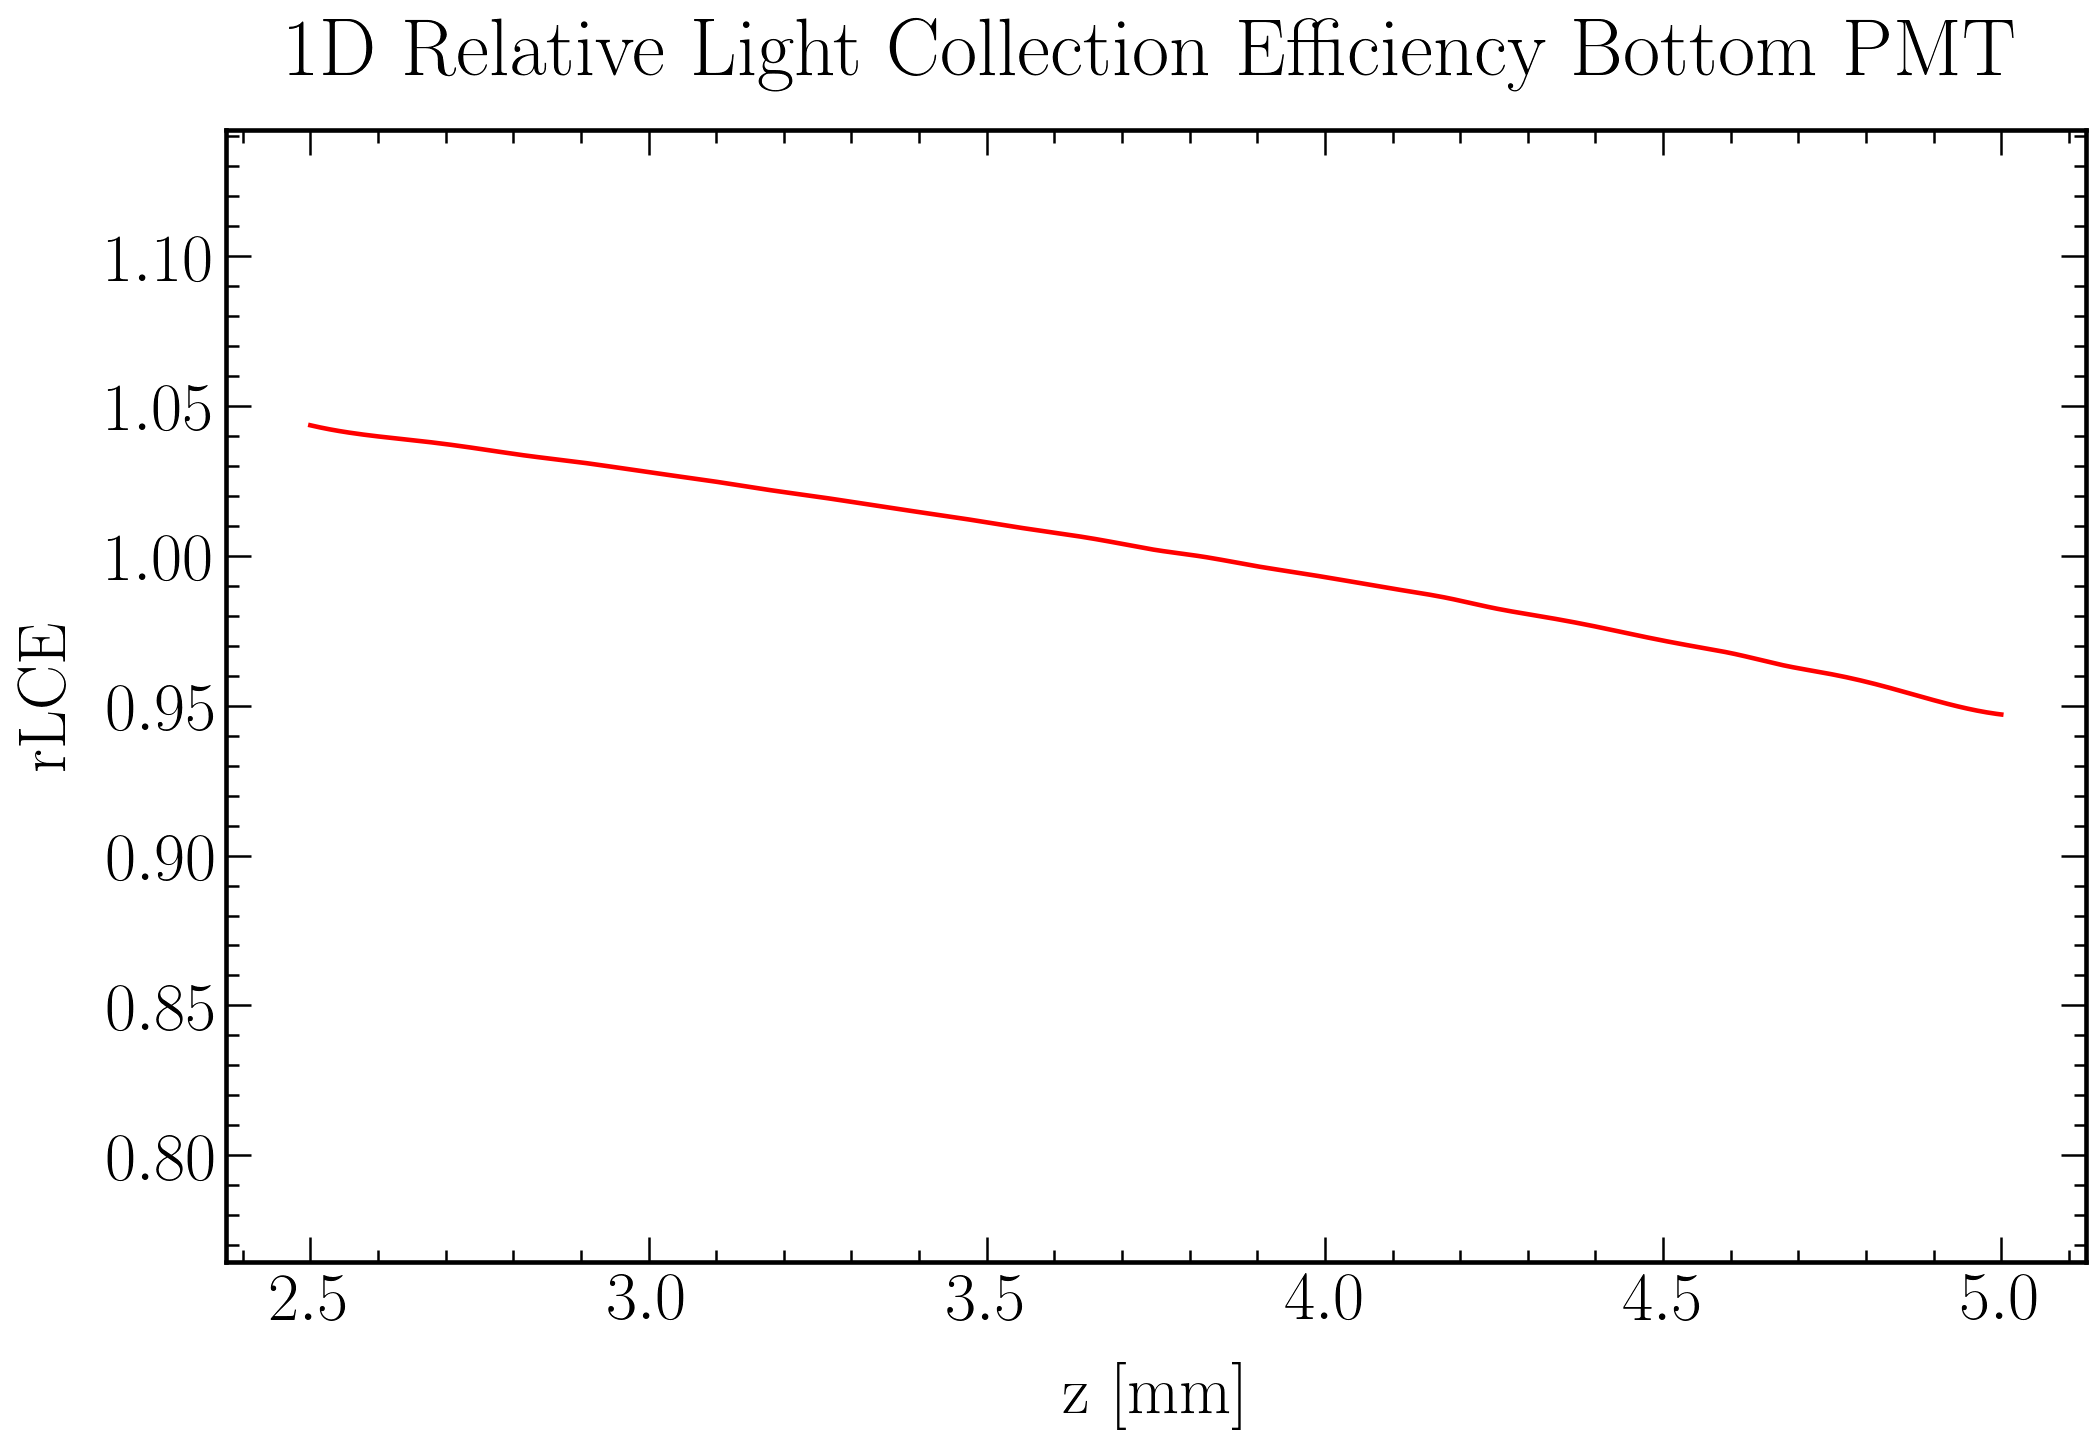

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

znew = np.linspace(LCE_z_hist['bins_z'].loc['all'][0], LCE_z_hist['bins_z'].loc['bottom'][-1], 350)
#rLCEz_smooth = spline(LCE_z_hist['binscenter_z'].loc['bottom'], LCE_z_hist['rLCE'].loc['bottom'], znew)
spl = make_interp_spline(LCE_z_hist['binscenter_z'].loc['bottom'], LCE_z_hist['rLCE'].loc['bottom'], k=3) #BSpline object
rLCEz_smooth = spl(znew)
plt.plot(znew, rLCEz_smooth, linewidth = 2.2, label = 'Bottom PMTs', color = 'r')

plt.ylim(0.8*np.percentile(LCE_z_hist['rLCE'].loc['bottom'],5), 1.1*np.percentile(LCE_z_hist['rLCE'].loc['bottom'],95))

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('rLCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Relative Light Collection Efficiency Bottom PMT', fontsize = title_size, pad = title_pad)

fig.savefig(filenameprefix+"_rLCE_z_bottom_smooth.png")
plt.show()

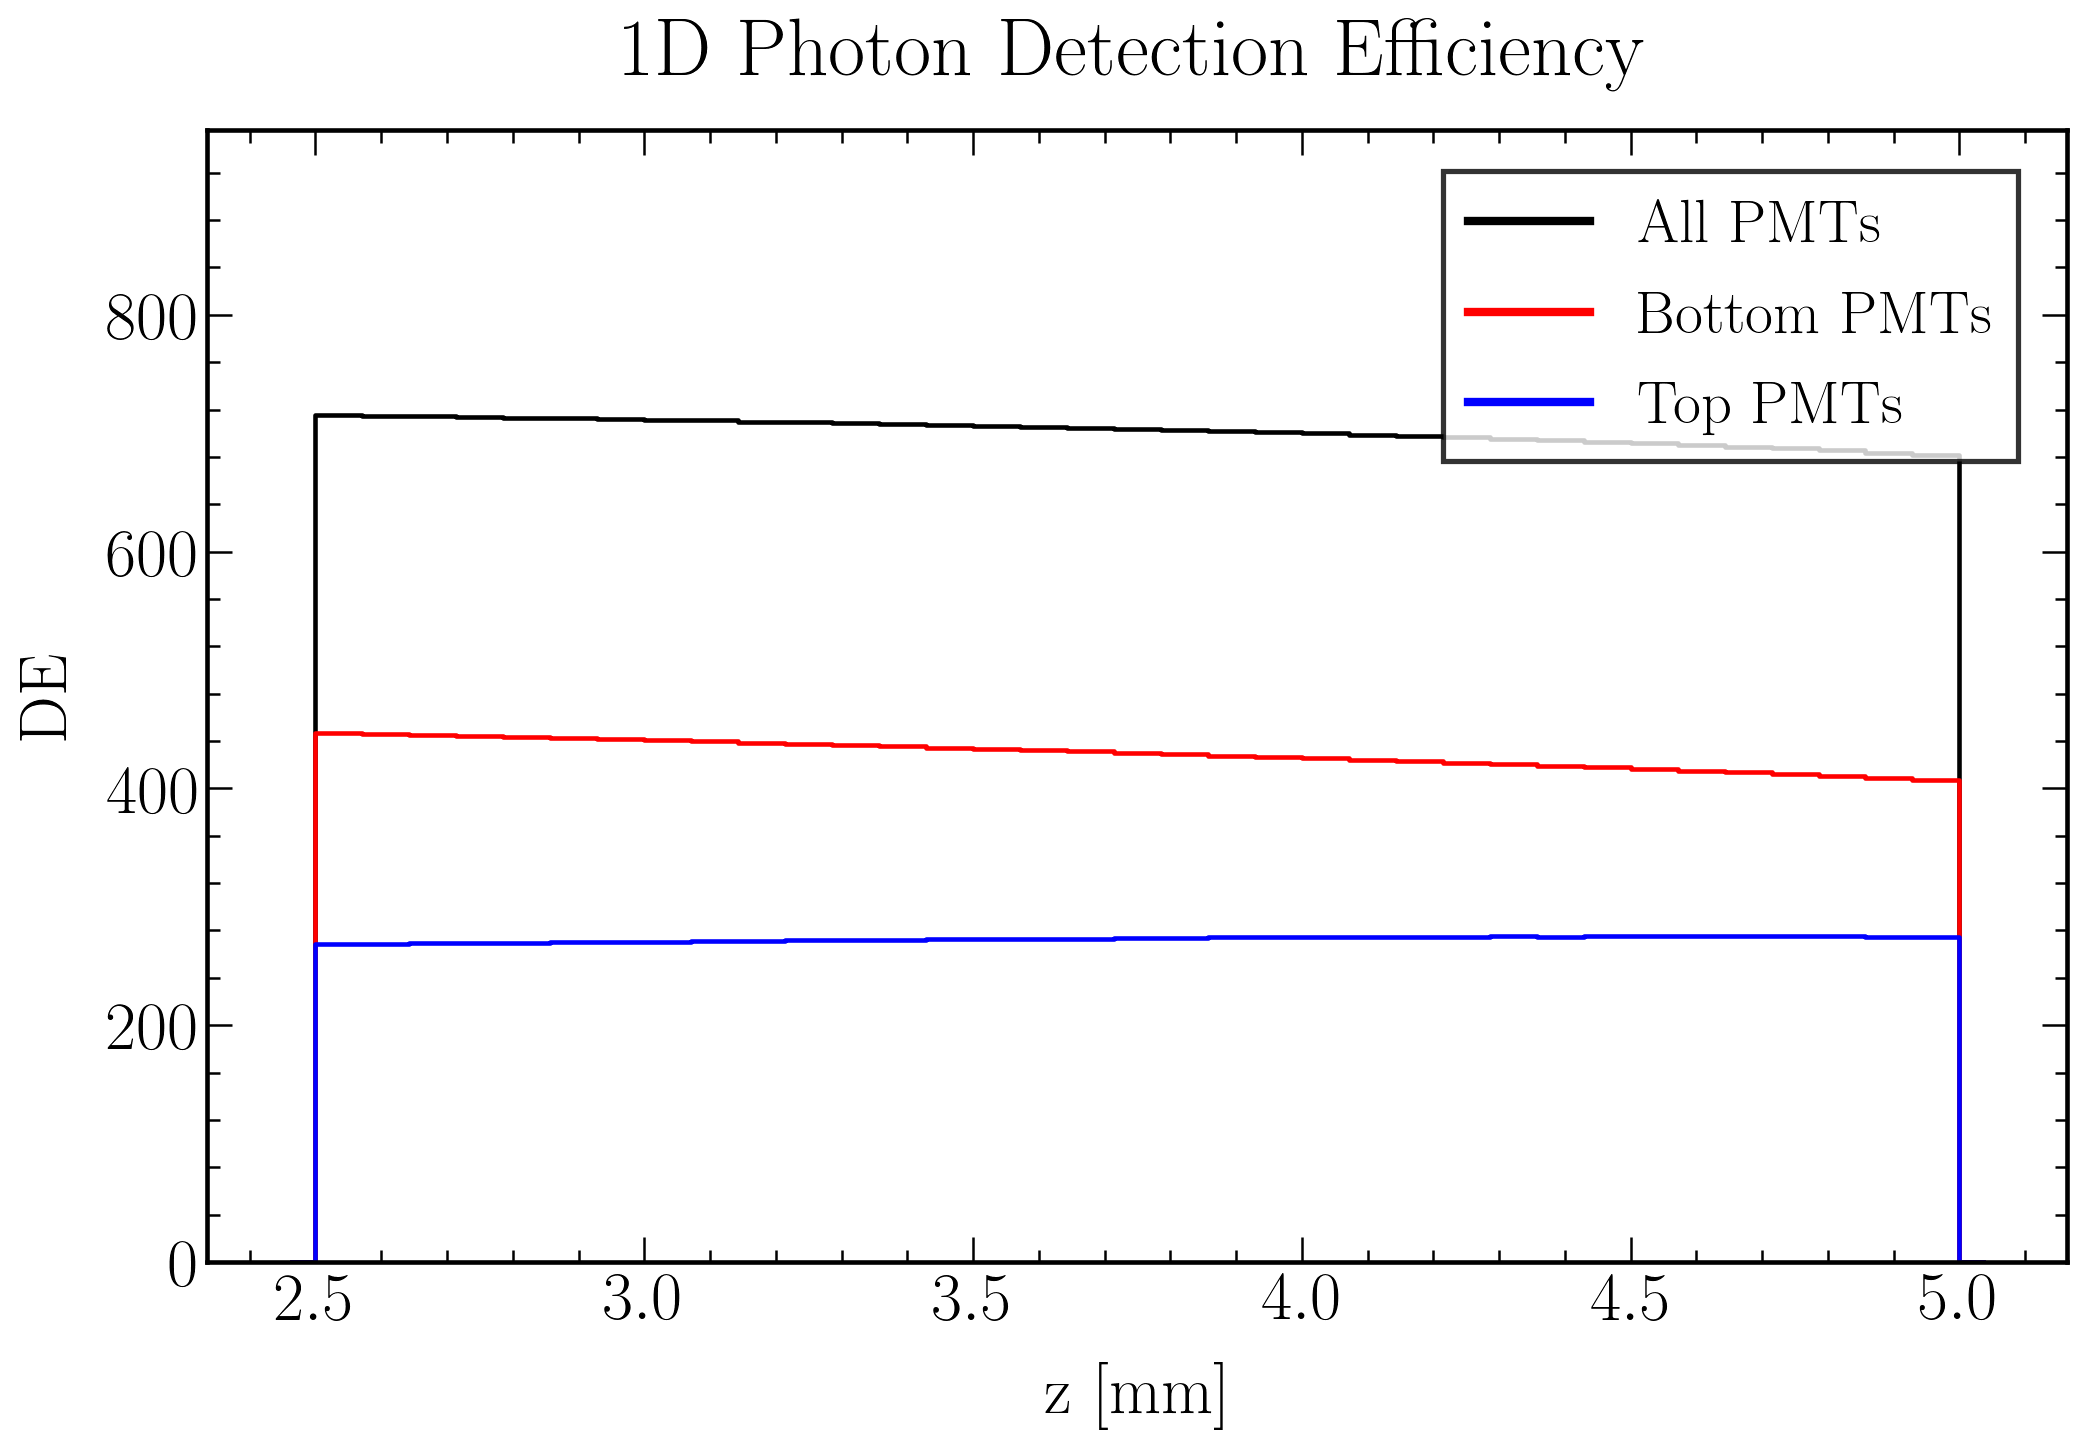

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 70

# Data plot
bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['DE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_z_hist['DE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_z_hist['DE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

'''
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''
plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('DE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Photon Detection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(-10,180)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')
#plt.ylim(bottom = 0)
plt.ylim(0, 1.36*np.median(LCE_z_hist['DE'].loc['all']))

fig.savefig(filenameprefix+"_DE_z_comparison.png")
plt.show()

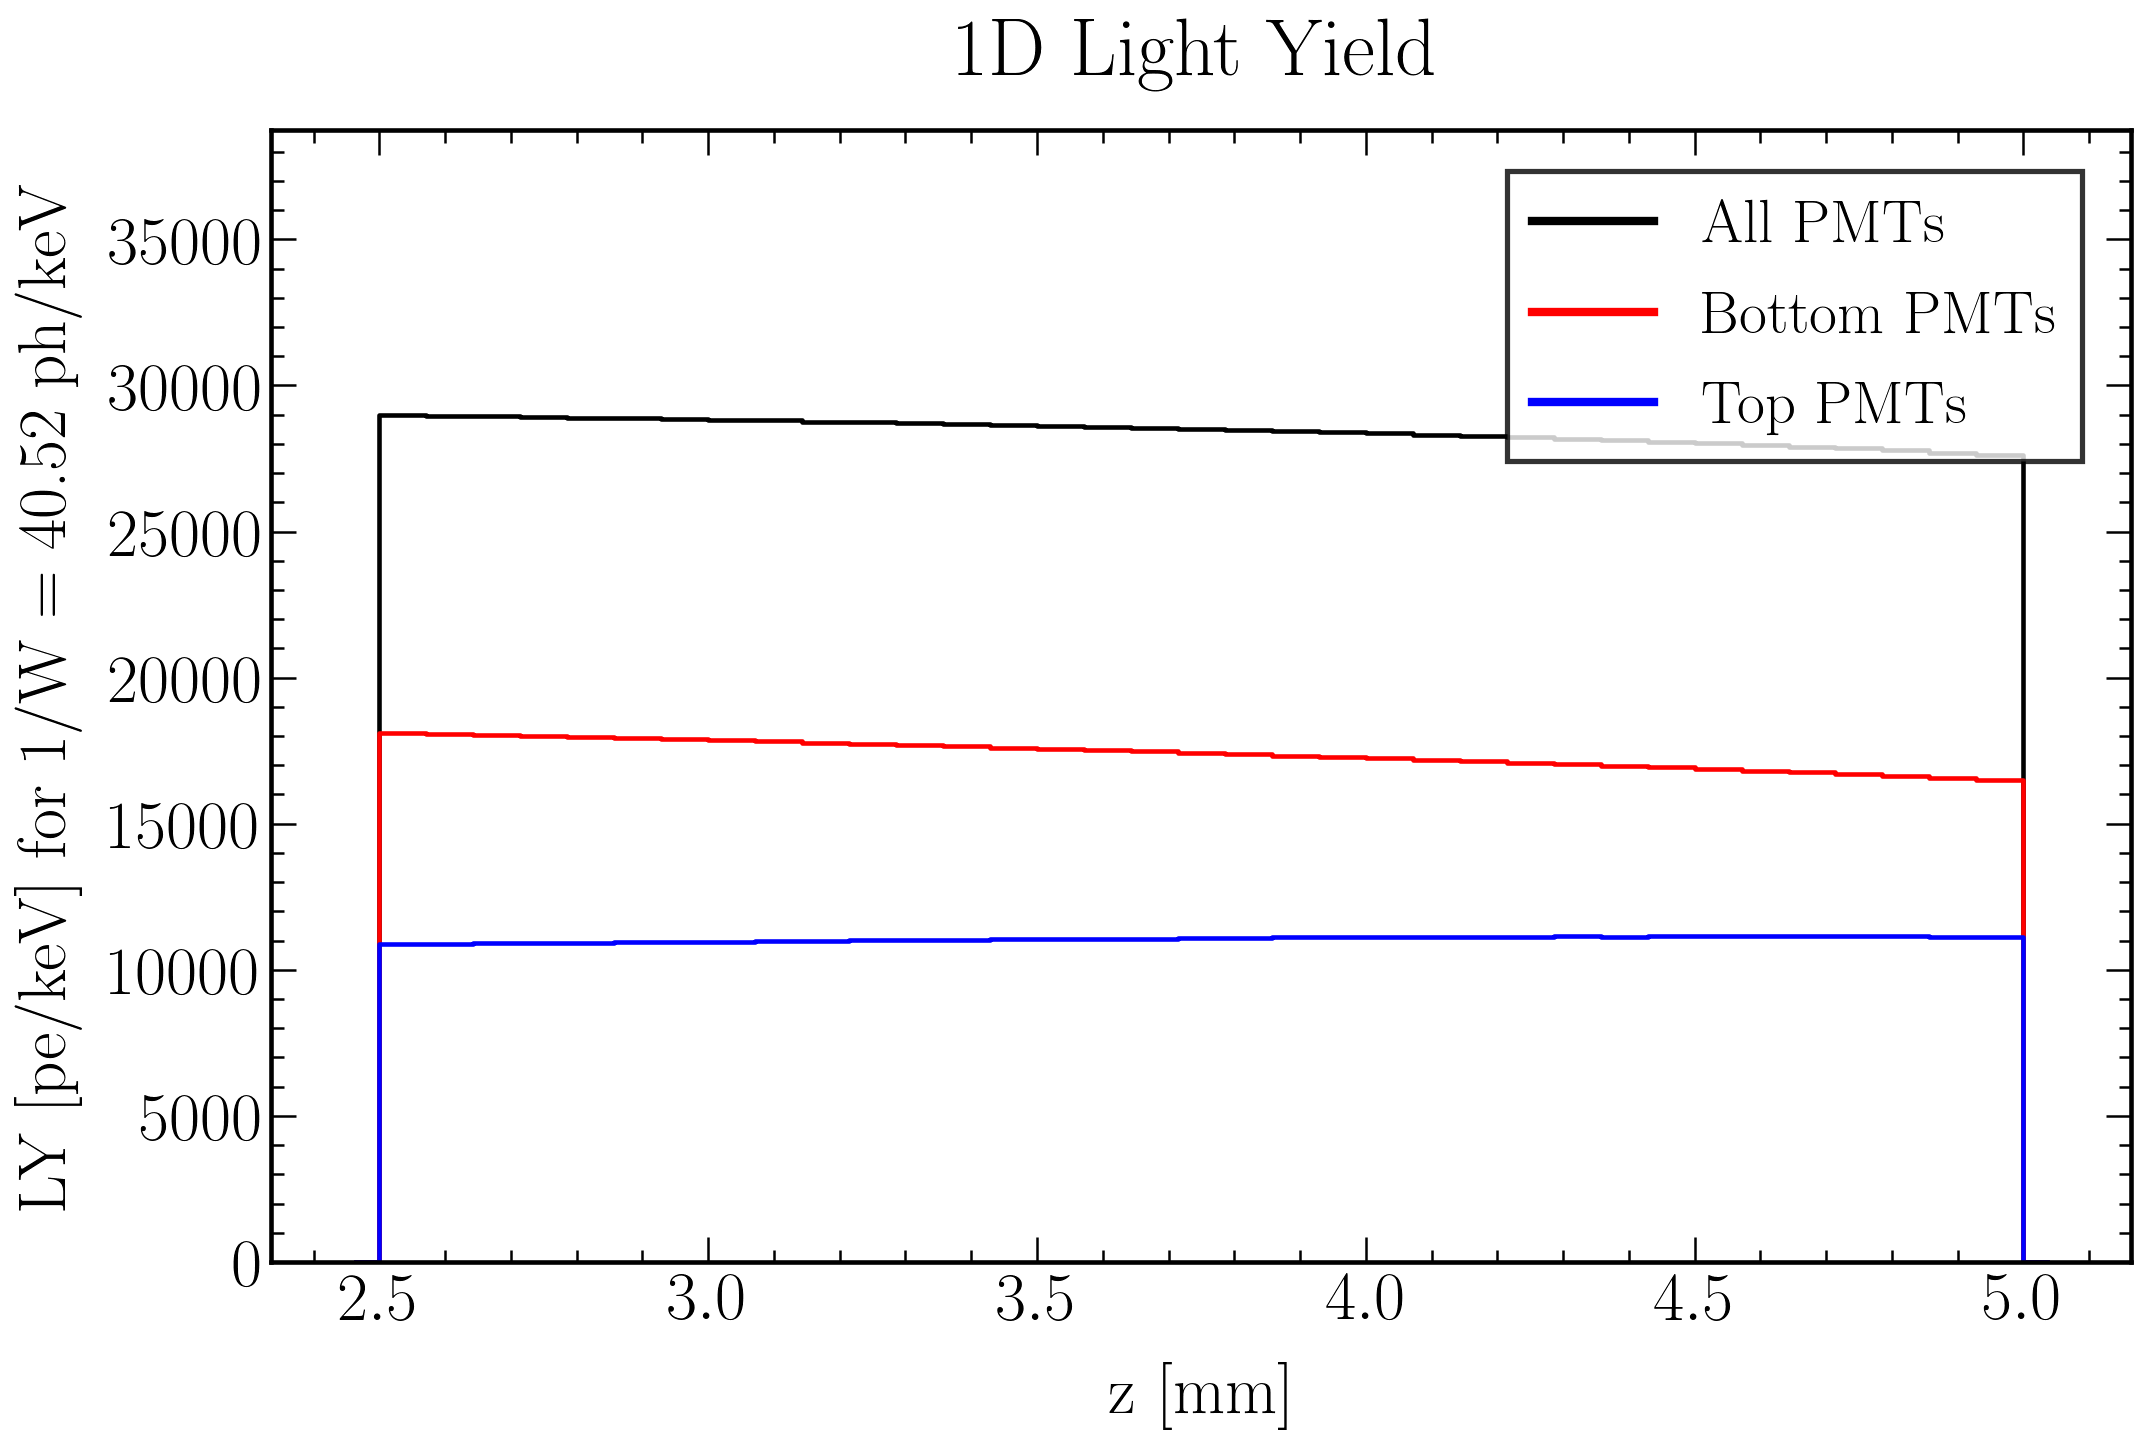

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 70

# Data plot
bns = np.concatenate((np.array([2*LCE_z_hist['binscenter_z'].loc['all'][0]-LCE_z_hist['binscenter_z'].loc['all'][1]]), LCE_z_hist['binscenter_z'].loc['all'], np.array([2*LCE_z_hist['binscenter_z'].loc['all'][-1]-LCE_z_hist['binscenter_z'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_z_hist['LY'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_z_hist['LY'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_z_hist['LY'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

'''
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''
plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LY [pe/keV] for 1/W = '+str(round(1/W,2))+' ph/keV', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Yield', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(-10,180)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')
#plt.ylim(bottom = 0)
plt.ylim(0, 1.36*np.median(LCE_z_hist['LY'].loc['all']))

fig.savefig(filenameprefix+"_LY_z_comparison.png")
plt.show()

#### Histogram in r²

range: (0, 1225) 



n_total  \
all     [28478.0, 28361.0, 28533.0, 28641.0, 28723.0, ...   
top     [28478.0, 28361.0, 28533.0, 28641.0, 28723.0, ...   
bottom  [28478.0, 28361.0, 28533.0, 28641.0, 28723.0, ...   

                                                   n_hits  \
all     [83005827.0, 81727183.0, 81453831.0, 81141870....   
top     [42519617.0, 41342278.0, 40806893.0, 40367817....   
bottom  [40486210.0, 40384905.0, 40646938.0, 40774053....   

                                                  bins_r2  \
all     [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   
top     [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   
bottom  [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   

                                            binscenter_r2  \
all     [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   
top     [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   
bottom  [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   

                                                      LCE  \
all     [2914.7351288714094, 2881.674940940023, 2854.7...   
top     [1493.0689304024158, 1457.7158069179507, 1430....   
bottom  [1421.6661984689936, 1423.9591340220725, 1424....   

                                                     rLCE  \
all     [1.0838687897201766, 1.0715750805847644, 1.061...   
top     [1.1491915075468477, 1.1219807683463126, 1.100...   
bottom  [1.02280988960045, 1.0244595294121241, 1.02489...   

                                                       DE  \
all     [752.483914161809, 745.7677020820845, 740.1671...   
top     [313.5444753845073, 306.1203194527696, 300.334...   
bottom  [438.93943877730175, 439.64738262931485, 439.8...   

                                                       LY  \
all     [30491.152865995504, 30219.007448200846, 29992...   
top     [12705.032425691943, 12404.200648220984, 12169...   
bottom  [17786.120440303563, 17814.80679997986, 17822....   

                                                      LY0  
all     [51384.30411880618, 50925.679186716596, 50543....  
top     [21410.776196957486, 20903.80843453457, 20508....  
bottom  [29973.527921848694, 30021.870752182018, 30034...

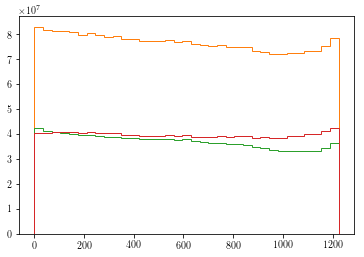

In [33]:
if b_preprocessed == False:
    numberbins_r2 = numberbins
    rng = (0, 35**2)
    print('range: '+str(rng)+' \n')

    n_r2_total, bins_r2_total, patches_r2_total = plt.hist(_chunk_collect.rp_pri2, numberbins_r2, weights = None, range = rng, histtype = 'step');
    n_r2_hits_a, bins_r2_hits_a, patches_r2_hits_a = plt.hist(_chunk_collect.rp_pri2, numberbins_r2, weights = _chunk_collect.napmthits, range = rng, histtype = 'step');
    n_r2_hits_t, bins_r2_hits_t, patches_r2_hits_t = plt.hist(_chunk_collect.rp_pri2, numberbins_r2, weights = _chunk_collect.ntpmthits, range = rng, histtype = 'step');
    n_r2_hits_b, bins_r2_hits_b, patches_r2_hits_b = plt.hist(_chunk_collect.rp_pri2, numberbins_r2, weights = _chunk_collect.nbpmthits, range = rng, histtype = 'step');

    binscenter_r2_total = (bins_r2_total[:-1]+bins_r2_total[1:])/2
    binscenter_r2_hits_a = (bins_r2_hits_a[:-1]+bins_r2_hits_a[1:])/2
    binscenter_r2_hits_t = (bins_r2_hits_t[:-1]+bins_r2_hits_t[1:])/2
    binscenter_r2_hits_b = (bins_r2_hits_b[:-1]+bins_r2_hits_b[1:])/2

    n_r2_LCE_a = n_r2_hits_a / n_r2_total
    n_r2_LCE_t = n_r2_hits_t / n_r2_total
    n_r2_LCE_b = n_r2_hits_b / n_r2_total

    n_r2_rLCE_a = n_r2_LCE_a / n_r2_LCE_a.mean()
    n_r2_rLCE_t = n_r2_LCE_t / n_r2_LCE_t.mean()
    n_r2_rLCE_b = n_r2_LCE_b / n_r2_LCE_b.mean()

    n_r2_DE_t = n_r2_LCE_t * QE_Top * CE_Top
    n_r2_DE_b = n_r2_LCE_b * QE_Bottom * CE_Bottom
    n_r2_DE_a = n_r2_DE_t + n_r2_DE_b

    n_r2_LY_t = n_r2_DE_t/W
    n_r2_LY_b = n_r2_DE_b/W
    n_r2_LY_a = n_r2_DE_a/W

    n_r2_LY0_t = n_r2_DE_t/W0
    n_r2_LY0_b = n_r2_DE_b/W0
    n_r2_LY0_a = n_r2_DE_a/W0

    LCE_r2_hist = pd.DataFrame({'n_total' : [n_r2_total,n_r2_total,n_r2_total], 'n_hits' : [n_r2_hits_a,n_r2_hits_t,n_r2_hits_b], 'bins_r2' : [bins_r2_hits_a,bins_r2_hits_t,bins_r2_hits_b], 'binscenter_r2' : [binscenter_r2_hits_a,binscenter_r2_hits_t,binscenter_r2_hits_b], 'LCE' : [n_r2_LCE_a,n_r2_LCE_t,n_r2_LCE_b], 'rLCE' : [n_r2_rLCE_a,n_r2_rLCE_t,n_r2_rLCE_b], 'DE' : [n_r2_DE_a,n_r2_DE_t,n_r2_DE_b], 'LY' : [n_r2_LY_a,n_r2_LY_t,n_r2_LY_b], 'LY0' : [n_r2_LY0_a,n_r2_LY0_t,n_r2_LY0_b]}, index=['all','top','bottom'])
    columns = ['n_total', 'n_hits', 'bins_r2', 'binscenter_r2', 'LCE', 'rLCE', 'DE', 'LY', 'LY0']
    LCE_r2_hist.to_pickle(filenameprefix+"_LCE_r2_hist.pkl")
    
if b_preprocessed == True:
    numberbins_r2 = numberbins
    rng = (0, 35**2)
    print('range: '+str(rng)+' \n')
    
LCE_r2_hist

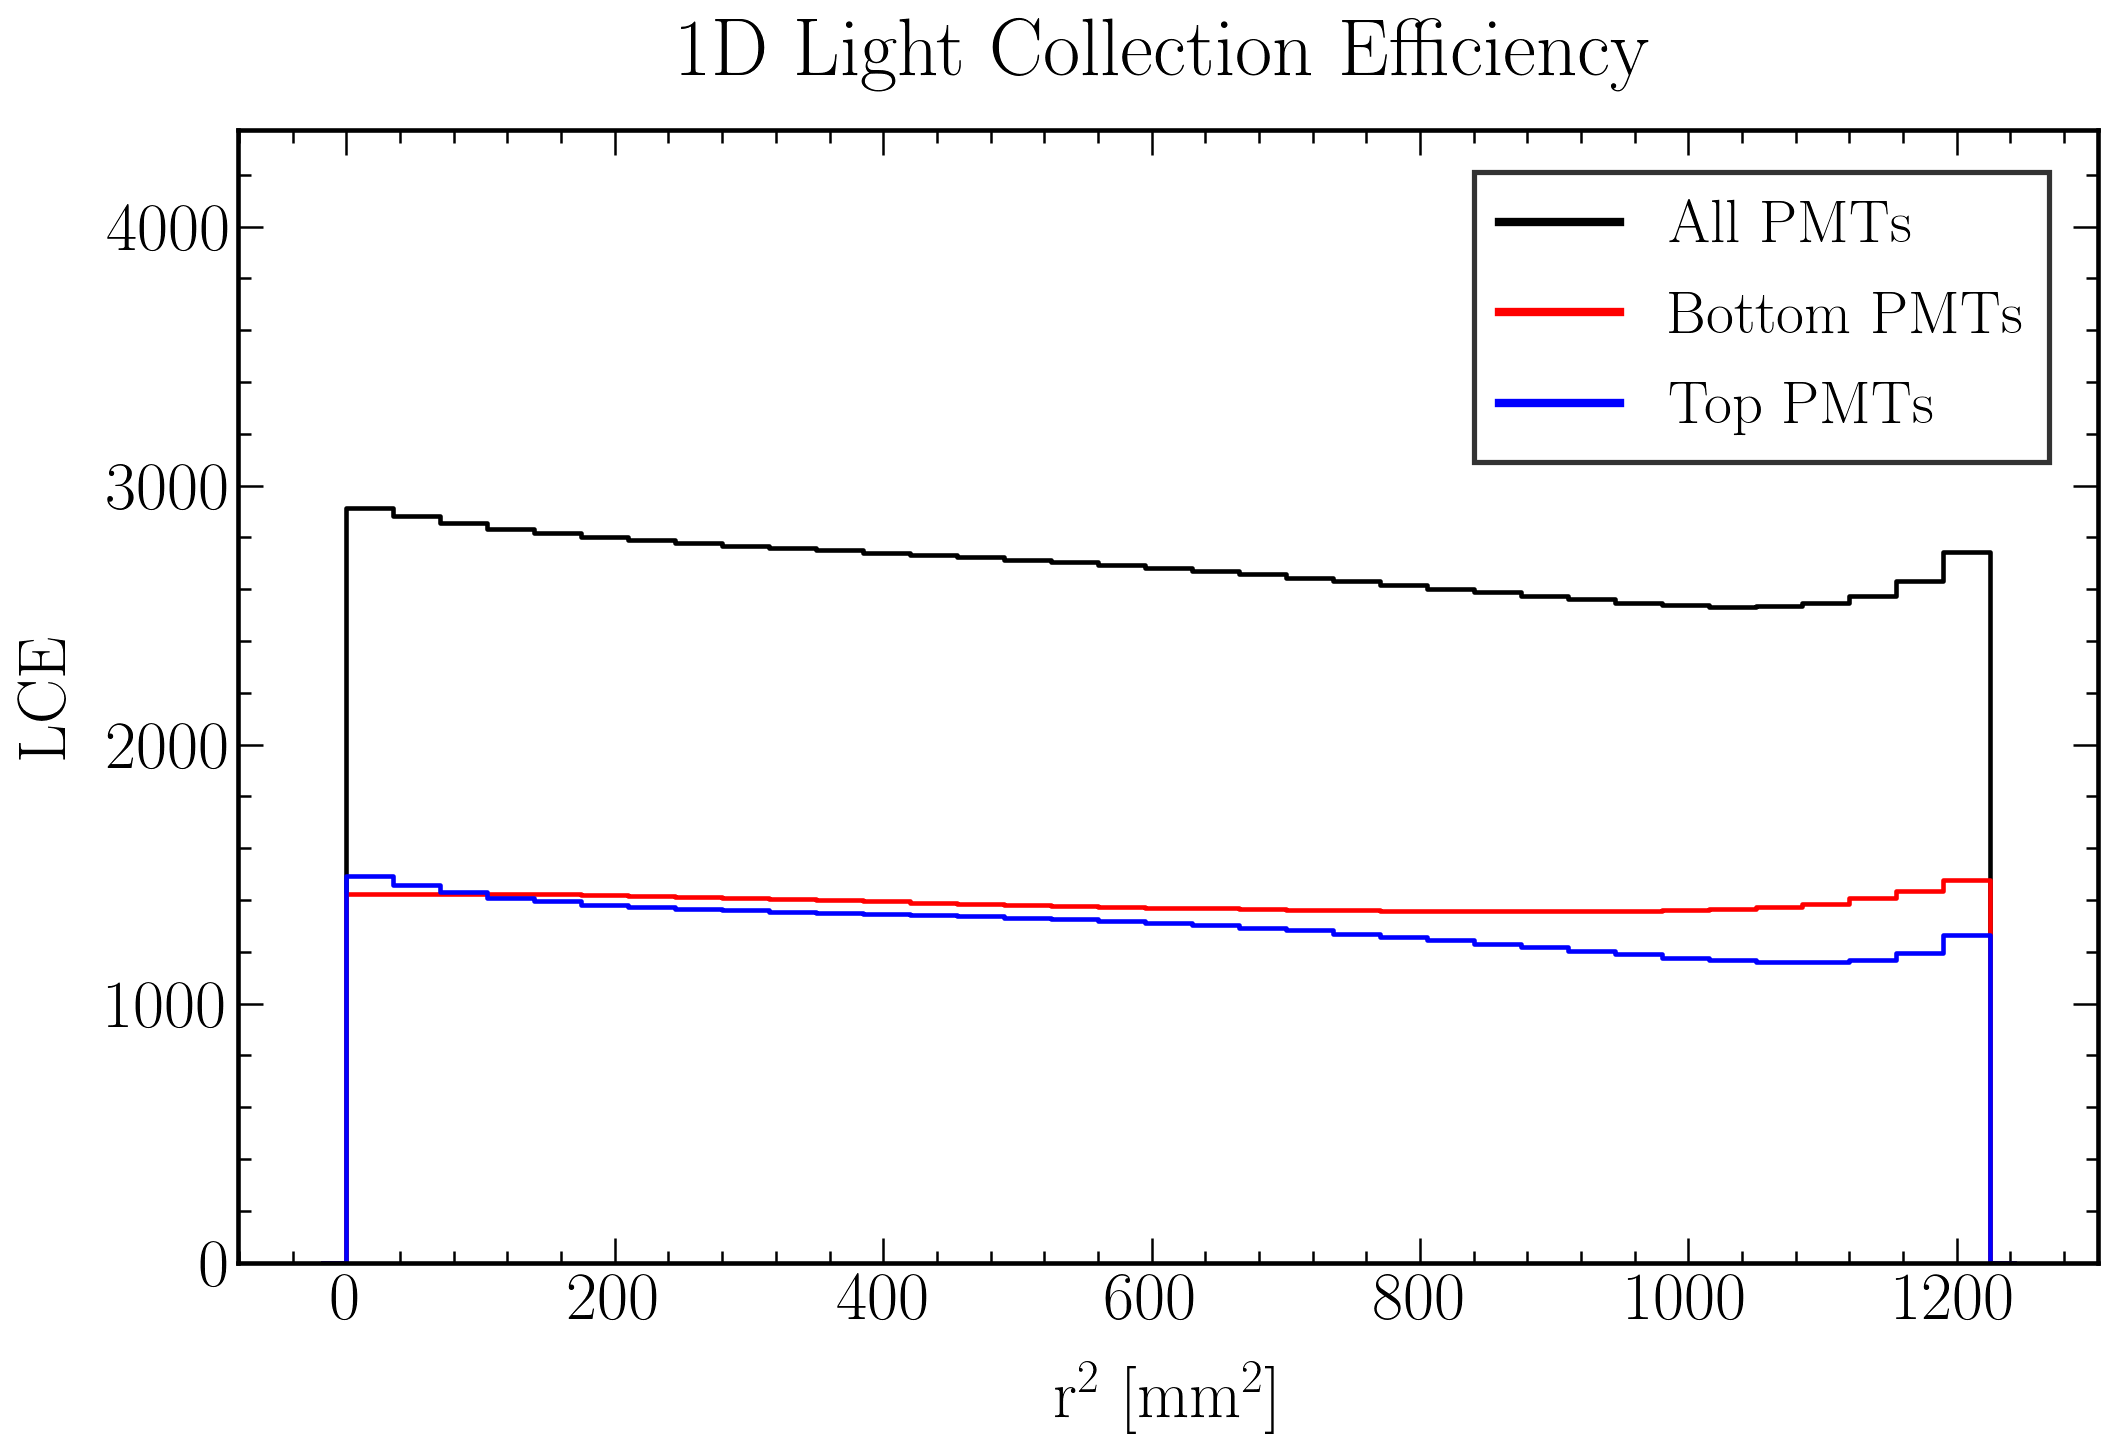

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 70

# Data plot
'''
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''

bns = np.concatenate((np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][0]-LCE_r2_hist['binscenter_r2'].loc['all'][1]]), LCE_r2_hist['binscenter_r2'].loc['all'], np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][-1]-LCE_r2_hist['binscenter_r2'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_r2_hist['LCE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_r2_hist['LCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_r2_hist['LCE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0,0.45)
plt.ylim(0,1.5*LCE_r2_hist['LCE'].loc['all'].max())
#plt.ylim(0,0.12)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_comparison.png")
plt.show()

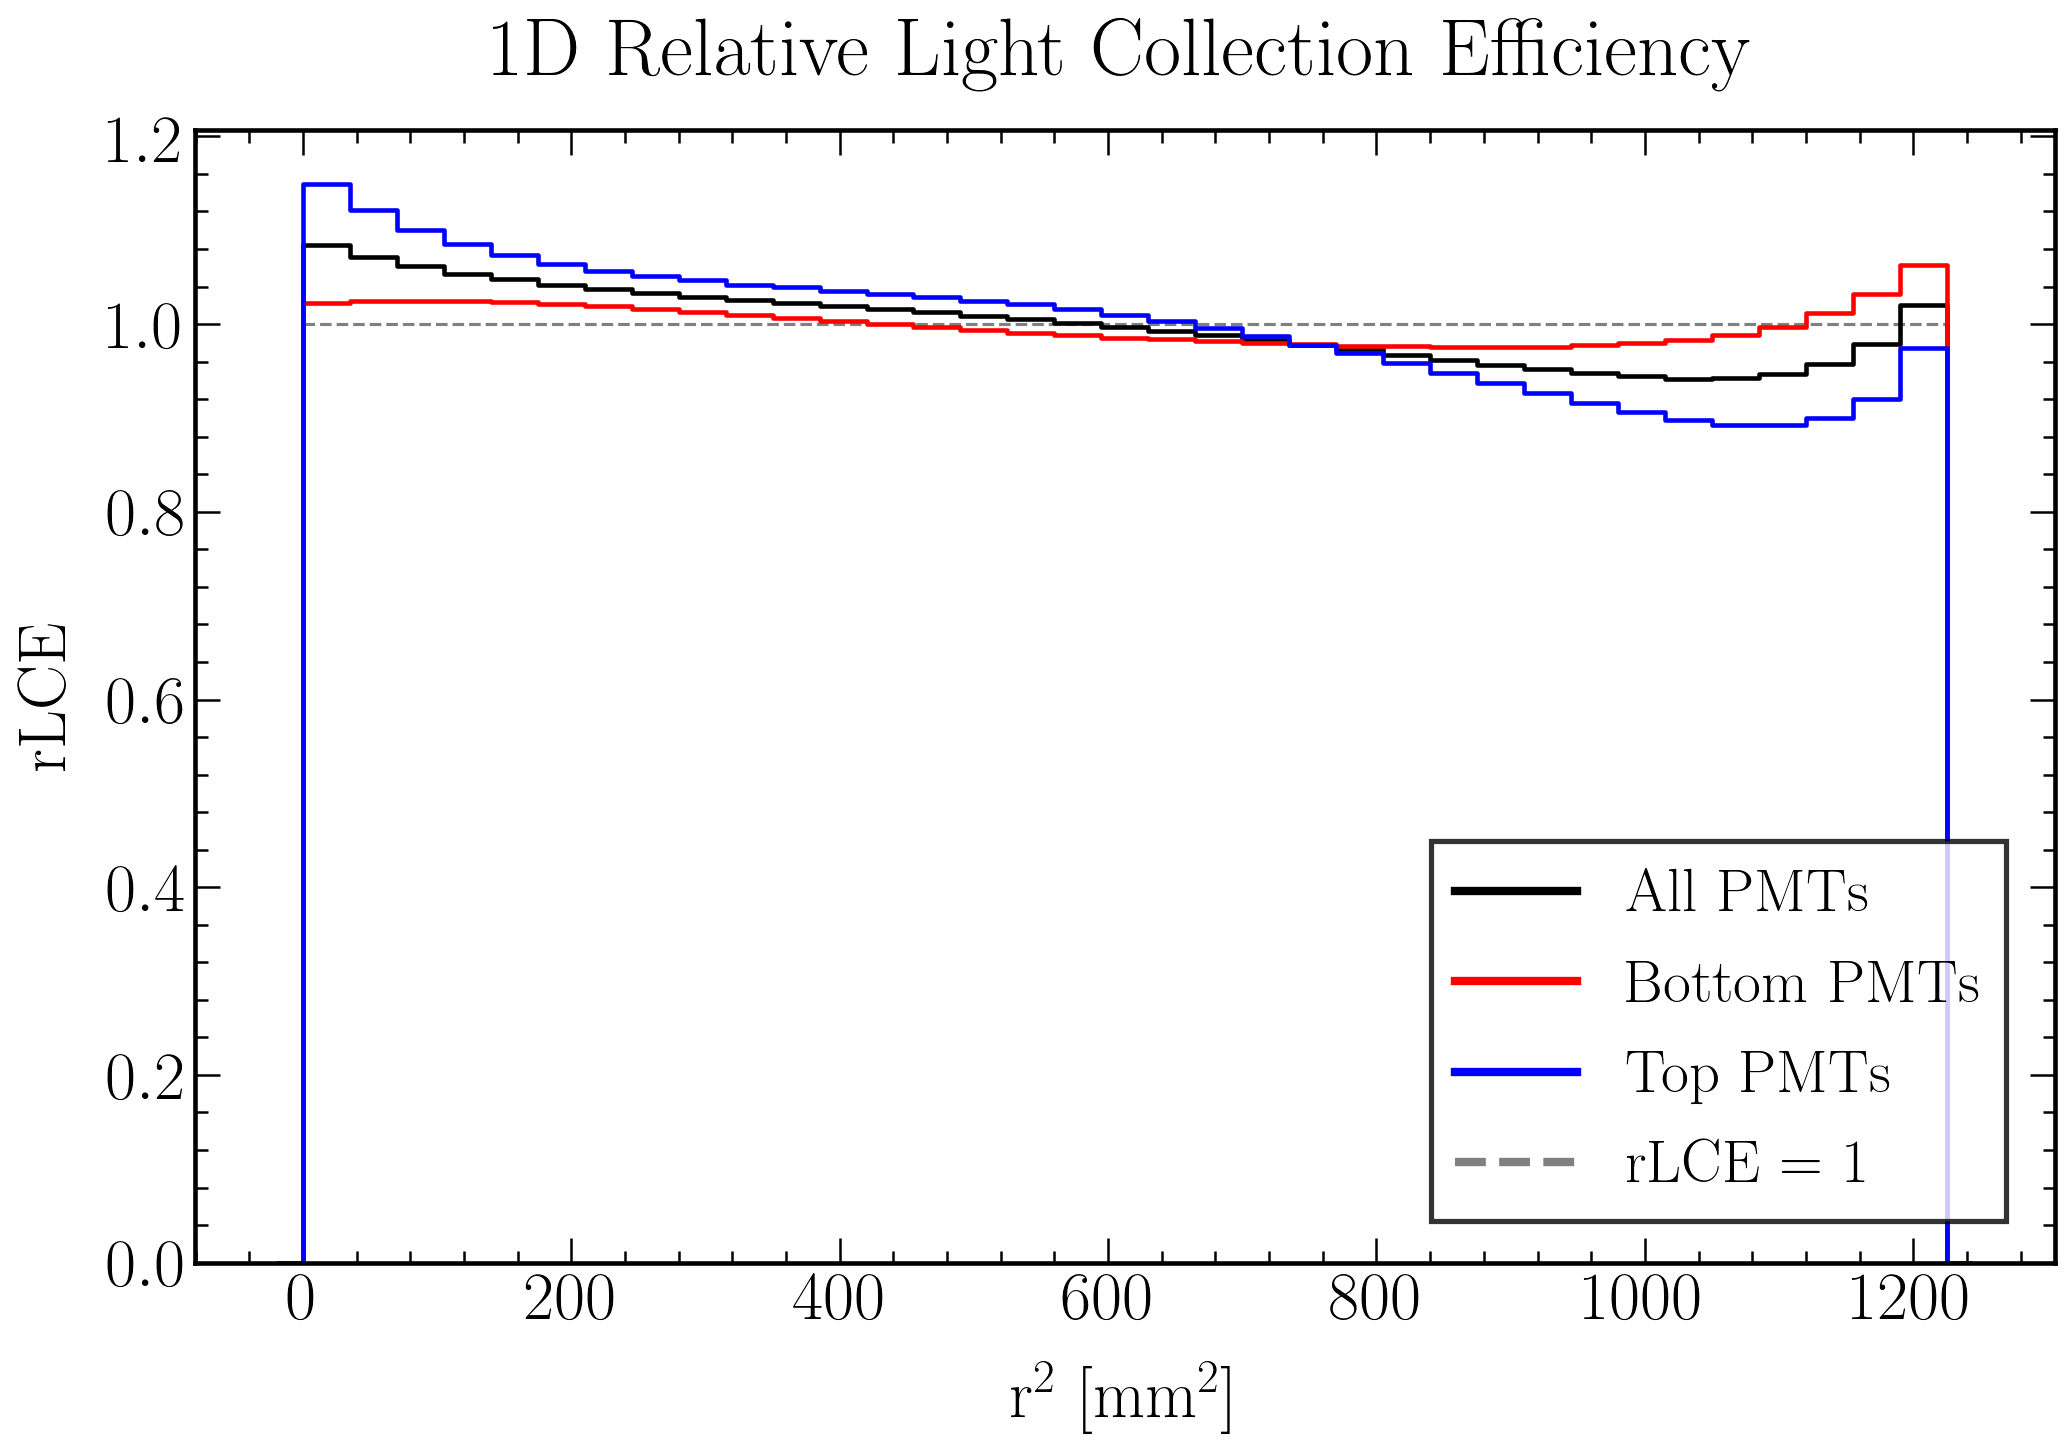

In [35]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hlines(1, 0, 35**2, colors='gray', linestyles='dashed', label = 'rLCE = 1')

bns = np.concatenate((np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][0]-LCE_r2_hist['binscenter_r2'].loc['all'][1]]), LCE_r2_hist['binscenter_r2'].loc['all'], np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][-1]-LCE_r2_hist['binscenter_r2'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_r2_hist['rLCE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_r2_hist['rLCE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_r2_hist['rLCE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('rLCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Relative Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=4, bbox_to_anchor=(0.99,0.01), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0,0.45)
#plt.ylim(0,0.12)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')
plt.ylim(bottom = 0)

fig.savefig(filenameprefix+"_rLCE_r2_comparison.png")
plt.show()

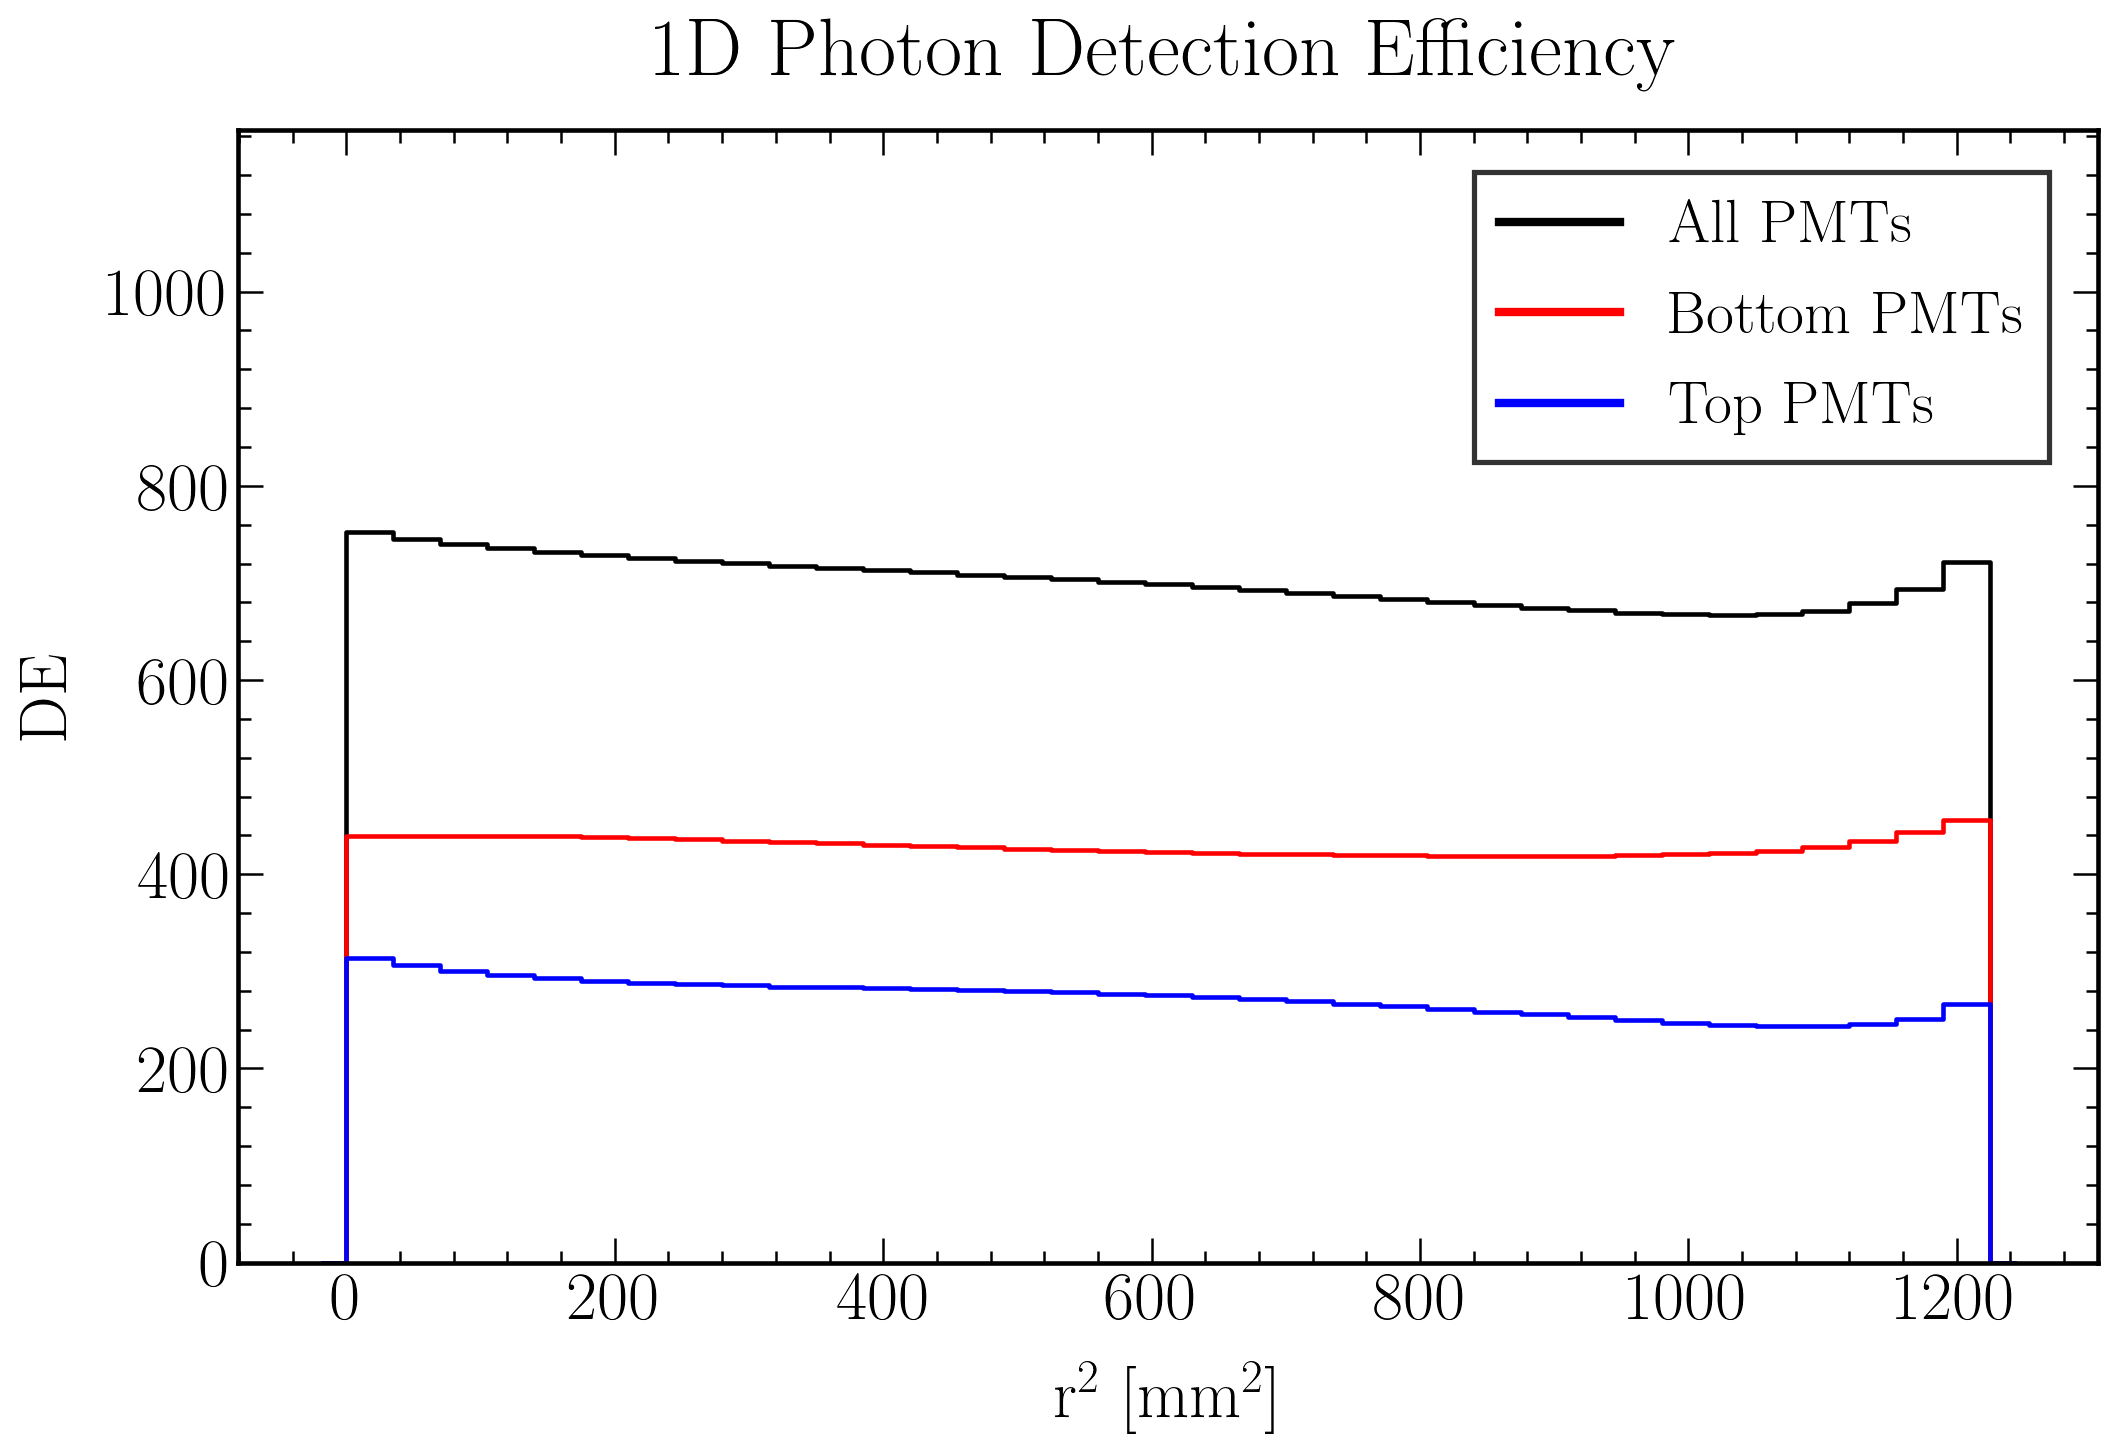

In [36]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 70

# Data plot
'''
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')
'''

bns = np.concatenate((np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][0]-LCE_r2_hist['binscenter_r2'].loc['all'][1]]), LCE_r2_hist['binscenter_r2'].loc['all'], np.array([2*LCE_r2_hist['binscenter_r2'].loc['all'][-1]-LCE_r2_hist['binscenter_r2'].loc['all'][-2]])))
ns = np.concatenate((np.array([0]), LCE_r2_hist['DE'].loc['all'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'All PMTs', color = 'k')
ns = np.concatenate((np.array([0]), LCE_r2_hist['DE'].loc['bottom'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Bottom PMTs', color = 'r')
ns = np.concatenate((np.array([0]), LCE_r2_hist['DE'].loc['top'], np.array([0])))
plt.step(bns, ns, where='mid', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('DE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Photon Detection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0,0.42)
plt.ylim(0,1.55*LCE_r2_hist['DE'].loc['all'].max())
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_r2_comparison.png")
plt.show()

### 2D Light Collection Efficiency

#### Histogram in r² vs z

n_total  \
all     [[789.0, 844.0, 851.0, 771.0, 862.0, 797.0, 80...   
top     [[789.0, 844.0, 851.0, 771.0, 862.0, 797.0, 80...   
bottom  [[789.0, 844.0, 851.0, 771.0, 862.0, 797.0, 80...   

                                                n_total.T  \
all     [[789.0, 816.0, 804.0, 836.0, 859.0, 803.0, 85...   
top     [[789.0, 816.0, 804.0, 836.0, 859.0, 803.0, 85...   
bottom  [[789.0, 816.0, 804.0, 836.0, 859.0, 803.0, 85...   

                                                   n_hits  \
all     [[2311812.0, 2472030.0, 2492108.0, 2255408.0, ...   
top     [[1154745.0, 1235620.0, 1247089.0, 1130787.0, ...   
bottom  [[1157067.0, 1236410.0, 1245019.0, 1124621.0, ...   

                                                 n_hits.T  \
all     [[2311812.0, 2367694.0, 2317898.0, 2394315.0, ...   
top     [[1154745.0, 1168935.0, 1135955.0, 1167763.0, ...   
bottom  [[1157067.0, 1198759.0, 1181943.0, 1226552.0, ...   

                                                   xedges  \
all     [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   
top     [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   
bottom  [0.0, 35.0, 70.0, 105.0, 140.0, 175.0, 210.0, ...   

                                                   yedges  \
all     [2.5, 2.5714285714285716, 2.642857142857143, 2...   
top     [2.5, 2.5714285714285716, 2.642857142857143, 2...   
bottom  [2.5, 2.5714285714285716, 2.642857142857143, 2...   

                                             xedgescenter  \
all     [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   
top     [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   
bottom  [17.5, 52.5, 87.5, 122.5, 157.5, 192.5, 227.5,...   

                                             yedgescenter  \
all     [2.5357142857142856, 2.607142857142857, 2.6785...   
top     [2.5357142857142856, 2.607142857142857, 2.6785...   
bottom  [2.5357142857142856, 2.607142857142857, 2.6785...   

                                                      LCE  \
all     [[2930.0532319391637, 2928.945497630332, 2928....   
top     [[1463.555133079848, 1464.004739336493, 1465.4...   
bottom  [[1466.4980988593156, 1464.9407582938388, 1463...   

                                                    LCE.T  \
all     [[2930.0532319391637, 2901.5857843137255, 2882...   
top     [[1463.555133079848, 1432.5183823529412, 1412....   
bottom  [[1466.4980988593156, 1469.0674019607843, 1470...   

                                                     rLCE  \
all     [[1.0895772487065745, 1.0891653237328716, 1.08...   
top     [[1.1264587080987403, 1.1268047578453924, 1.12...   
bottom  [[1.0551014279030408, 1.0539809680431584, 1.05...   

                                                   rLCE.T  \
all     [[1.0895772487065745, 1.078991269269984, 1.072...   
top     [[1.1264587080987403, 1.1025705624886448, 1.08...   
bottom  [[1.0551014279030408, 1.0569499644767903, 1.05...   

                                                       DE  \
all     [[760.1278659695818, 759.7414543838862, 759.44...   
top     [[307.34657794676804, 307.4409952606635, 307.7...   
bottom  [[452.7812880228137, 452.3004591232227, 451.70...   

                                                     DE.T  \
all     [[760.1278659695818, 754.4034206495098, 750.59...   
top     [[307.34657794676804, 300.82886029411765, 296....   
bottom  [[452.7812880228137, 453.5745603553922, 453.88...   

                                                       LY  \
all     [[30800.890919772668, 30785.233263167796, 3077...   
top     [[12453.889464805696, 12457.715317687069, 1246...   
bottom  [[18347.001454966972, 18327.517945480726, 1830...   

                                                     LY.T  \
all     [[30800.890919772668, 30568.93255622177, 30414...   
top     [[12453.889464805696, 12189.787174319223, 1202...   
bottom  [[18347.001454966972, 18379.14538190255, 18391...   

                                                      LY0  \
all     [[51906.28091720407, 51879.89431935031, 51859....   
top     

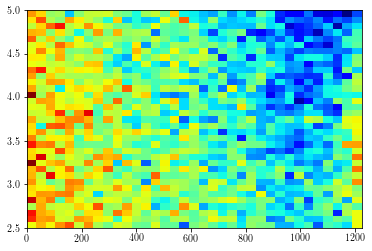

In [37]:
if b_preprocessed == False:
    range_r2 = [0, 35**2]
    range_z = [round(np.min(_chunk_collect.zp_pri),2), round(np.max(_chunk_collect.zp_pri),2)]

    hist_r2z_total, xedges_r2z_total, yedges_r2z_total, kwargs_r2z_total = plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = None, range = [range_r2, range_z], cmap = 'jet')
    xedgescenter_r2z_total = (xedges_r2z_total[:-1]+xedges_r2z_total[1:])/2
    yedgescenter_r2z_total = (yedges_r2z_total[:-1]+yedges_r2z_total[1:])/2
    histT_r2z_total = hist_r2z_total.T  # Let each row list bins with common y range.

    hist_r2z_hits_t, xedges_r2z_hits_t, yedges_r2z_hits_t, kwargs_r2z_hits_t = plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.ntpmthits, range = [range_r2, range_z], cmap = 'jet')
    xedgescenter_r2z_hits_t = (xedges_r2z_hits_t[:-1]+xedges_r2z_hits_t[1:])/2
    yedgescenter_r2z_hits_t = (yedges_r2z_hits_t[:-1]+yedges_r2z_hits_t[1:])/2
    histT_r2z_hits_t = hist_r2z_hits_t.T  # Let each row list bins with common y range.

    hist_r2z_hits_b, xedges_r2z_hits_b, yedges_r2z_hits_b, kwargs_r2z_hits_b = plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.nbpmthits, range = [range_r2, range_z], cmap = 'jet')
    xedgescenter_r2z_hits_b = (xedges_r2z_hits_b[:-1]+xedges_r2z_hits_b[1:])/2
    yedgescenter_r2z_hits_b = (yedges_r2z_hits_b[:-1]+yedges_r2z_hits_b[1:])/2
    histT_r2z_hits_b = hist_r2z_hits_b.T  # Let each row list bins with common y range.

    hist_r2z_hits_a, xedges_r2z_hits_a, yedges_r2z_hits_a, kwargs_r2z_hits_a = plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.napmthits, range = [range_r2, range_z], cmap = 'jet')
    xedgescenter_r2z_hits_a = (xedges_r2z_hits_a[:-1]+xedges_r2z_hits_a[1:])/2
    yedgescenter_r2z_hits_a = (yedges_r2z_hits_a[:-1]+yedges_r2z_hits_a[1:])/2
    histT_r2z_hits_a = hist_r2z_hits_a.T  # Let each row list bins with common y range.


    hist_r2z_LCE_t = hist_r2z_hits_t / hist_r2z_total
    histT_r2z_LCE_t = histT_r2z_hits_t / histT_r2z_total

    hist_r2z_LCE_b = hist_r2z_hits_b / hist_r2z_total
    histT_r2z_LCE_b = histT_r2z_hits_b / histT_r2z_total

    hist_r2z_LCE_a = hist_r2z_hits_a / hist_r2z_total
    histT_r2z_LCE_a = histT_r2z_hits_a / histT_r2z_total


    hist_r2z_rLCE_t = hist_r2z_LCE_t / hist_r2z_LCE_t.mean()
    histT_r2z_rLCE_t = histT_r2z_LCE_t / histT_r2z_LCE_t.mean()

    hist_r2z_rLCE_b = hist_r2z_LCE_b / hist_r2z_LCE_b.mean()
    histT_r2z_rLCE_b = histT_r2z_LCE_b / histT_r2z_LCE_b.mean()

    hist_r2z_rLCE_a = hist_r2z_LCE_a / hist_r2z_LCE_a.mean()
    histT_r2z_rLCE_a = histT_r2z_LCE_a / histT_r2z_LCE_a.mean()


    hist_r2z_DE_t = hist_r2z_LCE_t * QE_Top * CE_Top
    histT_r2z_DE_t = histT_r2z_LCE_t * QE_Top * CE_Top

    hist_r2z_DE_b = hist_r2z_LCE_b * QE_Bottom * CE_Bottom
    histT_r2z_DE_b = histT_r2z_LCE_b * QE_Bottom * CE_Bottom

    hist_r2z_DE_a = hist_r2z_DE_t + hist_r2z_DE_b
    histT_r2z_DE_a = histT_r2z_DE_t + histT_r2z_DE_b


    hist_r2z_LY_t = hist_r2z_DE_t/W
    histT_r2z_LY_t = histT_r2z_DE_t/W

    hist_r2z_LY_b = hist_r2z_DE_b/W
    histT_r2z_LY_b = histT_r2z_DE_b/W

    hist_r2z_LY_a = hist_r2z_DE_a/W
    histT_r2z_LY_a = histT_r2z_DE_a/W


    hist_r2z_LY0_t = hist_r2z_DE_t/W0
    histT_r2z_LY0_t = histT_r2z_DE_t/W0

    hist_r2z_LY0_b = hist_r2z_DE_b/W0
    histT_r2z_LY0_b = histT_r2z_DE_b/W0

    hist_r2z_LY0_a = hist_r2z_DE_a/W0
    histT_r2z_LY0_a = histT_r2z_DE_a/W0


    LCE_r2z_hist = pd.DataFrame({'n_total' : [hist_r2z_total,hist_r2z_total,hist_r2z_total], 'n_total.T' : [histT_r2z_total,histT_r2z_total,histT_r2z_total], 'n_hits' : [hist_r2z_hits_a,hist_r2z_hits_t,hist_r2z_hits_b], 'n_hits.T' : [histT_r2z_hits_a,histT_r2z_hits_t,histT_r2z_hits_b], 'xedges' : [xedges_r2z_hits_a,xedges_r2z_hits_t,xedges_r2z_hits_b], 'yedges' : [yedges_r2z_hits_a,yedges_r2z_hits_t,yedges_r2z_hits_b], 'xedgescenter' : [xedgescenter_r2z_hits_a,xedgescenter_r2z_hits_t,xedgescenter_r2z_hits_b], 'yedgescenter' : [yedgescenter_r2z_hits_a,yedgescenter_r2z_hits_t,yedgescenter_r2z_hits_b], 'LCE' : [hist_r2z_LCE_a,hist_r2z_LCE_t,hist_r2z_LCE_b], 'LCE.T' : [histT_r2z_LCE_a,histT_r2z_LCE_t,histT_r2z_LCE_b], 'rLCE' : [hist_r2z_rLCE_a,hist_r2z_rLCE_t,hist_r2z_rLCE_b], 'rLCE.T' : [histT_r2z_rLCE_a,histT_r2z_rLCE_t,histT_r2z_rLCE_b], 'DE' : [hist_r2z_DE_a,hist_r2z_DE_t,hist_r2z_DE_b], 'DE.T' : [histT_r2z_DE_a,histT_r2z_DE_t,histT_r2z_DE_b], 'LY' : [hist_r2z_LY_a,hist_r2z_LY_t,hist_r2z_LY_b], 'LY.T' : [histT_r2z_LY_a,histT_r2z_LY_t,histT_r2z_LY_b], 'LY0' : [hist_r2z_LY0_a,hist_r2z_LY0_t,hist_r2z_LY0_b], 'LY0.T' : [histT_r2z_LY0_a,histT_r2z_LY0_t,histT_r2z_LY0_b]}, index=['all','top','bottom'])
    columns = ['n_total', 'n_total.T', 'n_hits', 'n_hits.T', 'xedges', 'yedges', 'xedgescenter', 'yedgescenter', 'LCE', 'LCE.T', 'rLCE', 'rLCE.T', 'DE', 'DE.T', 'LY', 'LY.T', 'LY0', 'LY0.T']
    LCE_r2z_hist.to_pickle(filenameprefix+"_LCE_r2z_hist.pkl")

if b_preprocessed == True:
    range_r2 = [0, 35**2]
    range_z = (LCE_z_hist['bins_z'].loc['all'].min(), LCE_z_hist['bins_z'].loc['all'].max()) 
    
LCE_r2z_hist

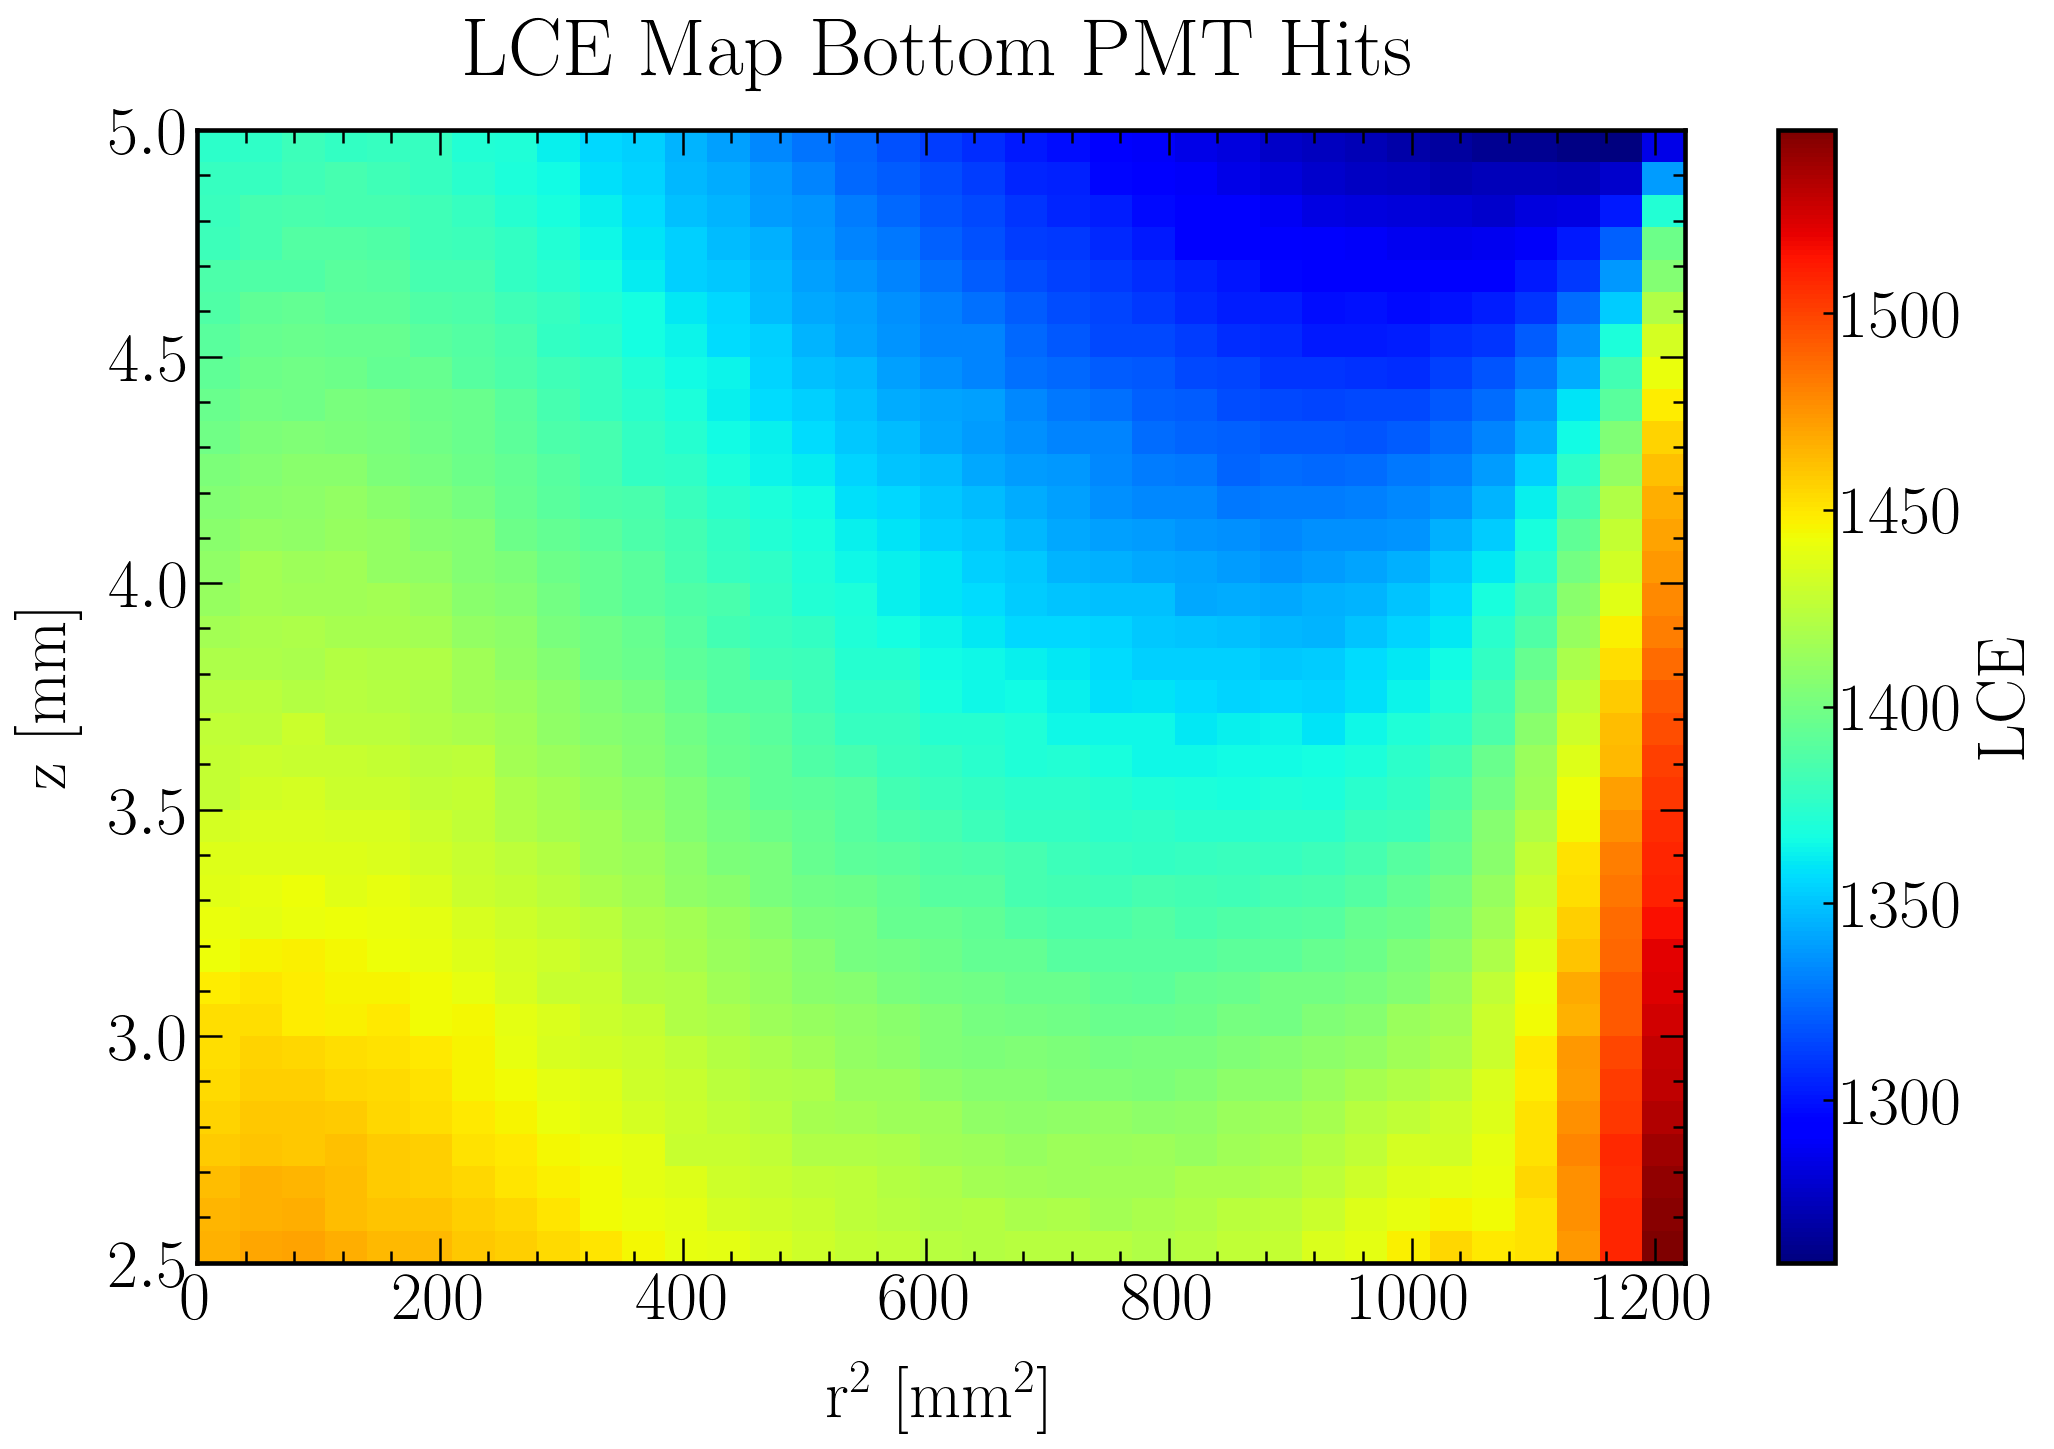

In [38]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwBottom*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LCE.T'].loc['bottom'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect((range_r2[1]-range_r2[0])/(range_z[1]-range_z[0]), adjustable='box')
plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Bottom.png")
plt.show()

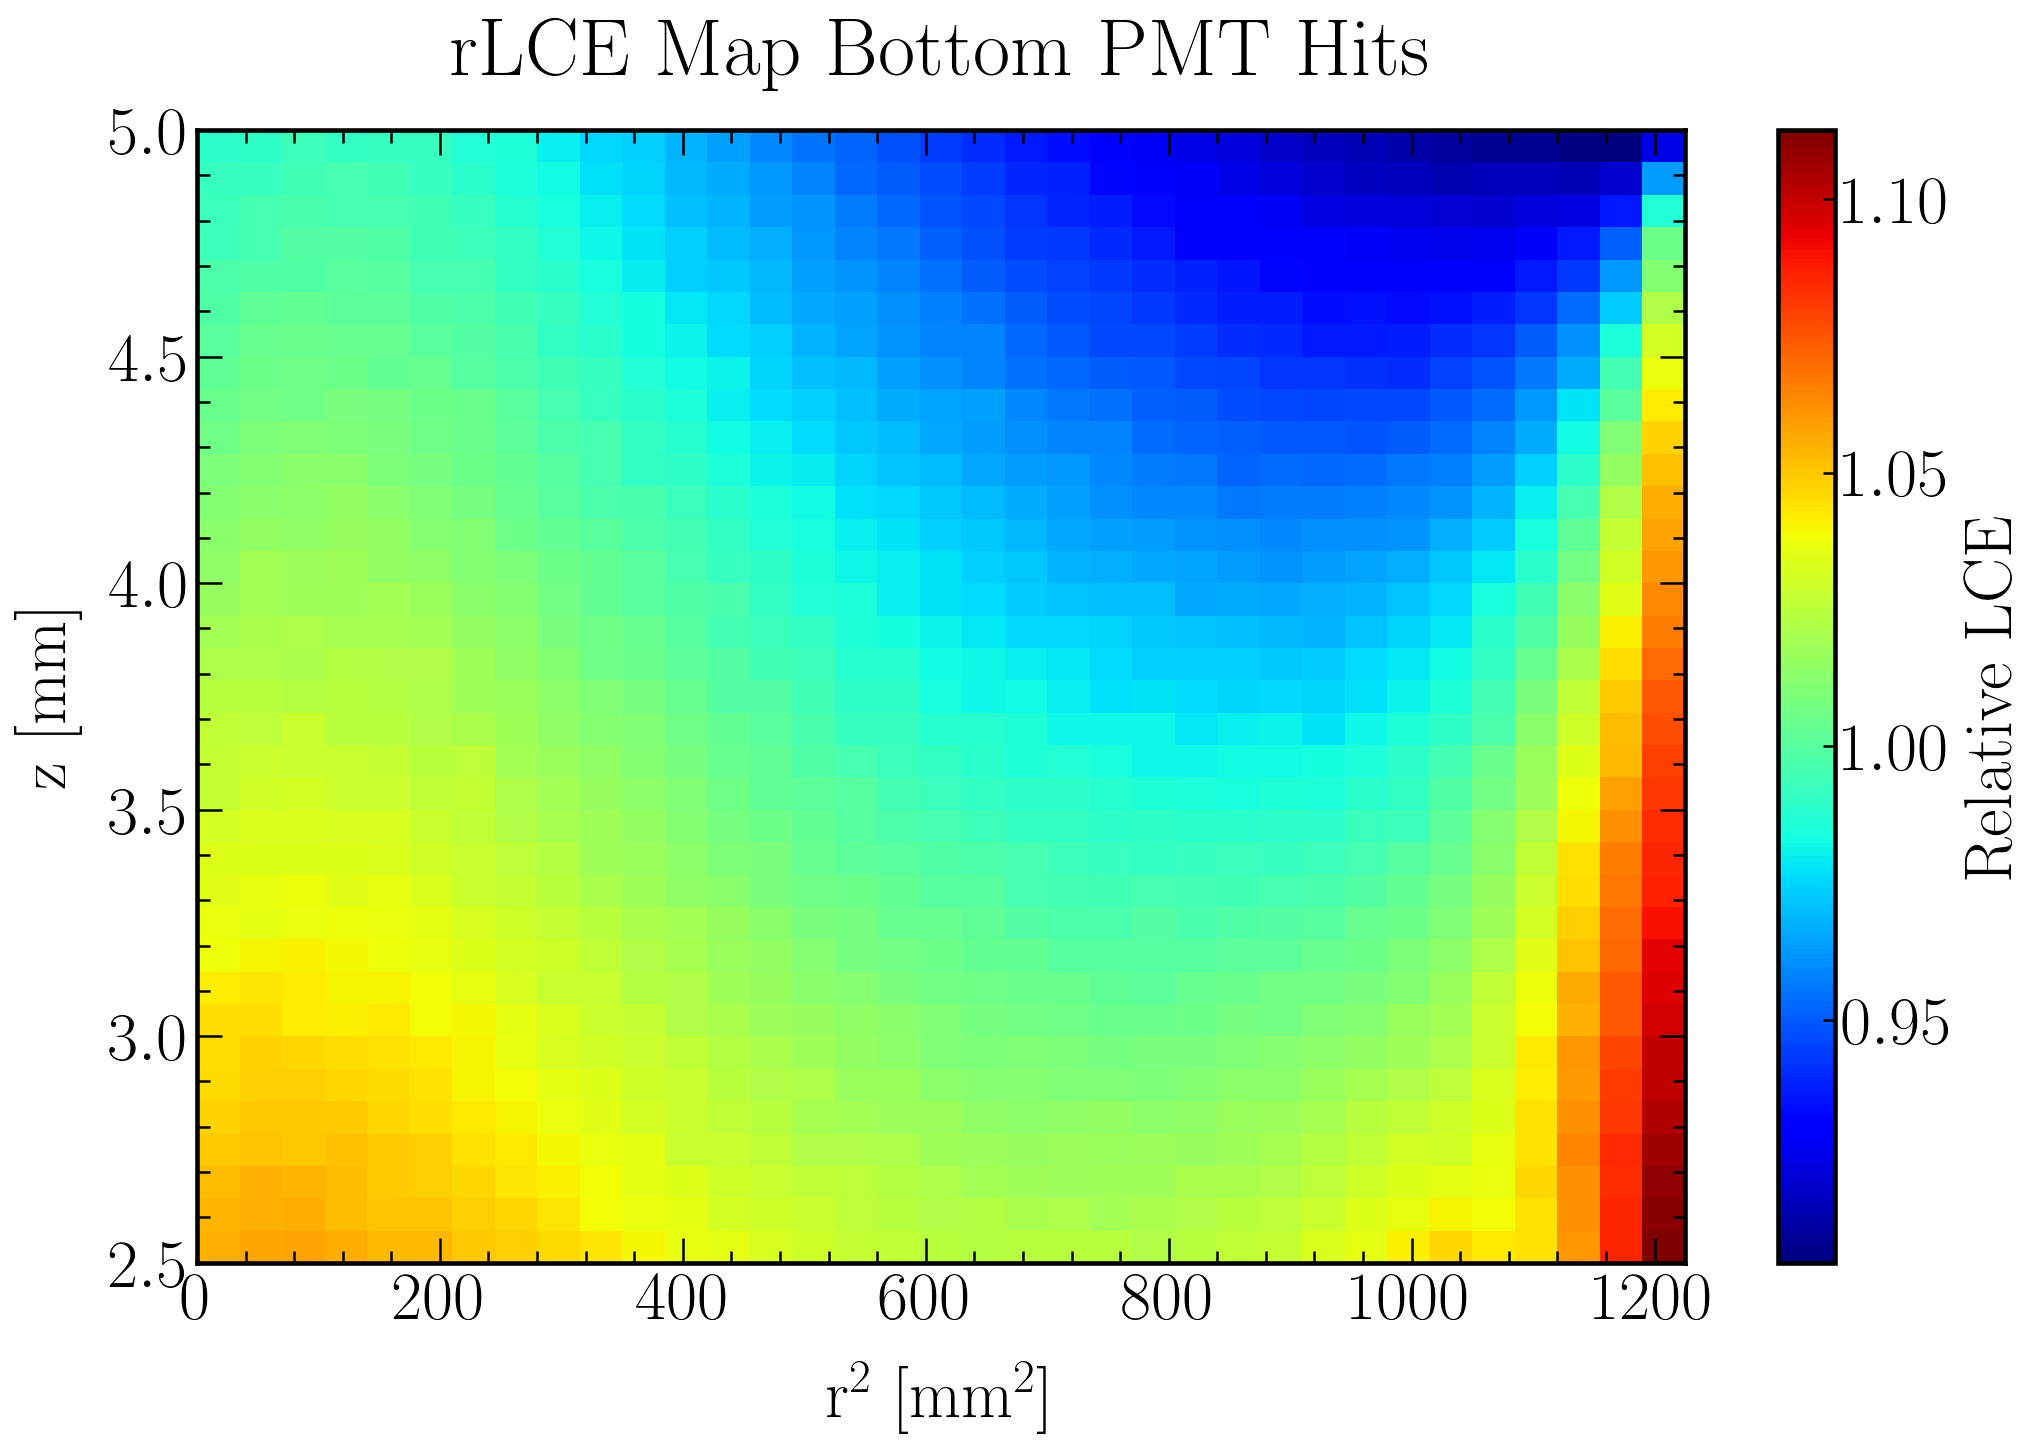

In [39]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.nbpmthits/(nbpmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['rLCE.T'].loc['bottom'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Bottom_rel.png")
plt.show()

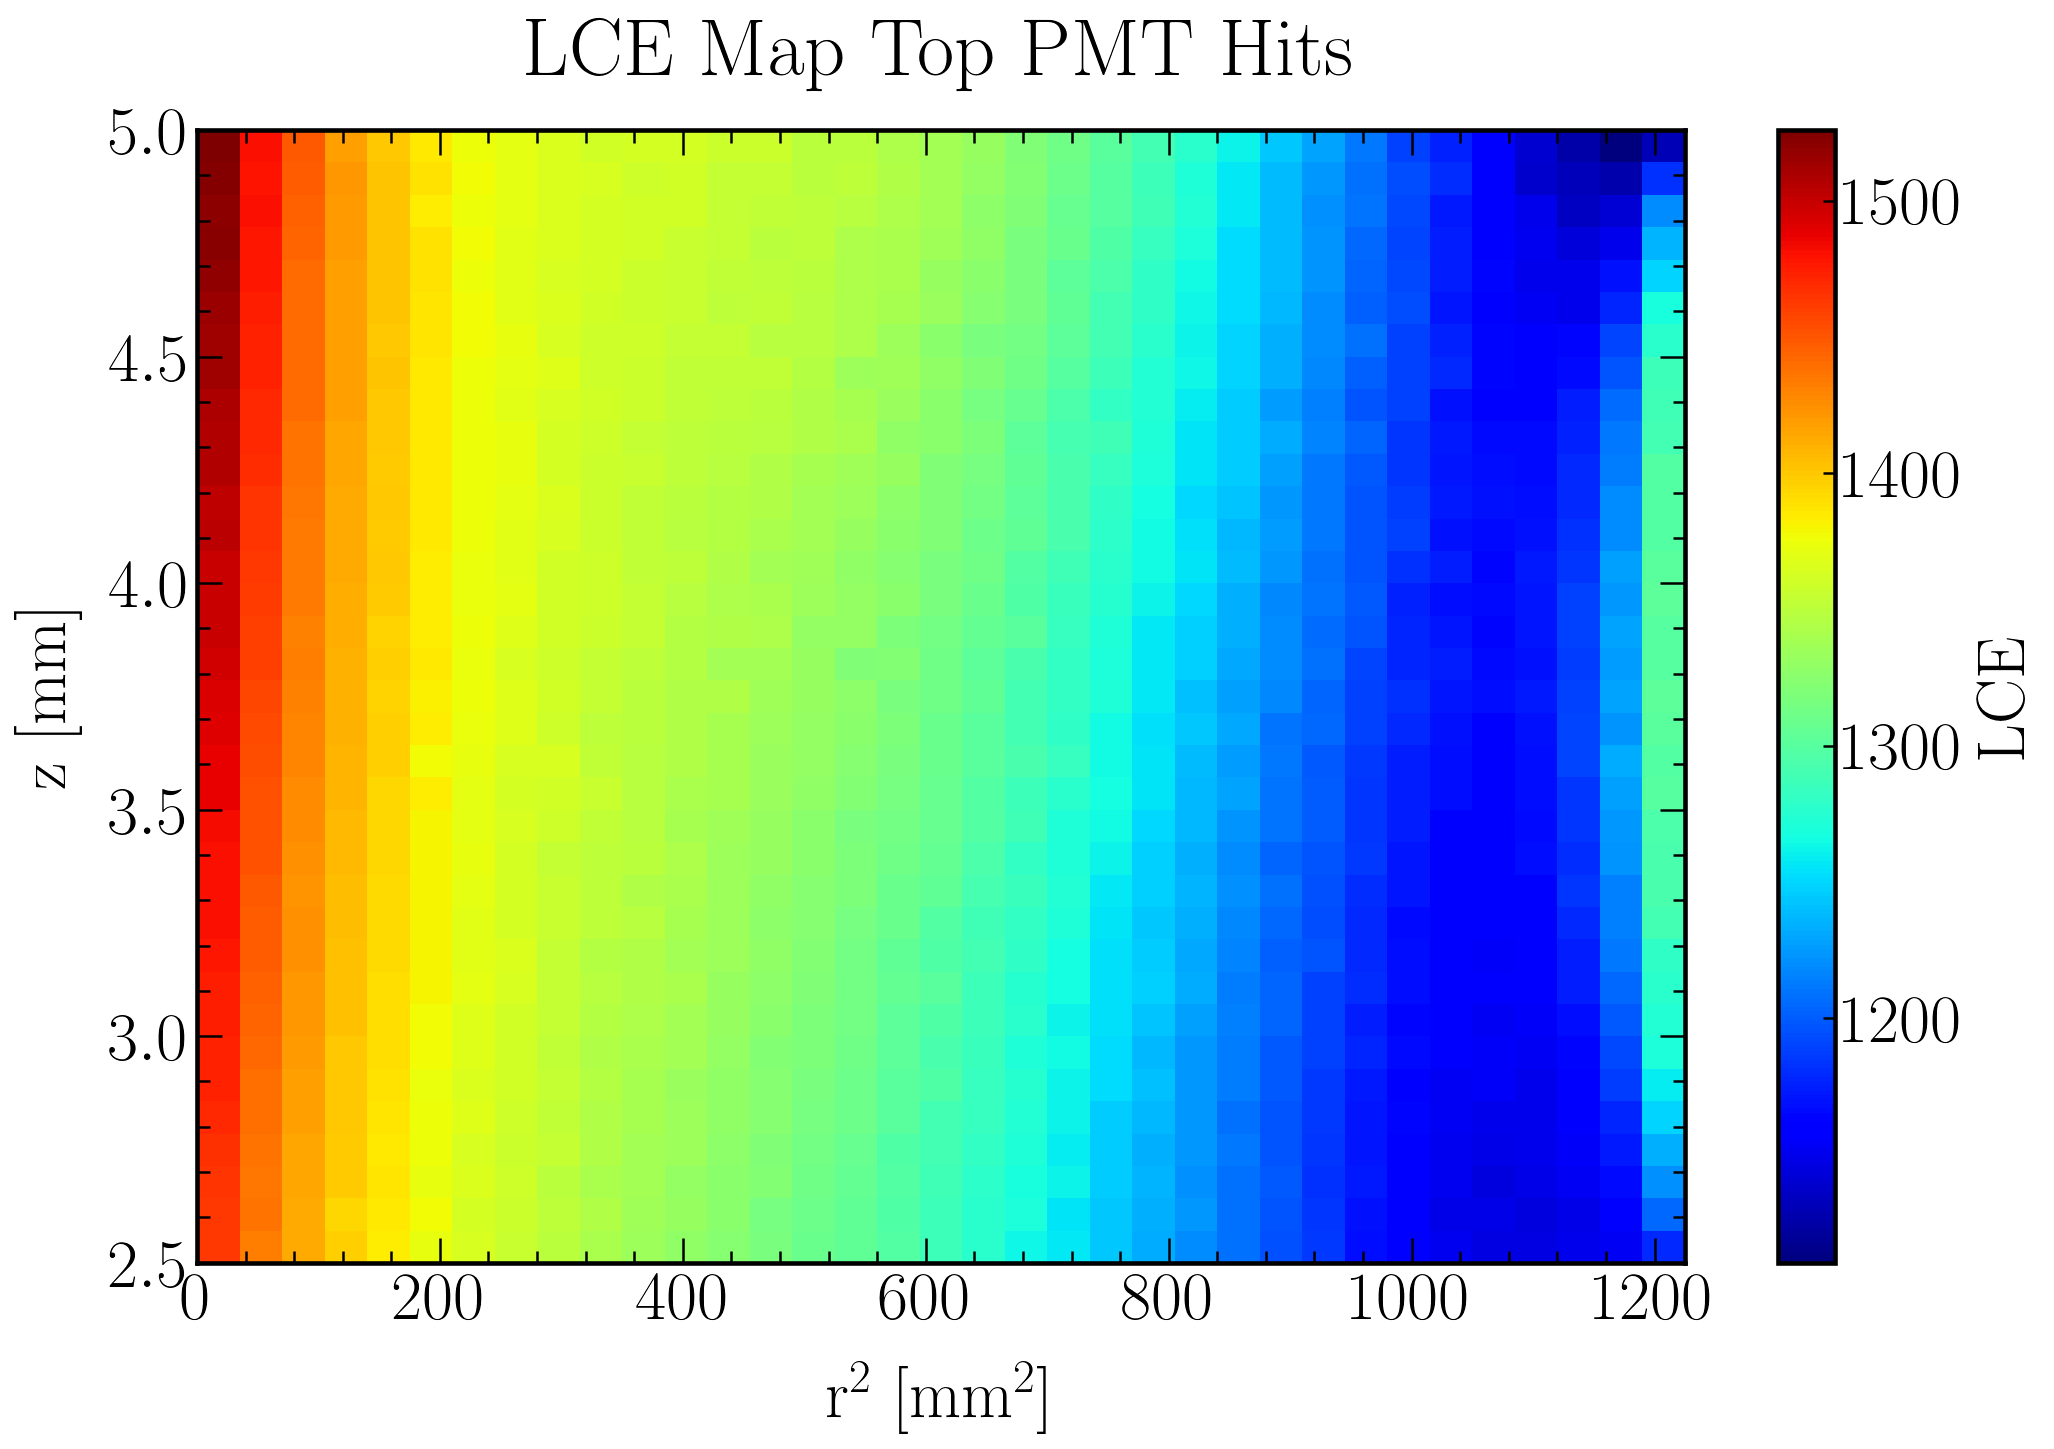

In [40]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwTop*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top.png")
plt.show()

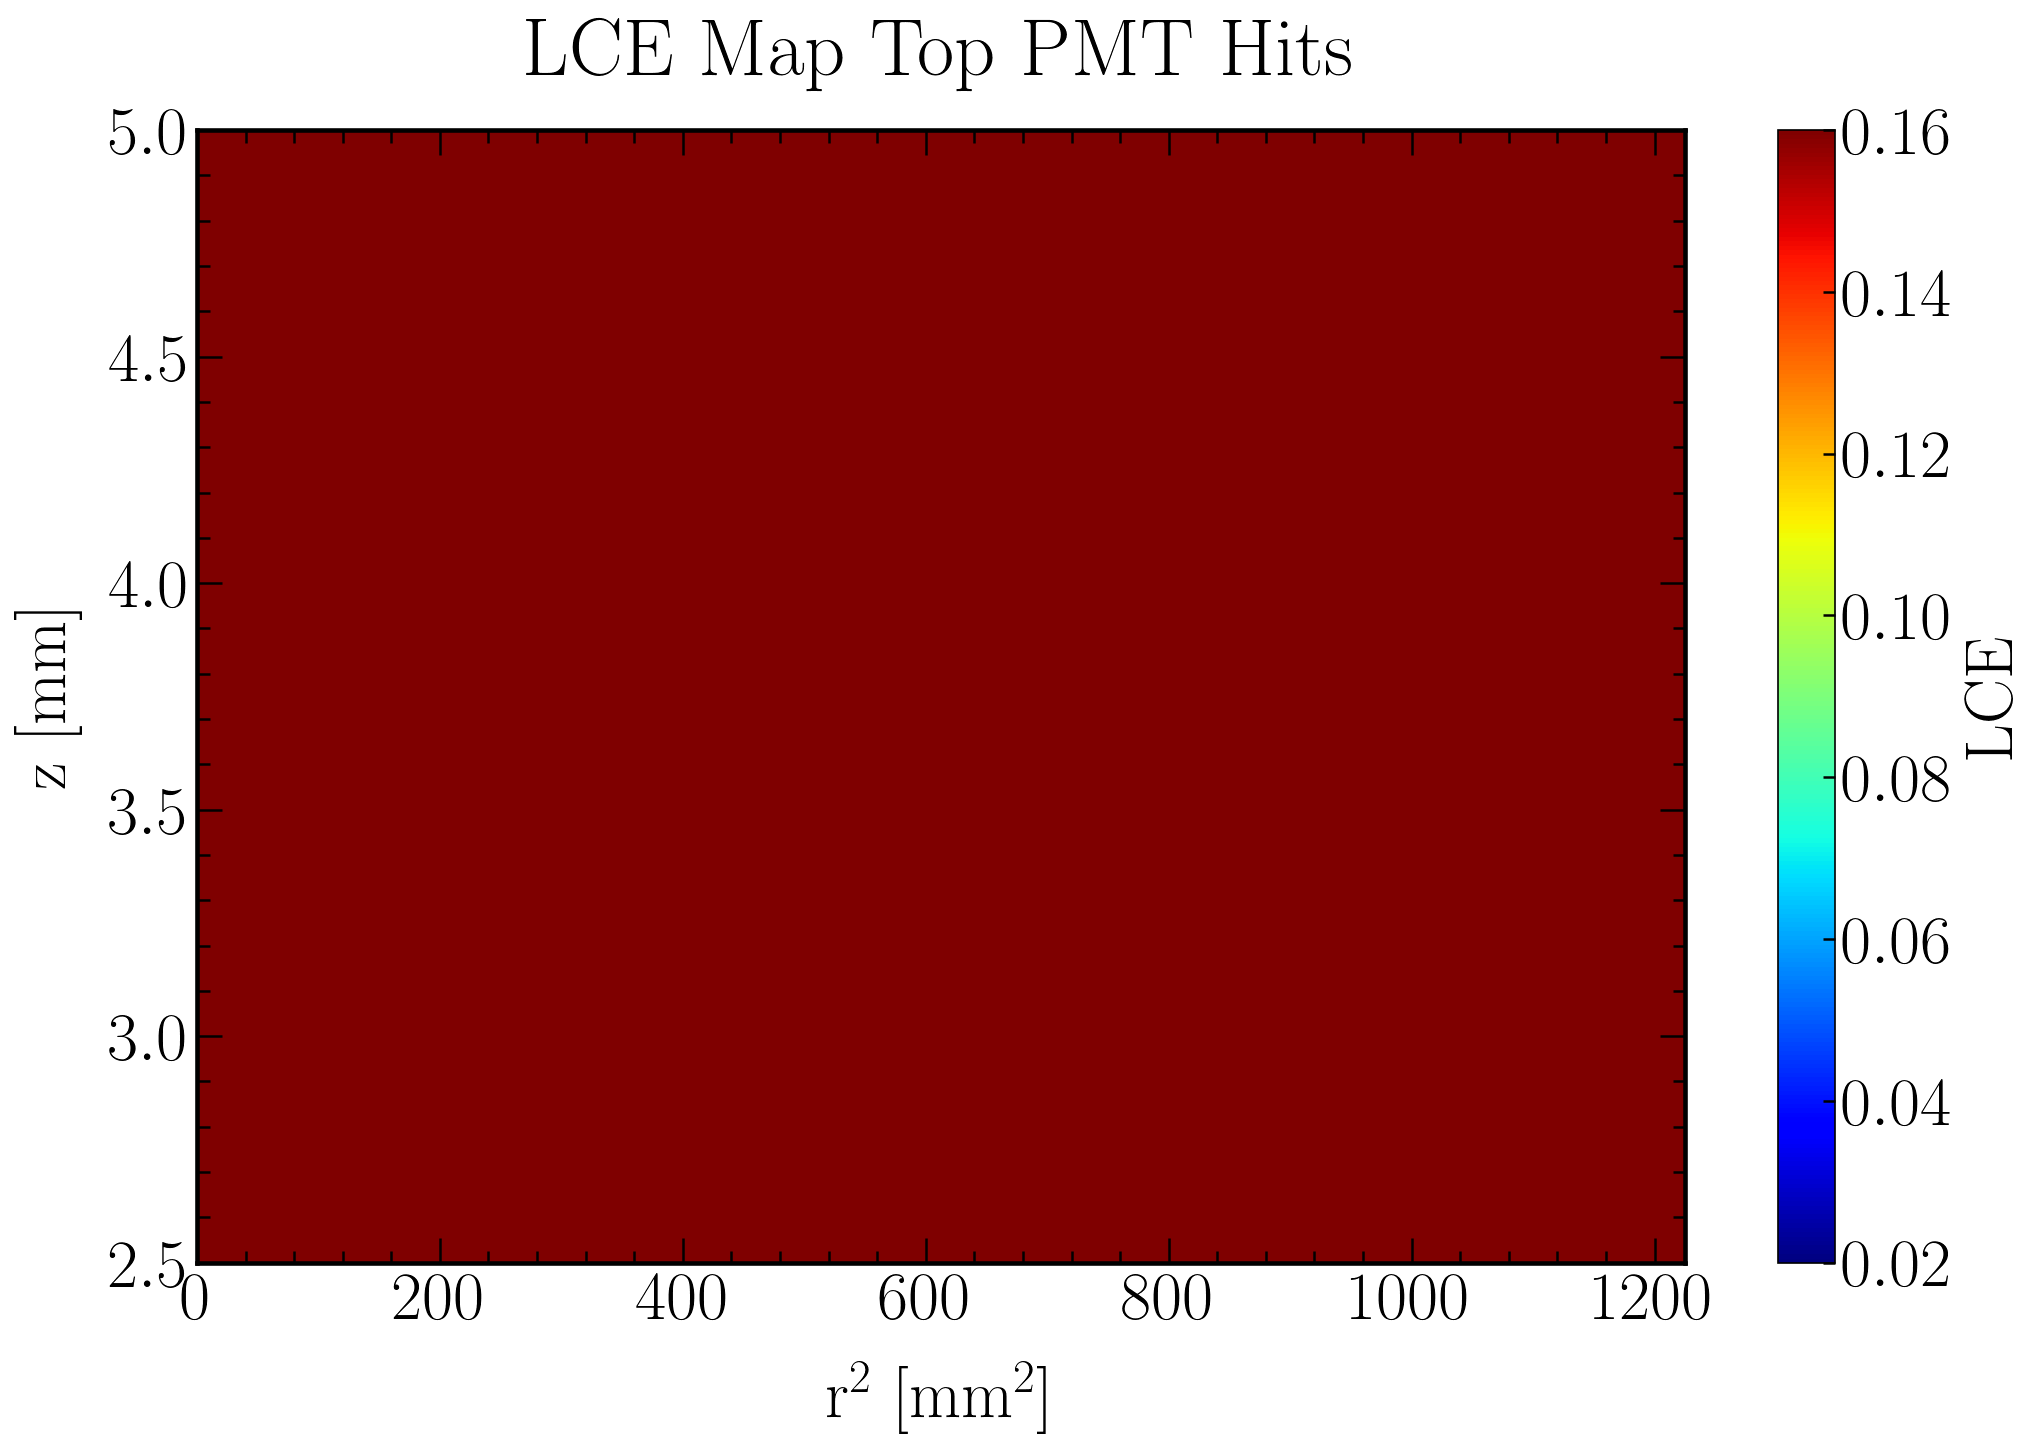

In [41]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwTop*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)
plt.clim(0.02, 0.16)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top_scaled.png")
plt.show()

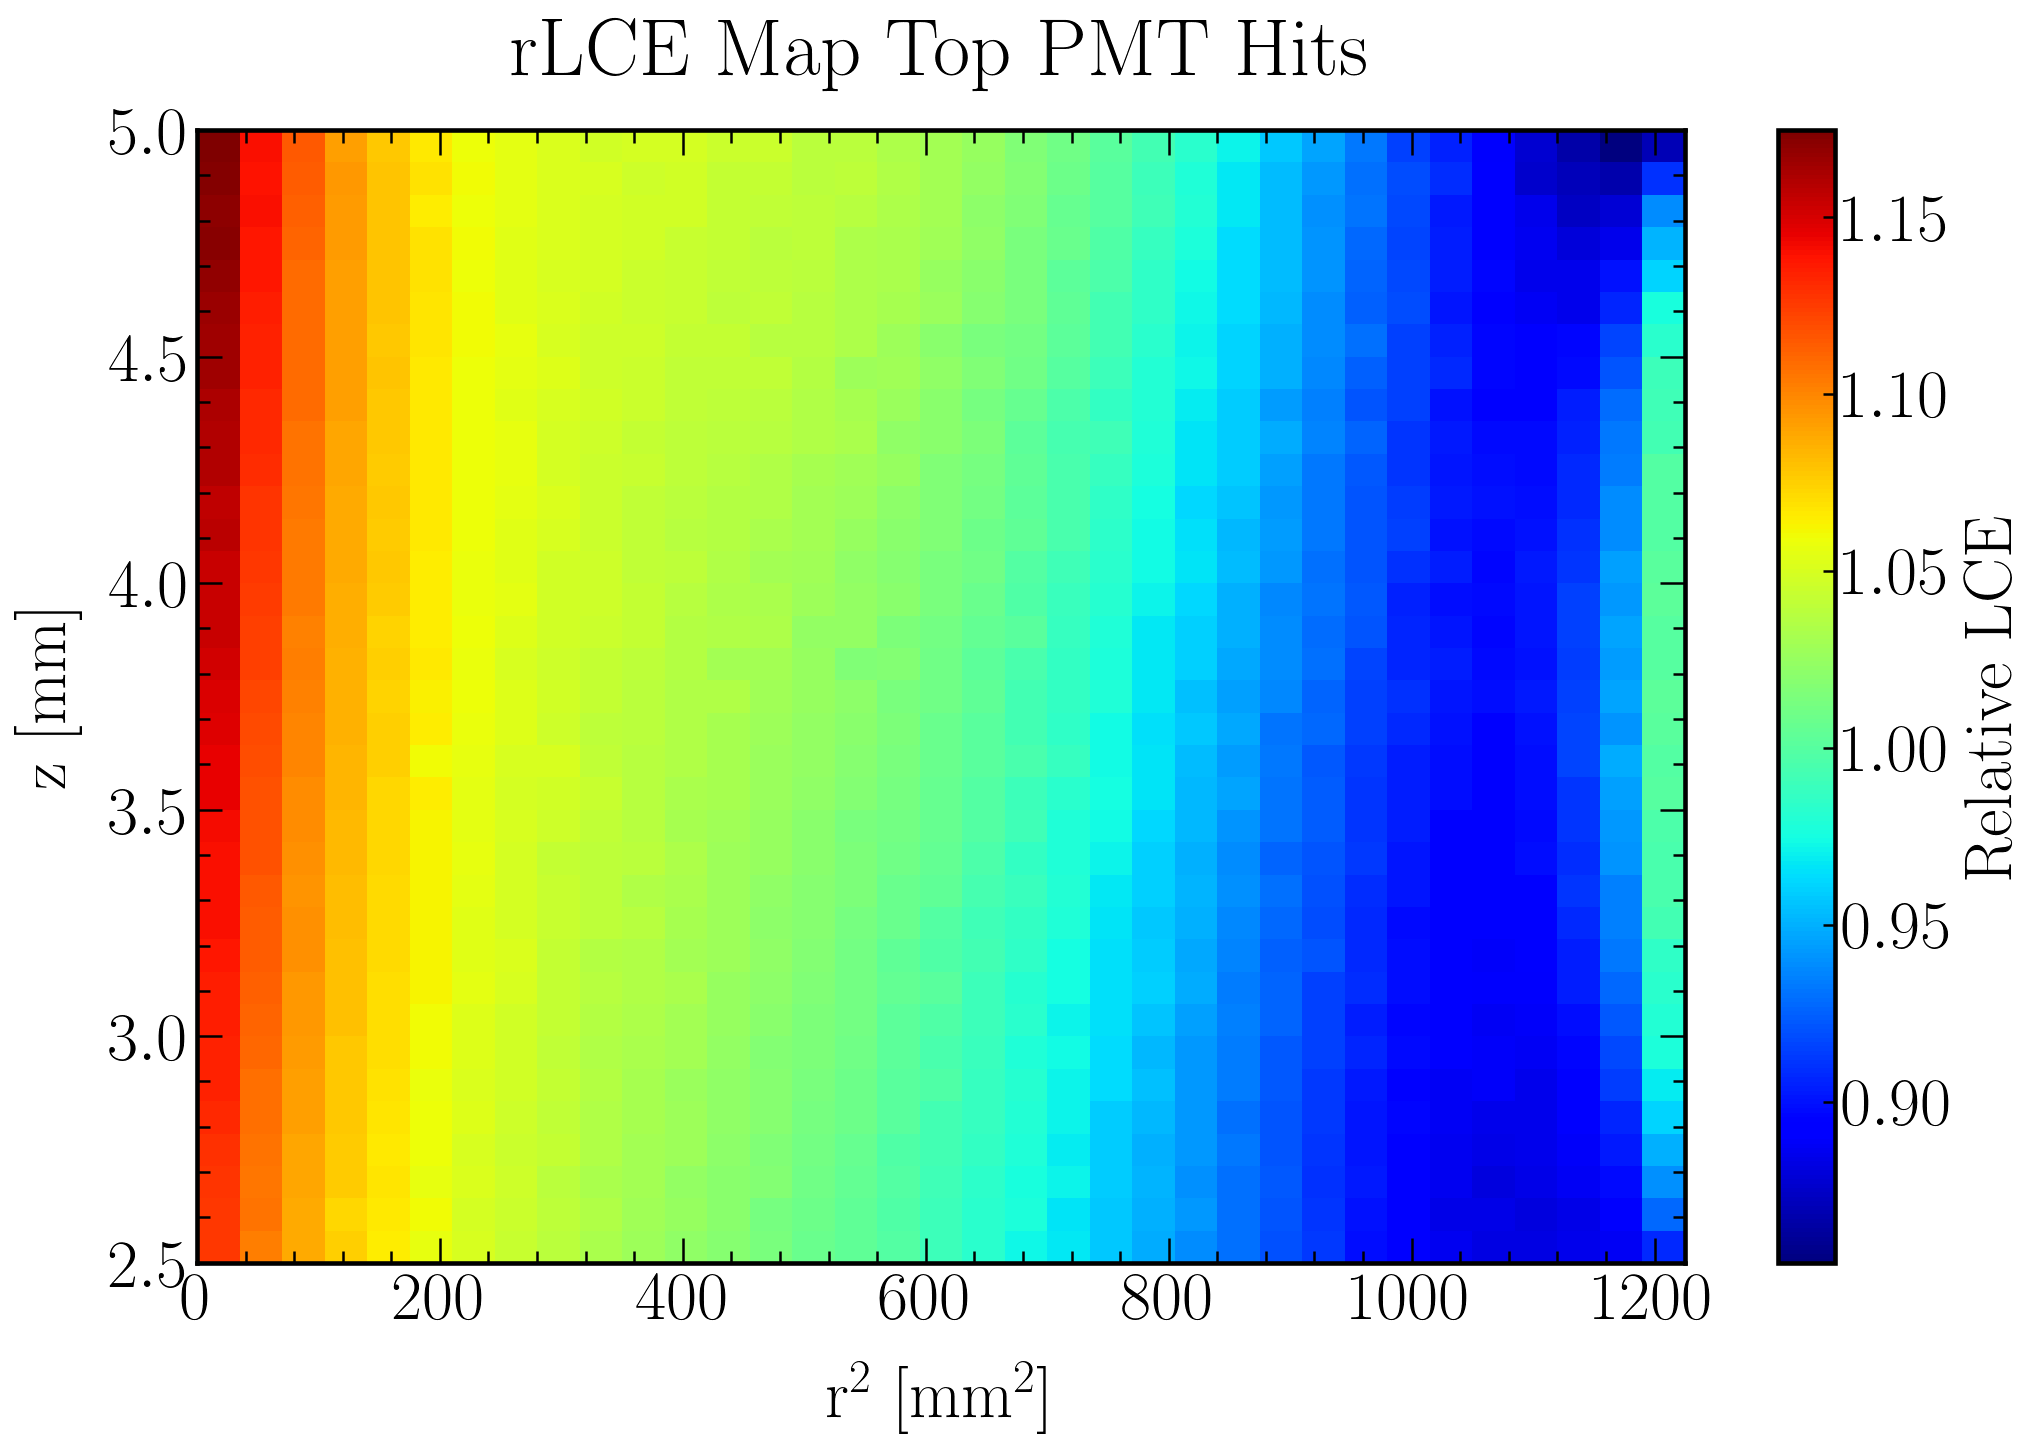

In [42]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.ntpmthits/(ntpmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['rLCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top_rel.png")
plt.show()

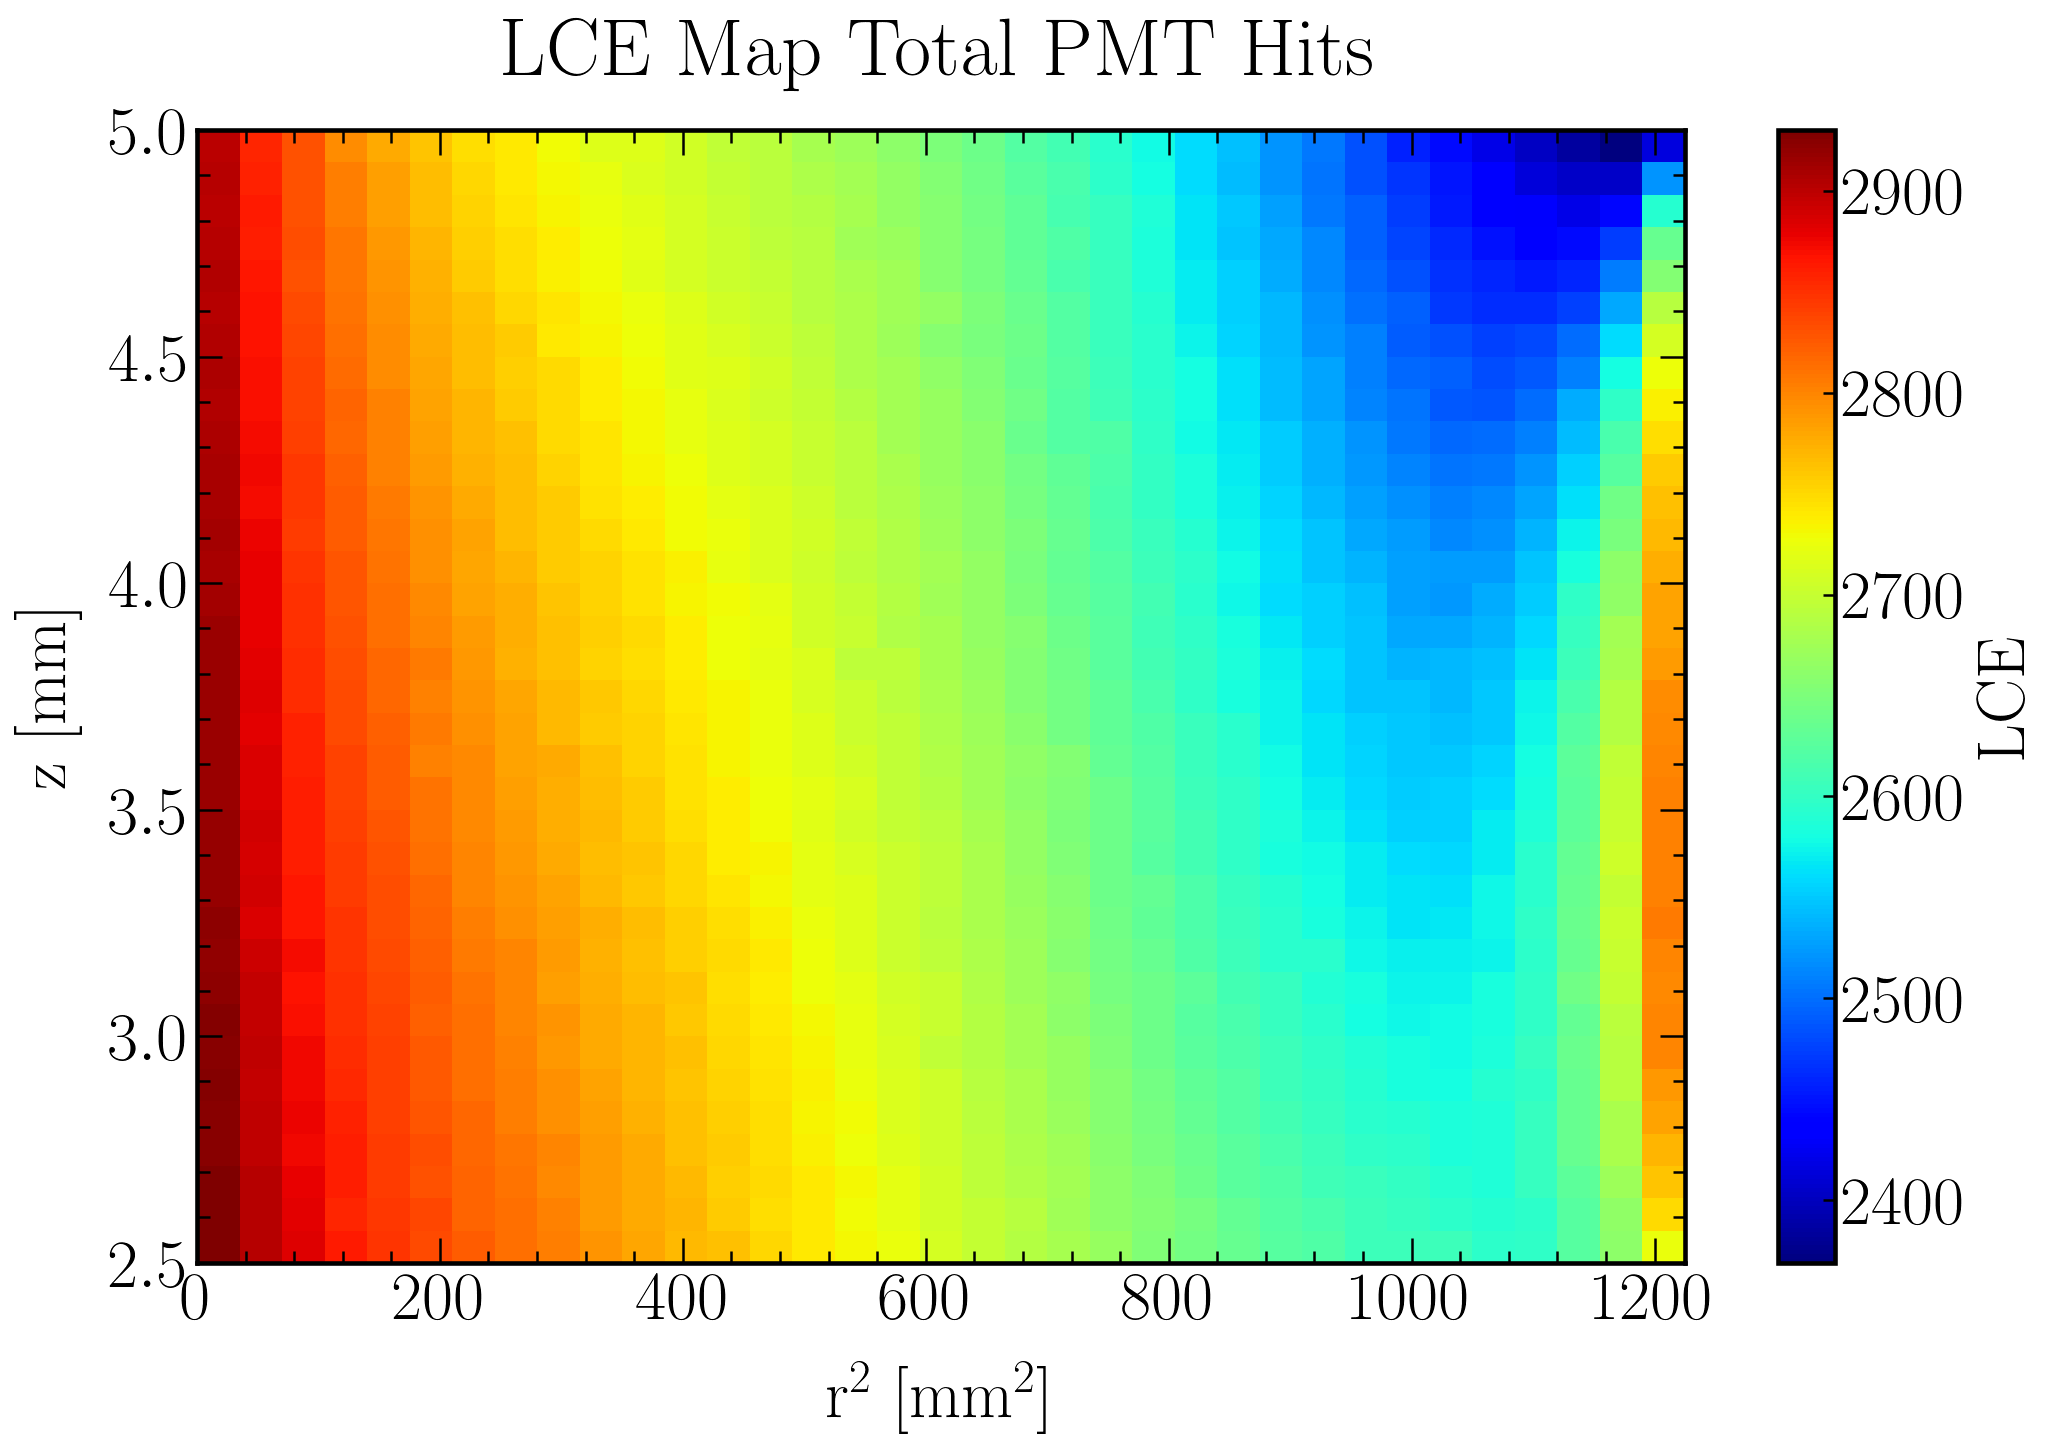

In [43]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LCE.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total.png")
plt.show()

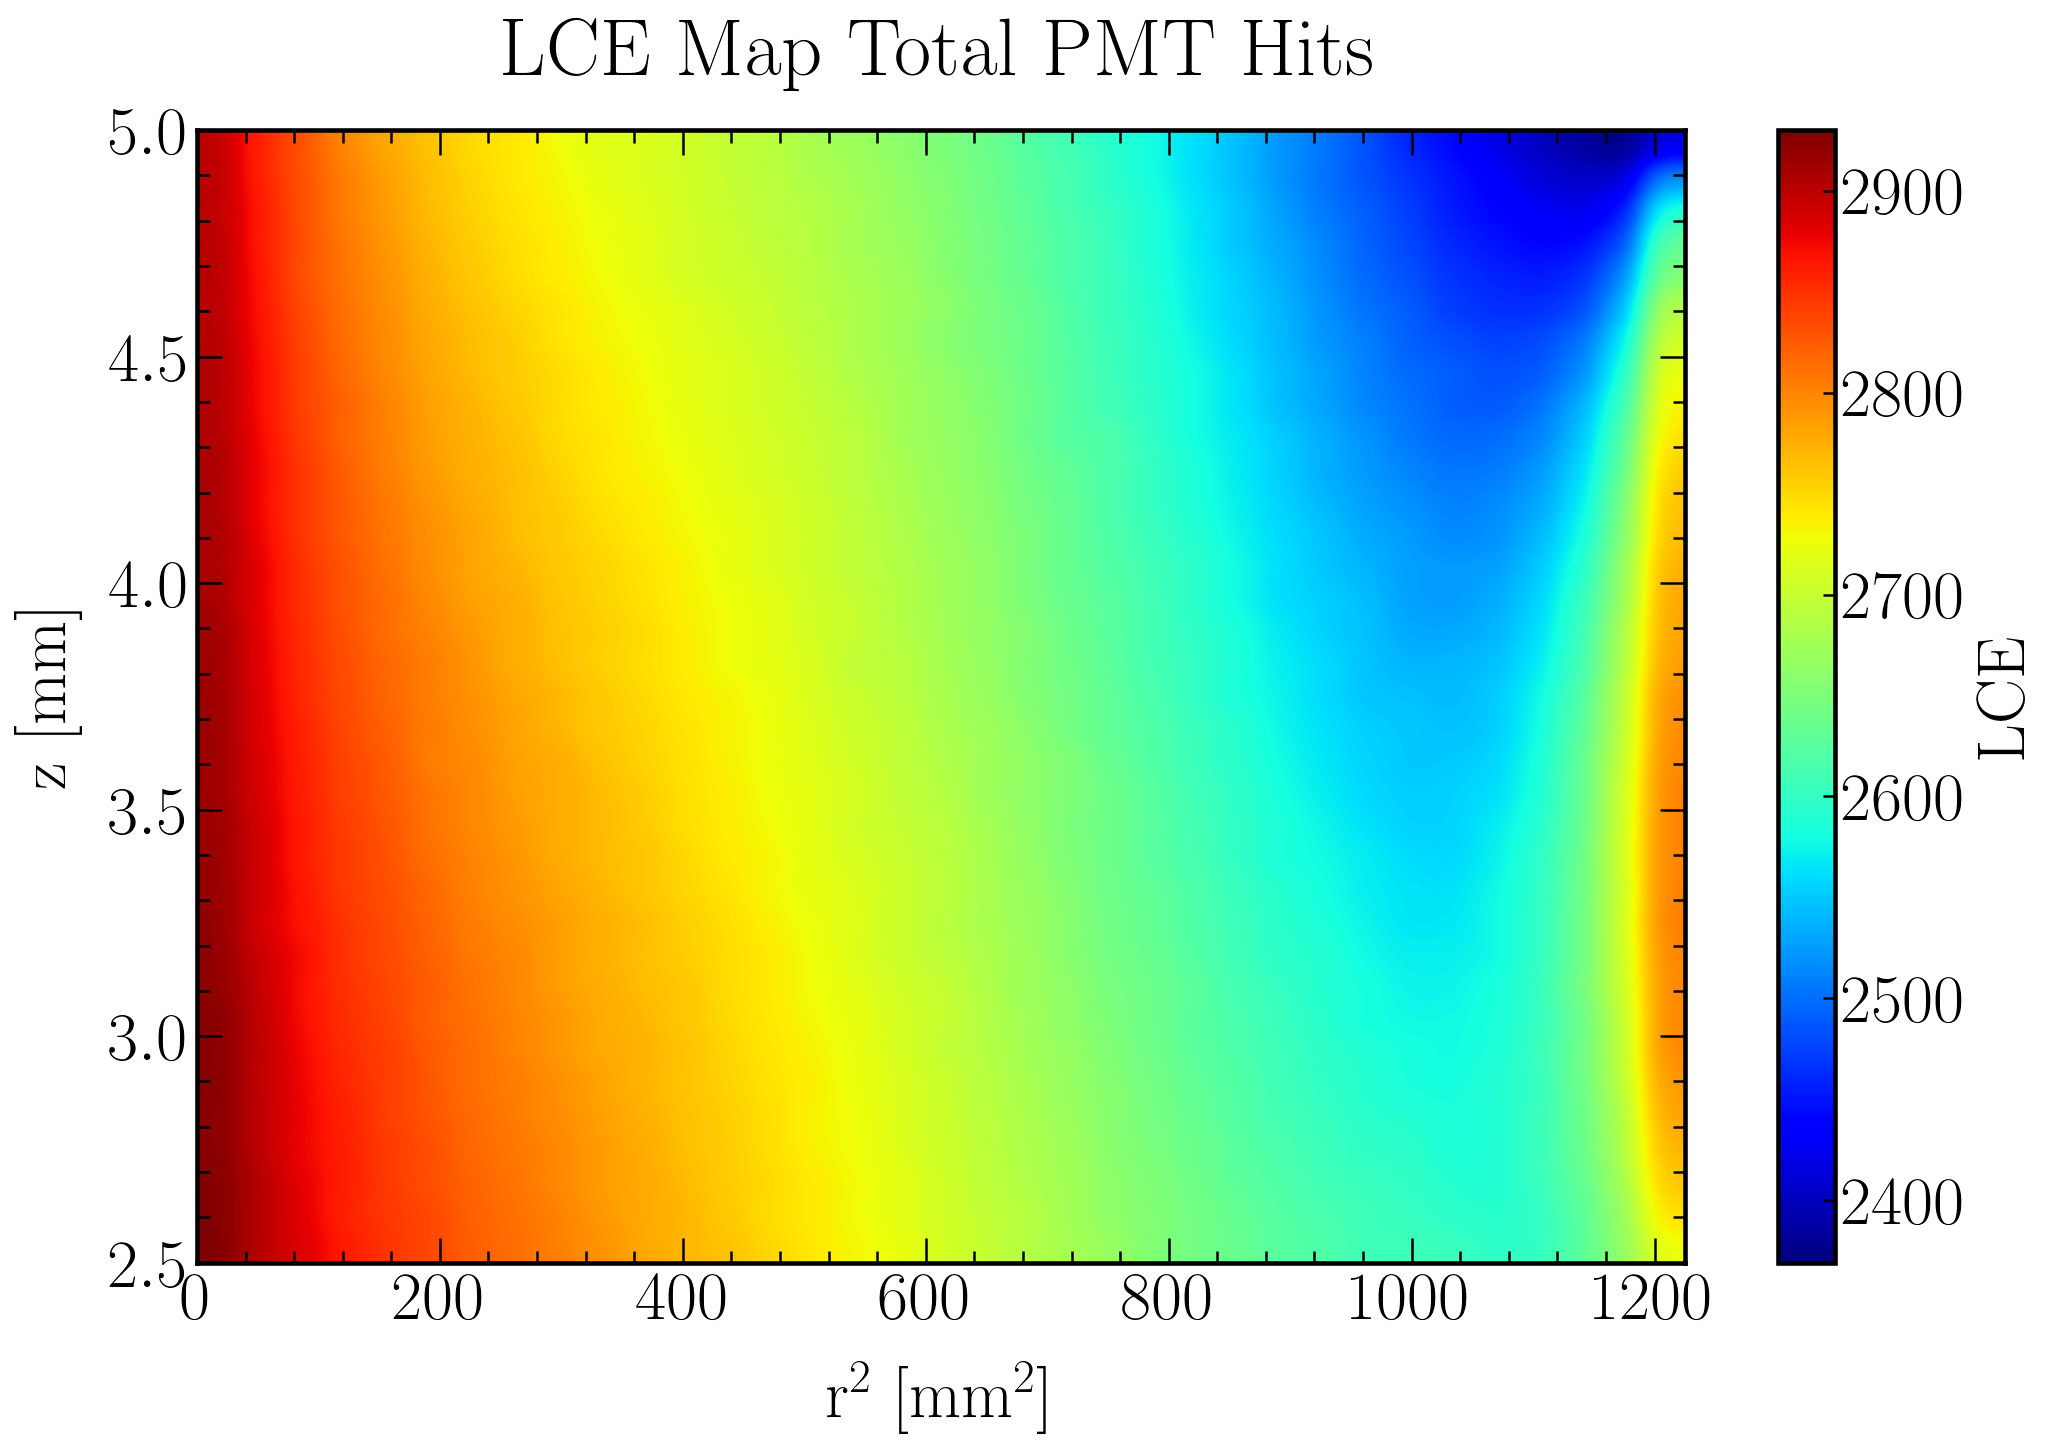

In [44]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LCE.T'].loc['all'], interpolation='gaussian', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total_smooth.png")
plt.show()

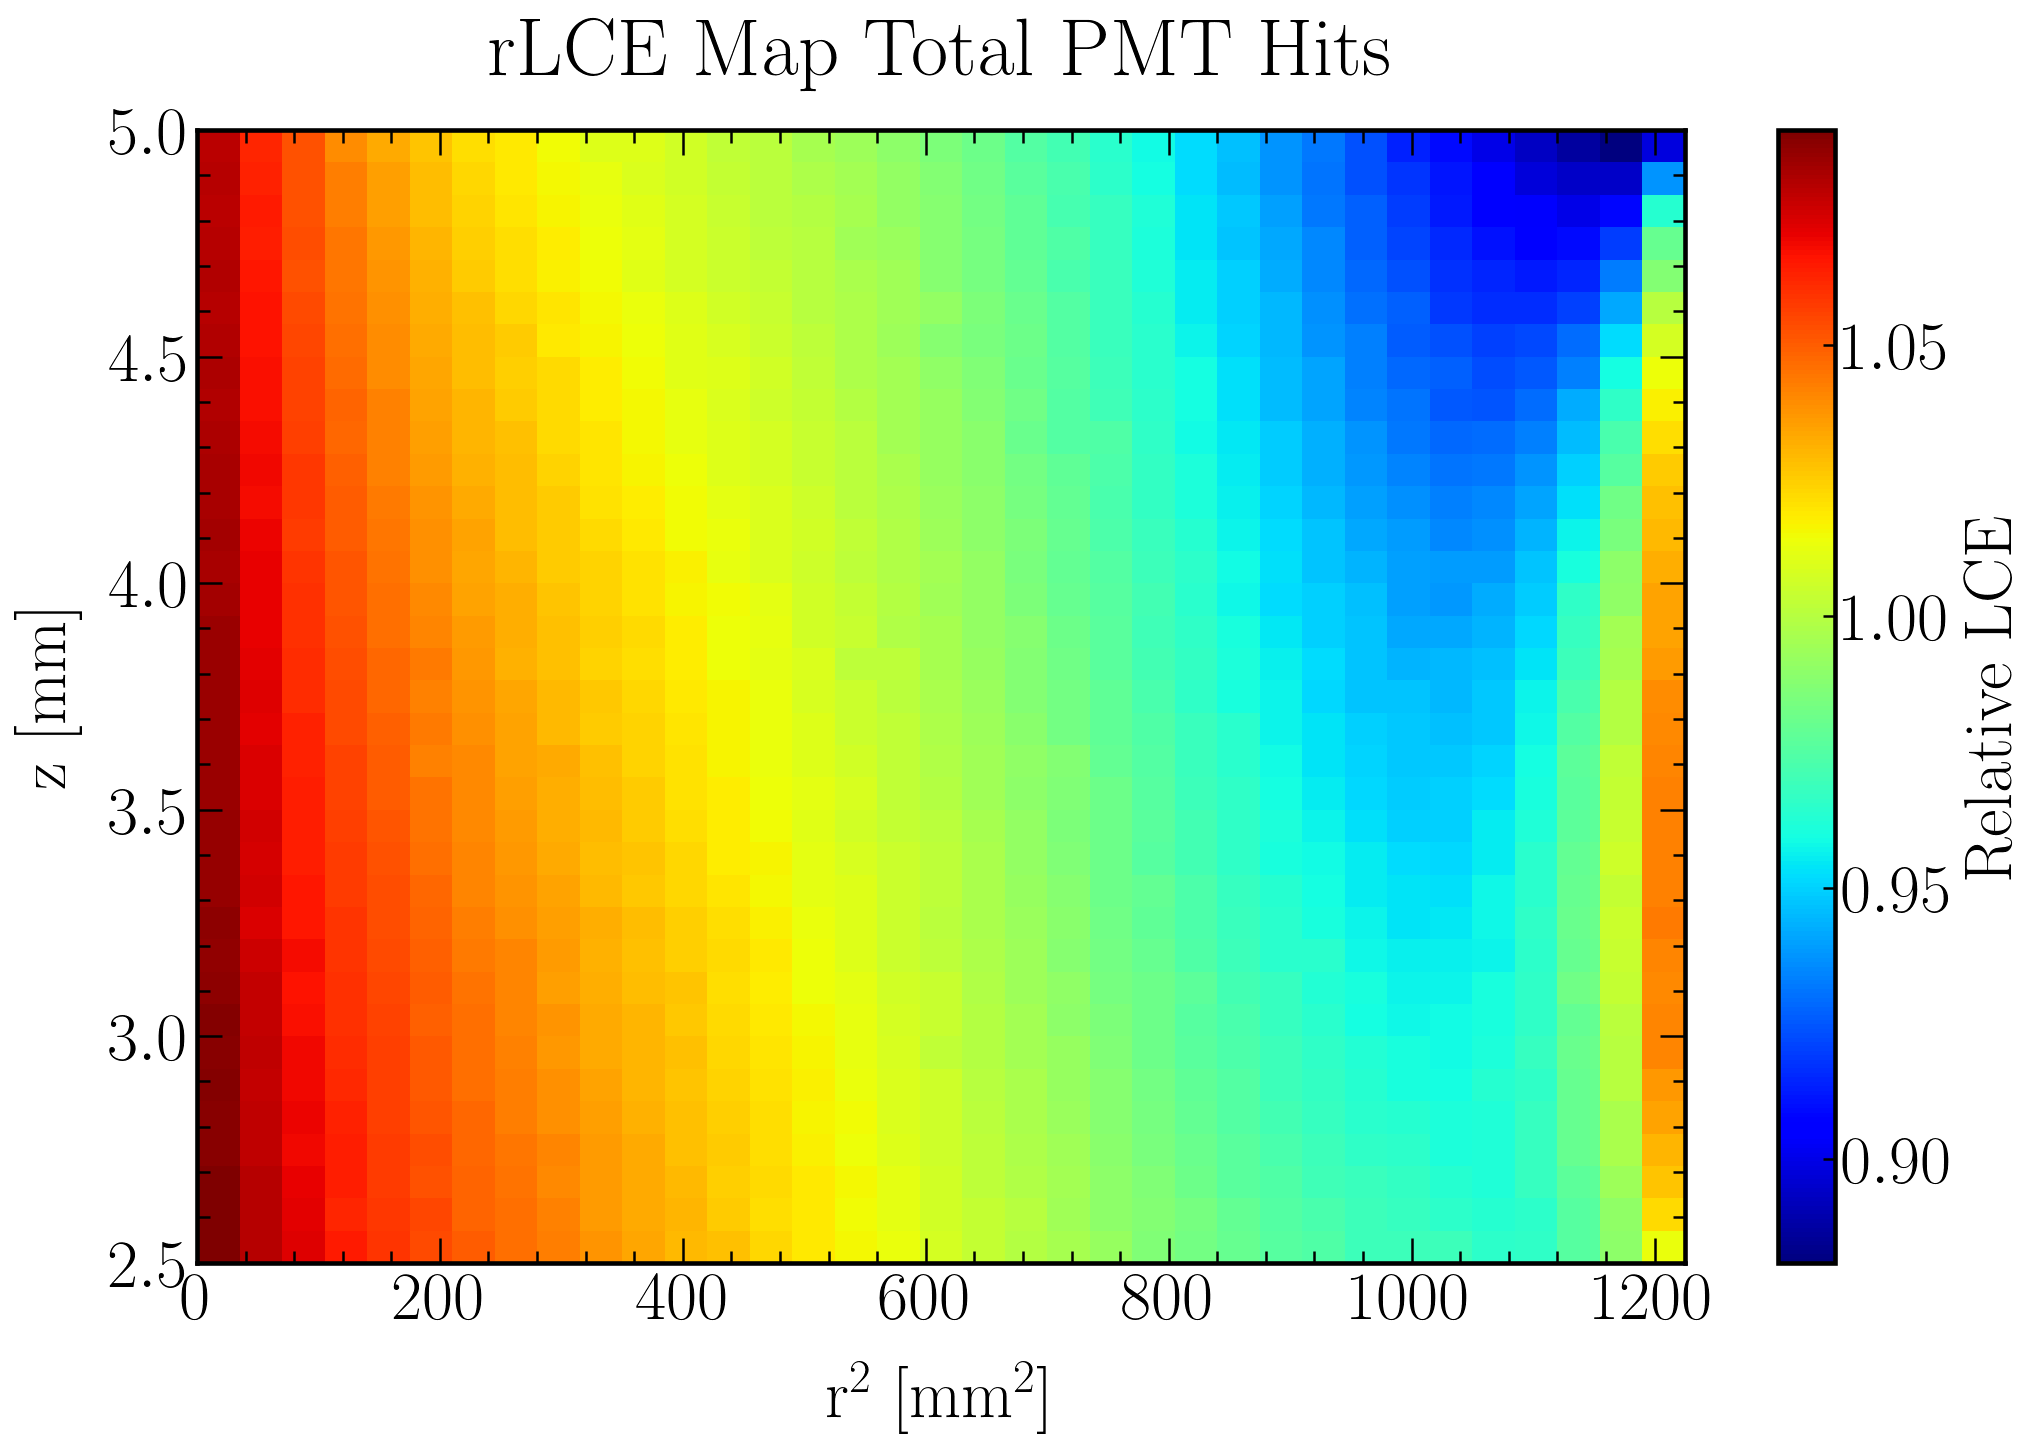

In [45]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.napmthits/(napmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['rLCE.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total_rel.png")
plt.show()

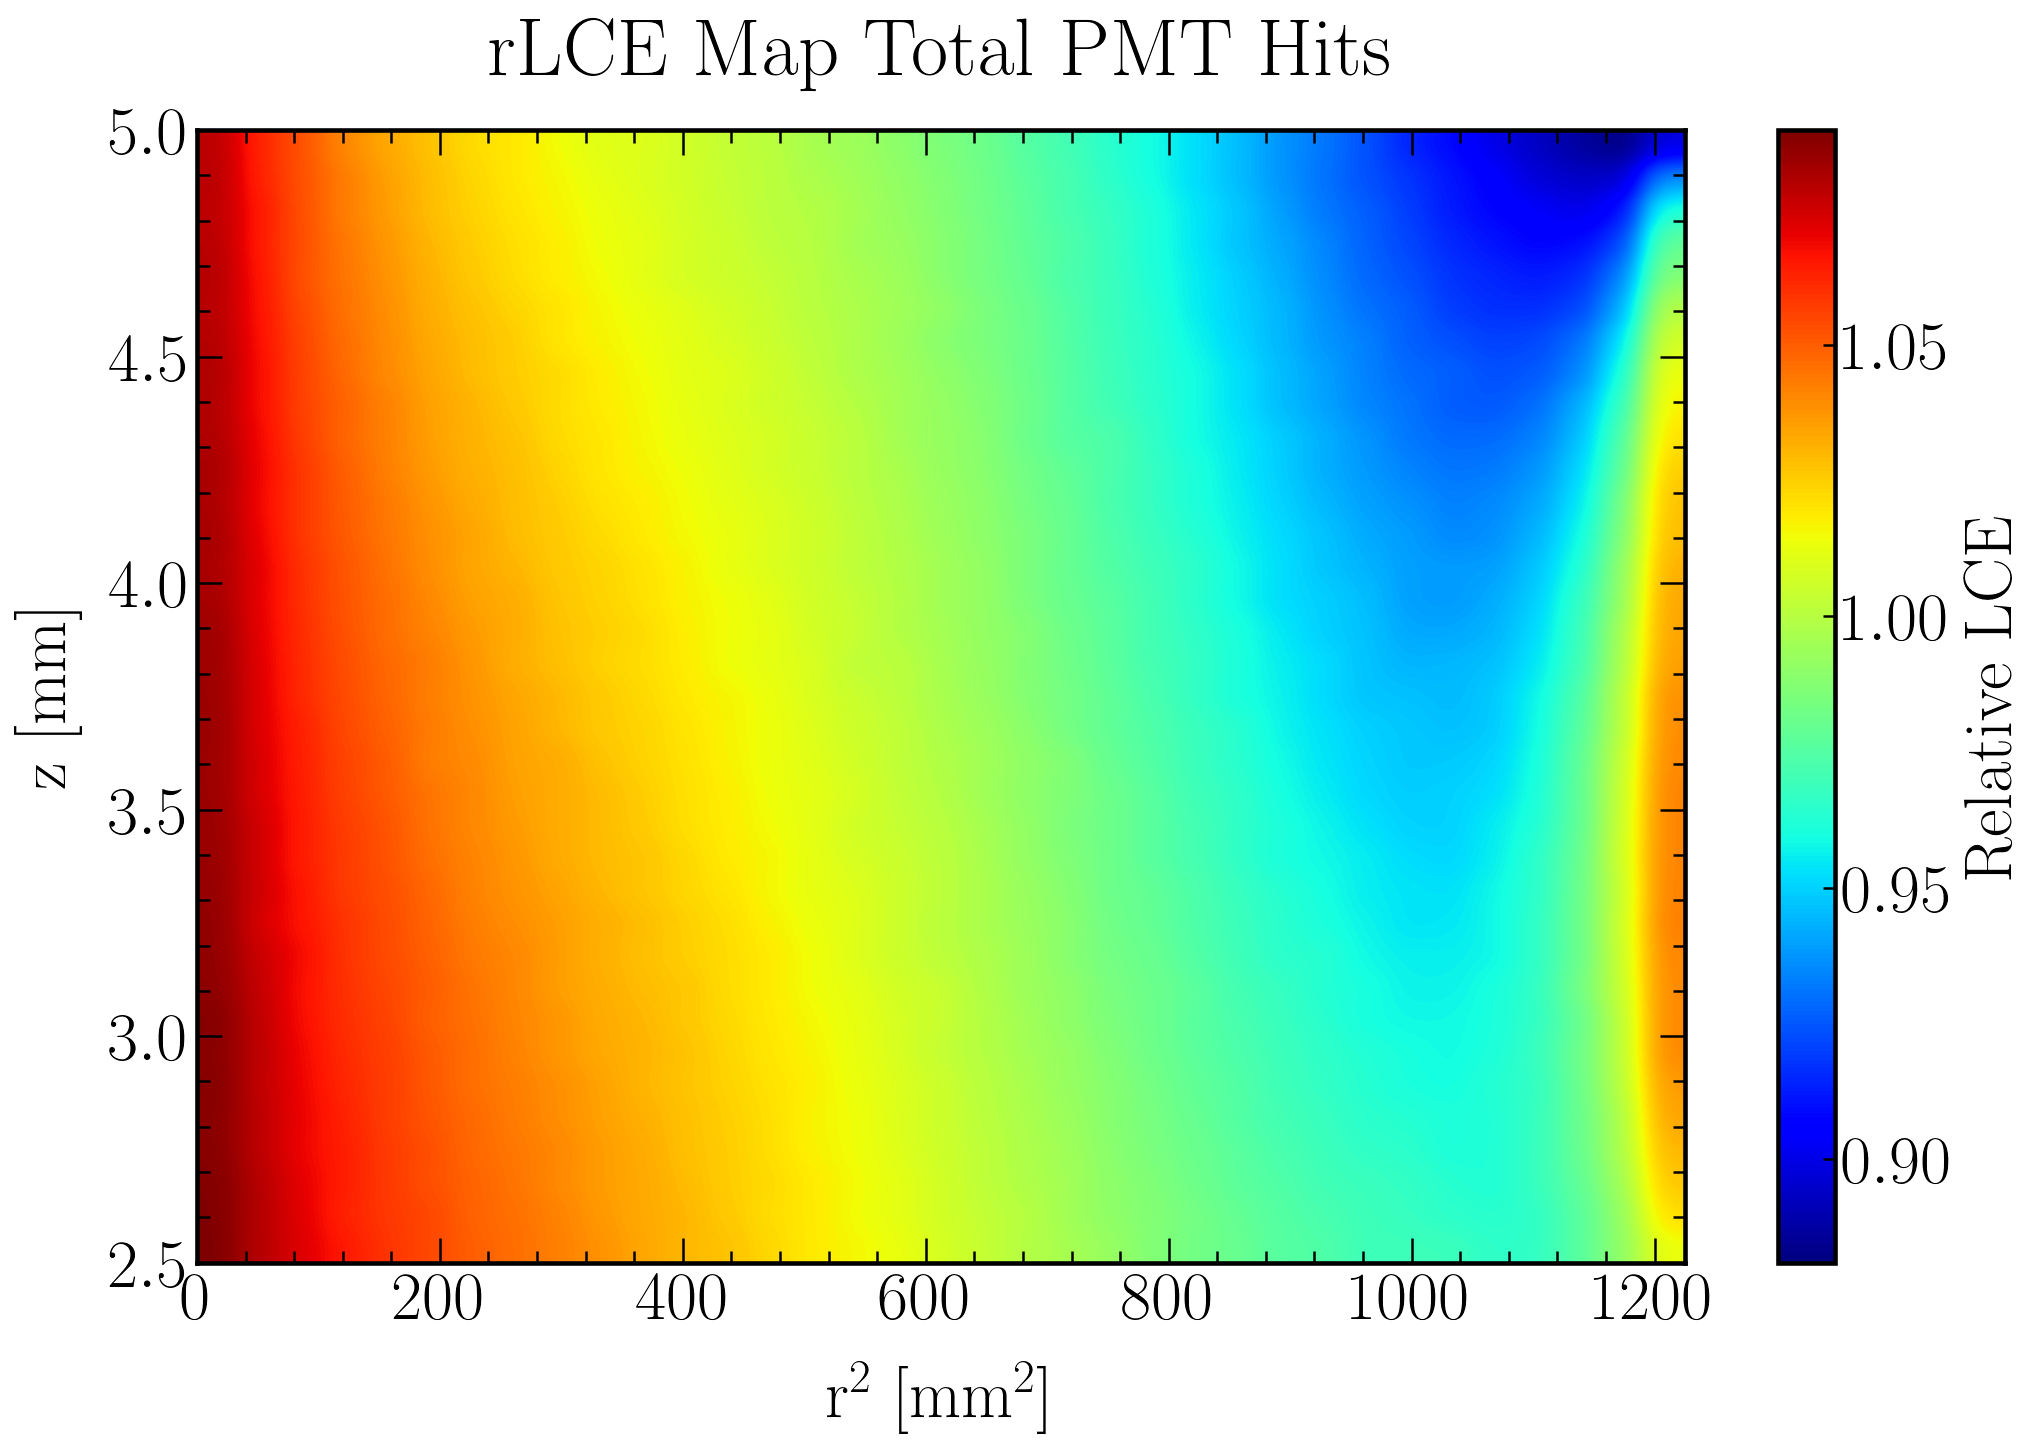

In [46]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.napmthits/(napmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['rLCE.T'].loc['all'], interpolation='gaussian', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total_rel_smooth.png")
plt.show()

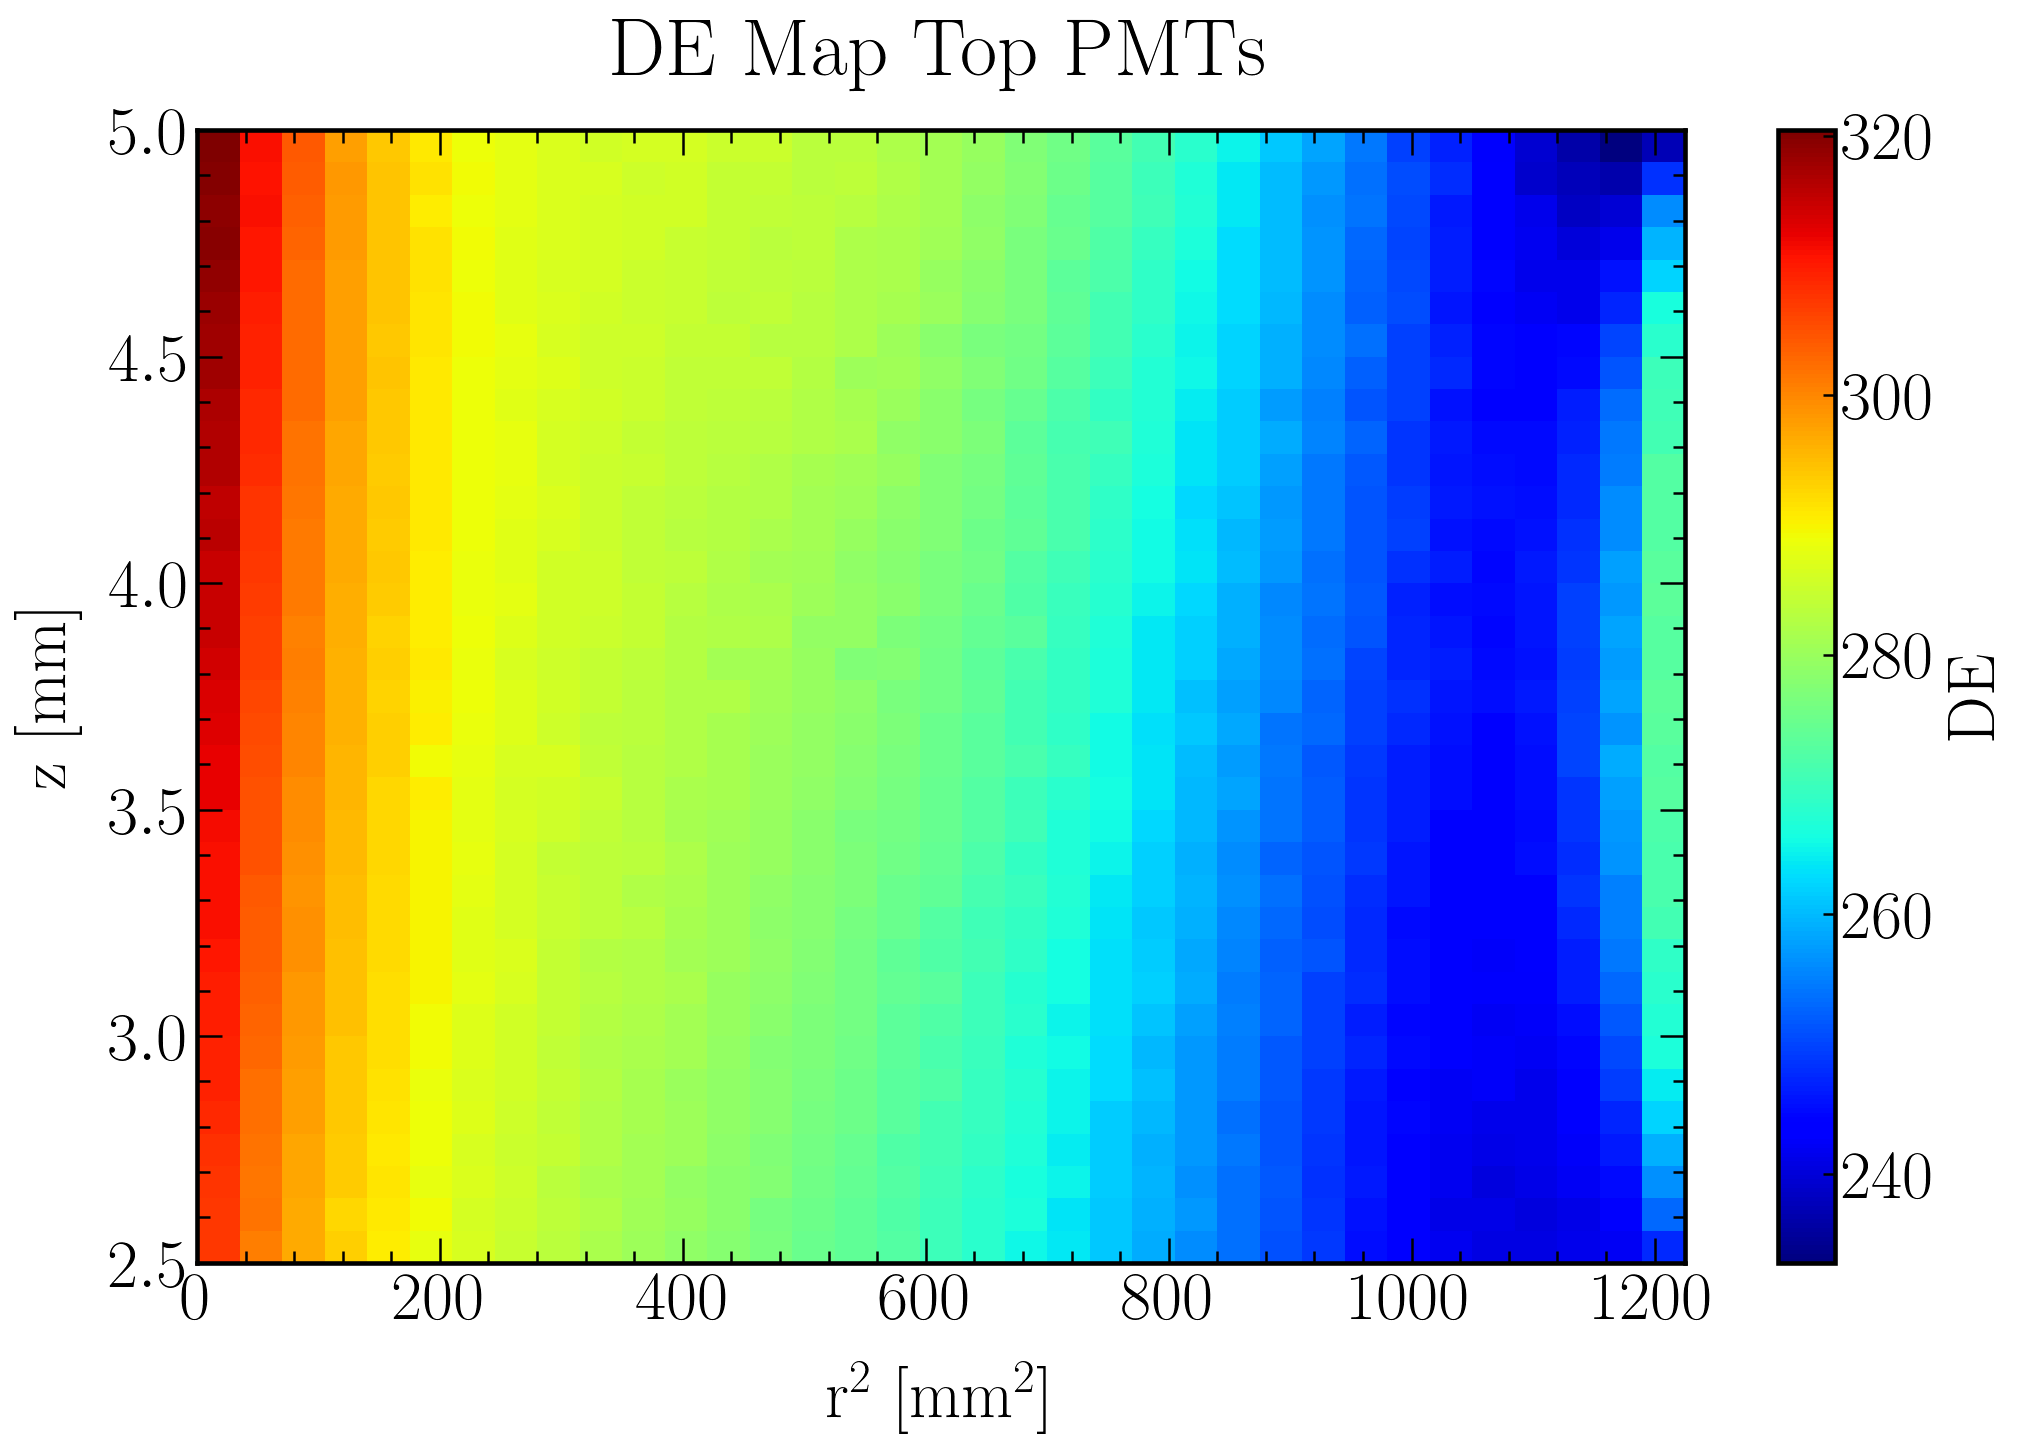

In [47]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['DE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('DE Map Top PMTs', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='DE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_r2_z_Top.png")
plt.show()

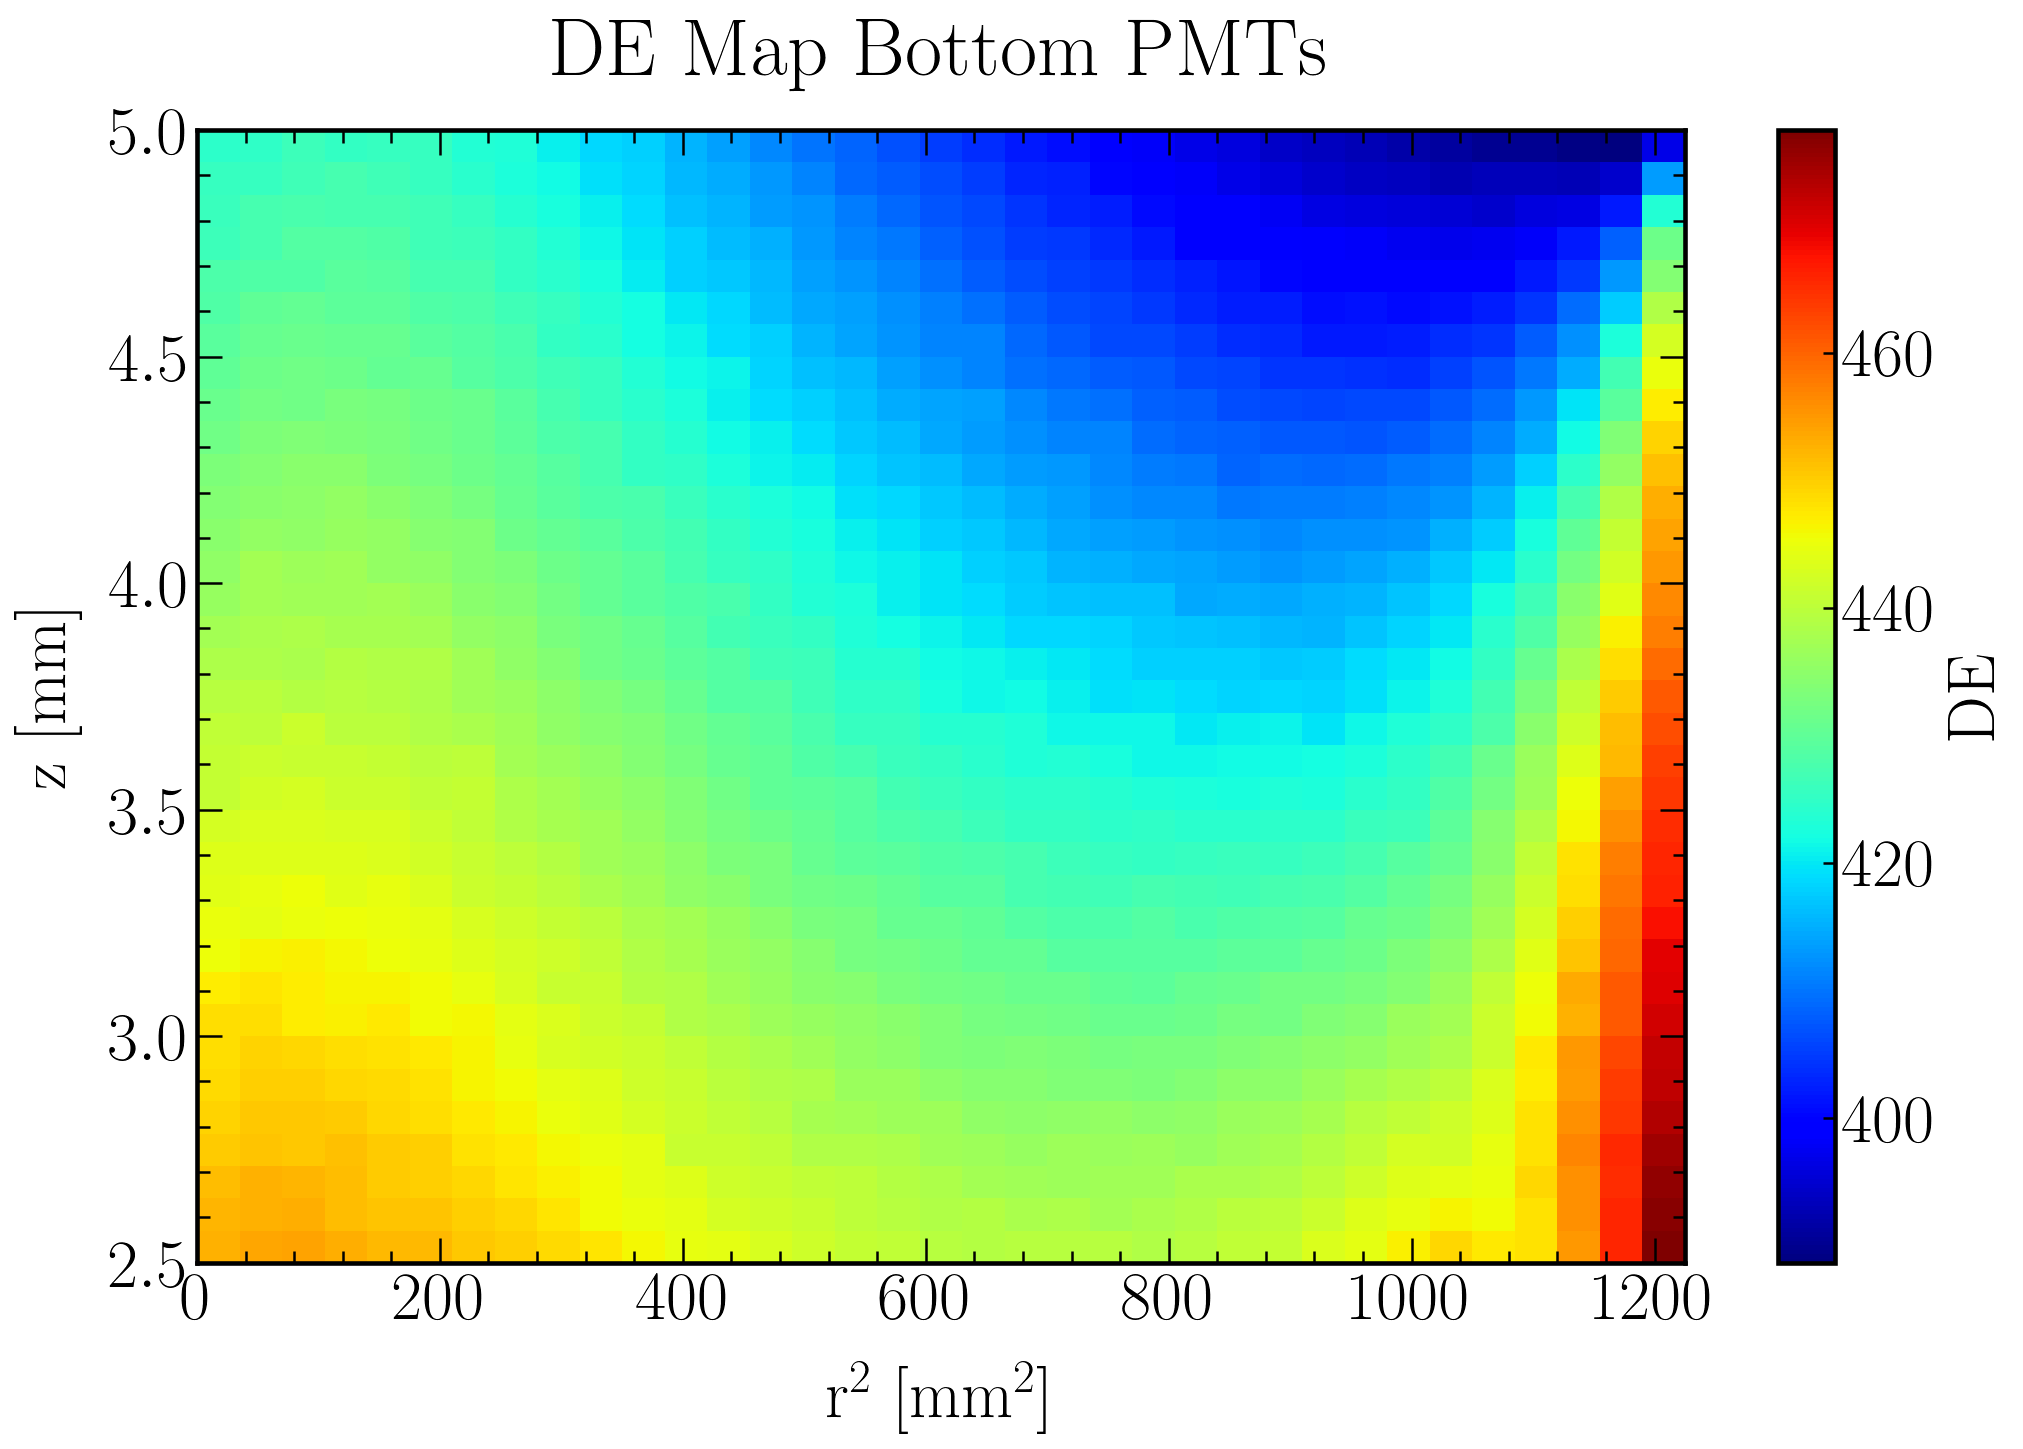

In [48]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['DE.T'].loc['bottom'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('DE Map Bottom PMTs', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='DE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_r2_z_Bottom.png")
plt.show()

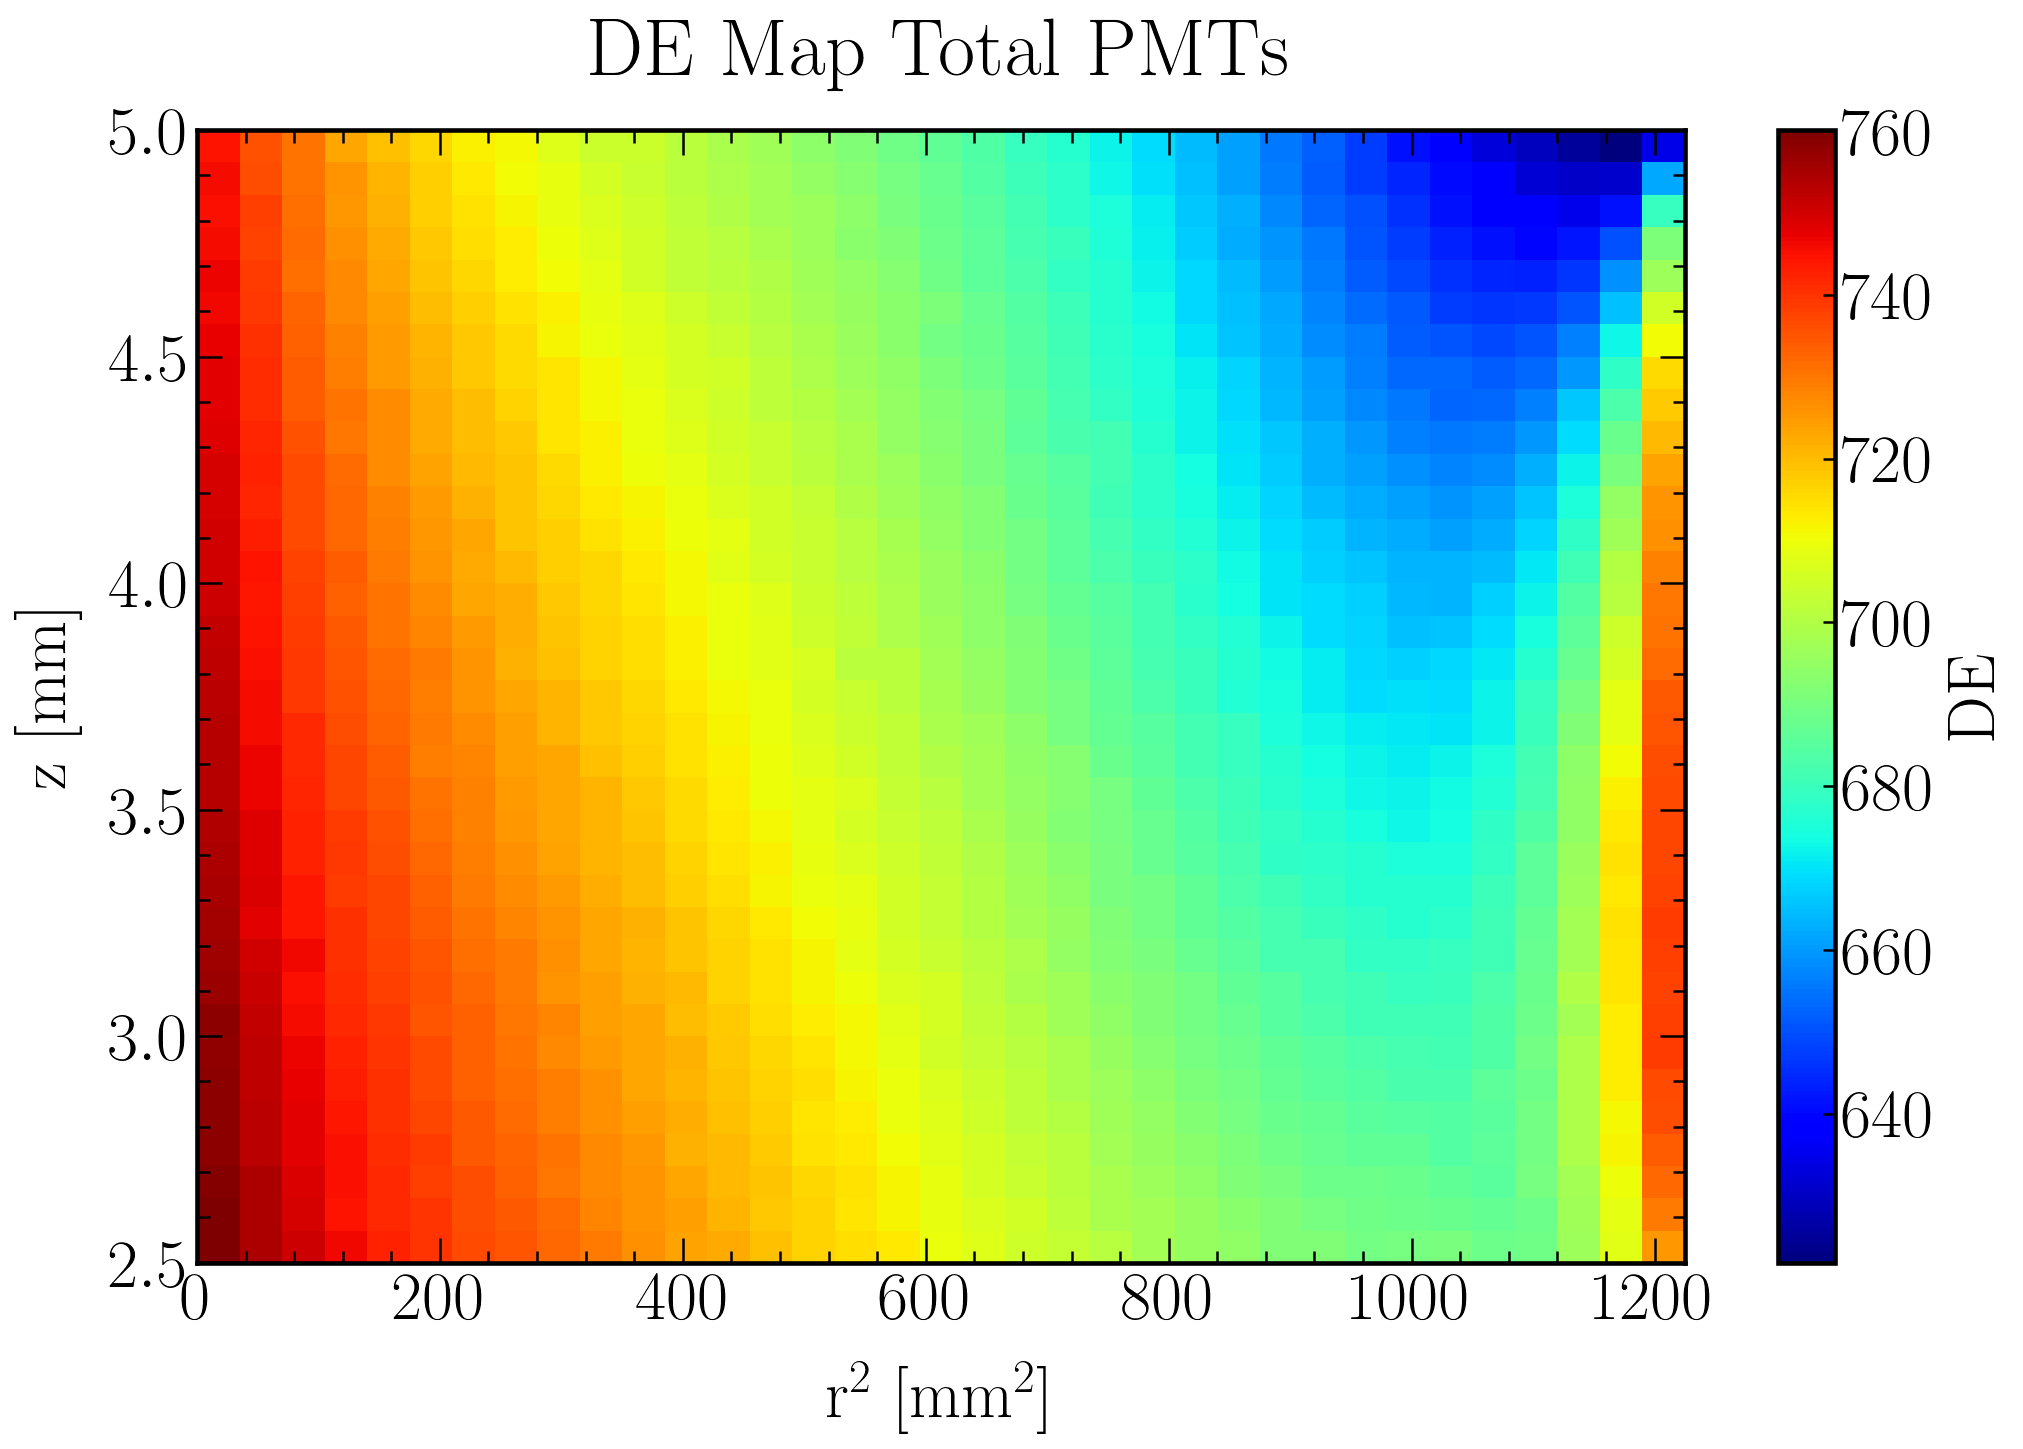

In [49]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['DE.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('DE Map Total PMTs', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='DE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_r2_z_Total.png")
plt.show()

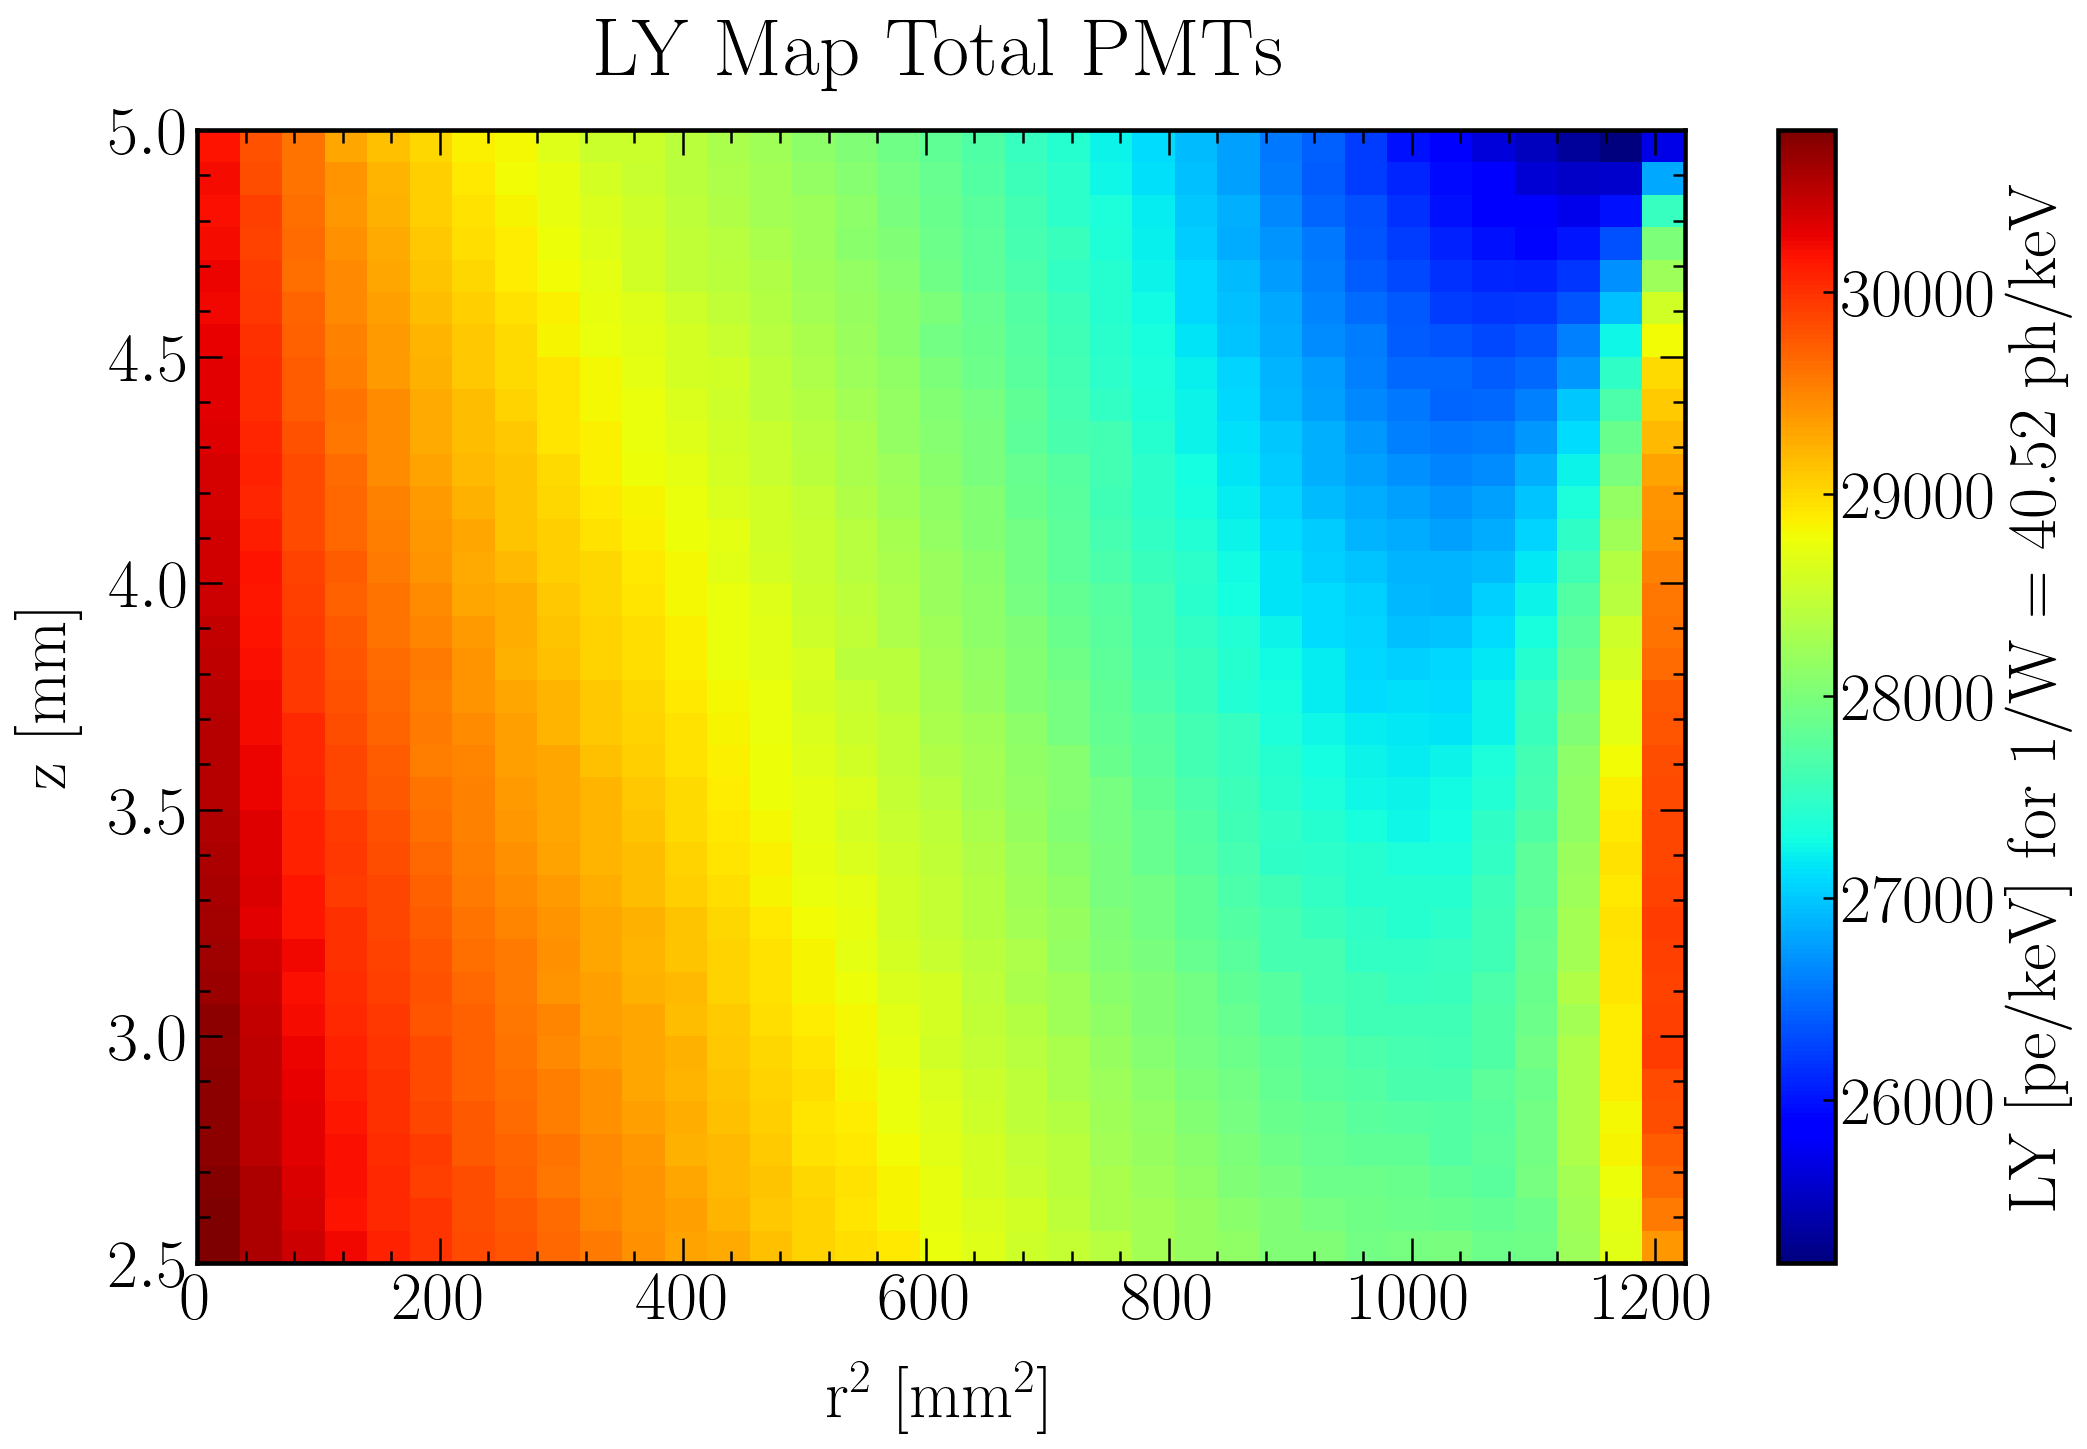

In [50]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LY.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LY Map Total PMTs', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LY [pe/keV] for 1/W = '+str(round(1/W,2))+' ph/keV', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LY_r2_z_Total.png")
plt.show()

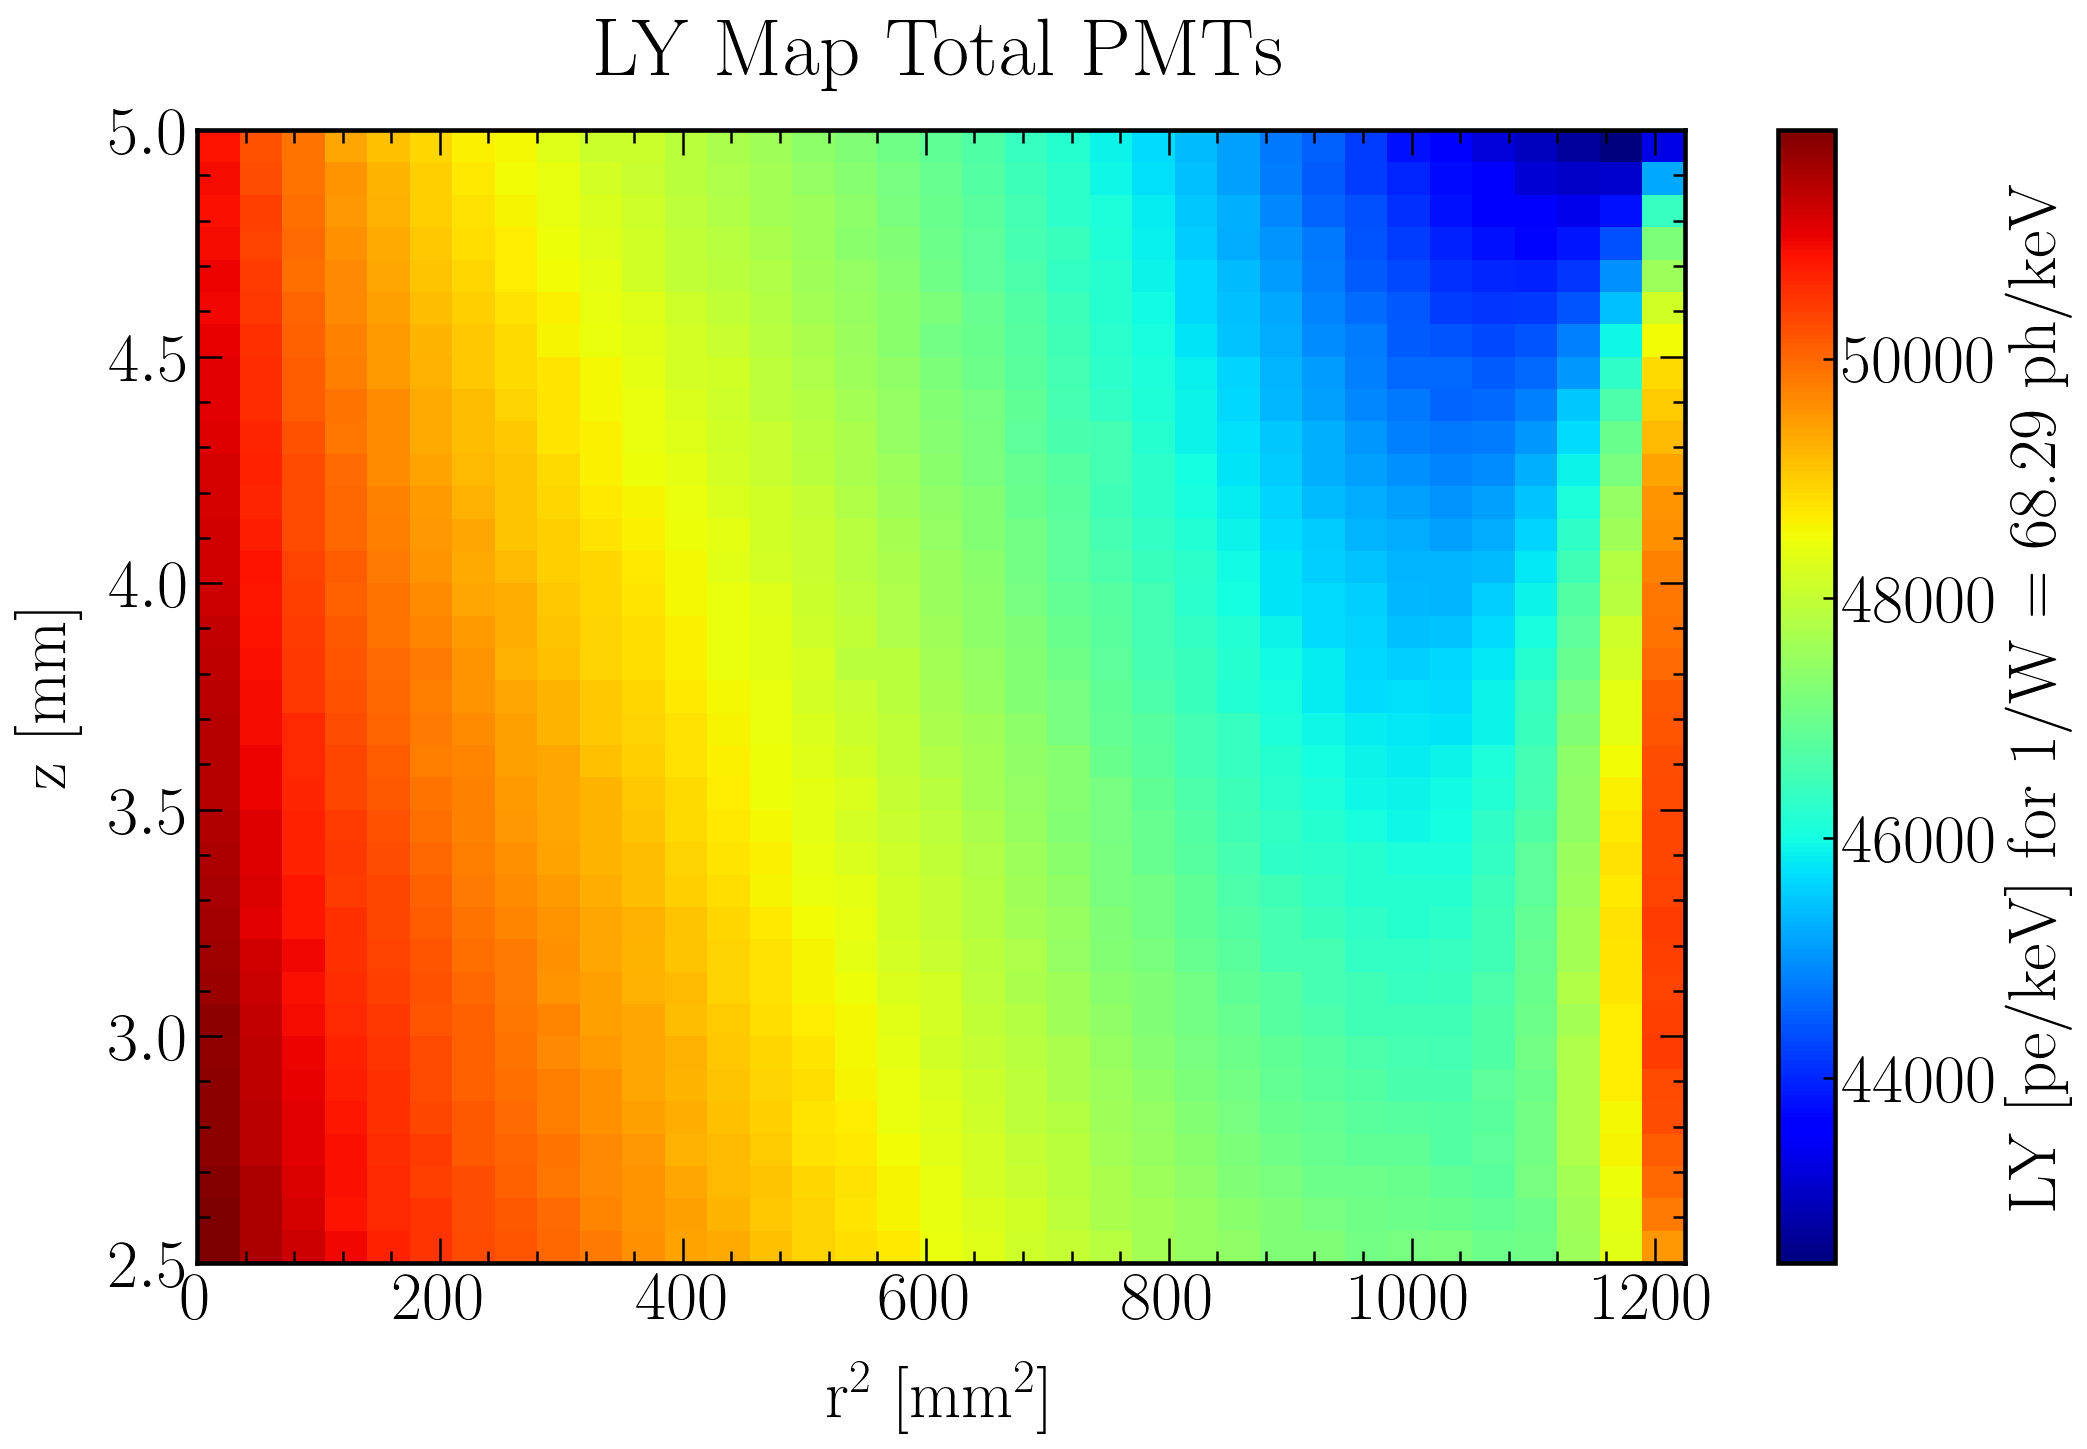

In [51]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

#numberbins = 35

# Data plot
#plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_r2z_hist['LY0.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_r2[0], range_r2[1], range_z[0], range_z[1]], cmap = 'jet')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LY Map Total PMTs', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('auto', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LY [pe/keV] for 1/W = '+str(round(1/W0,2))+' ph/keV', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LY0_r2_z_Total.png")
plt.show()

#### Histogram in x vs y

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


n_total  \
all     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
top     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
bottom  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                n_total.T  \
all     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
top     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
bottom  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                   n_hits  \
all     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
top     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
bottom  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                 n_hits.T  \
all     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
top     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
bottom  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                   xedges  \
all     [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   
top     [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   
bottom  [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   

                                                   yedges  \
all     [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   
top     [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   
bottom  [-35.0, -33.0, -31.0, -29.0, -27.0, -25.0, -23...   

                                             xedgescenter  \
all     [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   
top     [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   
bottom  [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   

                                             yedgescenter  \
all     [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   
top     [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   
bottom  [-34.0, -32.0, -30.0, -28.0, -26.0, -24.0, -22...   

                                                      LCE  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                    LCE.T  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                     rLCE  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                   rLCE.T  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       DE  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                     DE.T  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       LY  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                     LY.T  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
bottom  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                      LY0  \
all     [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
top     

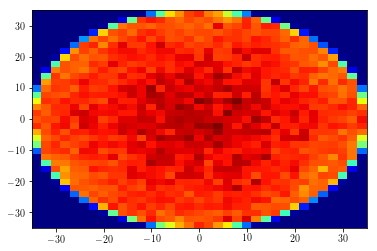

In [52]:
if b_preprocessed == False:
    range_x = [-35, 35]
    range_y = [-35, 35]

    hist_xy_total, xedges_xy_total, yedges_xy_total, kwargs_xy_total = plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=numberbins, weights = None, range = [range_x, range_y], cmap = 'jet')
    xedgescenter_xy_total = (xedges_xy_total[:-1]+xedges_xy_total[1:])/2
    yedgescenter_xy_total = (yedges_xy_total[:-1]+yedges_xy_total[1:])/2
    histT_xy_total = hist_xy_total.T  # Let each row list bins with common y range.

    hist_xy_hits_t, xedges_xy_hits_t, yedges_xy_hits_t, kwargs_xy_hits_t = plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=numberbins, weights = _chunk_collect.ntpmthits, range = [range_x, range_y], cmap = 'jet')
    xedgescenter_xy_hits_t = (xedges_xy_hits_t[:-1]+xedges_xy_hits_t[1:])/2
    yedgescenter_xy_hits_t = (yedges_xy_hits_t[:-1]+yedges_xy_hits_t[1:])/2
    histT_xy_hits_t = hist_xy_hits_t.T  # Let each row list bins with common y range.

    hist_xy_hits_b, xedges_xy_hits_b, yedges_xy_hits_b, kwargs_xy_hits_b = plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=numberbins, weights = _chunk_collect.nbpmthits, range = [range_x, range_y], cmap = 'jet')
    xedgescenter_xy_hits_b = (xedges_xy_hits_b[:-1]+xedges_xy_hits_b[1:])/2
    yedgescenter_xy_hits_b = (yedges_xy_hits_b[:-1]+yedges_xy_hits_b[1:])/2
    histT_xy_hits_b = hist_xy_hits_b.T  # Let each row list bins with common y range.

    hist_xy_hits_a, xedges_xy_hits_a, yedges_xy_hits_a, kwargs_xy_hits_a = plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=numberbins, weights = _chunk_collect.napmthits, range = [range_x, range_y], cmap = 'jet')
    xedgescenter_xy_hits_a = (xedges_xy_hits_a[:-1]+xedges_xy_hits_a[1:])/2
    yedgescenter_xy_hits_a = (yedges_xy_hits_a[:-1]+yedges_xy_hits_a[1:])/2
    histT_xy_hits_a = hist_xy_hits_a.T  # Let each row list bins with common y range.


    hist_xy_LCE_t = hist_xy_hits_t / hist_xy_total
    histT_xy_LCE_t = histT_xy_hits_t / histT_xy_total

    hist_xy_LCE_b = hist_xy_hits_b / hist_xy_total
    histT_xy_LCE_b = histT_xy_hits_b / histT_xy_total

    hist_xy_LCE_a = hist_xy_hits_a / hist_xy_total
    histT_xy_LCE_a = histT_xy_hits_a / histT_xy_total


    val = hist_xy_LCE_t
    val = val[~np.isnan(val)].mean()
    hist_xy_rLCE_t = hist_xy_LCE_t / val
    histT_xy_rLCE_t = histT_xy_LCE_t / val

    val = hist_xy_LCE_b
    val = val[~np.isnan(val)].mean()
    hist_xy_rLCE_b = hist_xy_LCE_b / val
    histT_xy_rLCE_b = histT_xy_LCE_b / val

    val = hist_xy_LCE_a
    val = val[~np.isnan(val)].mean()
    hist_xy_rLCE_a = hist_xy_LCE_a / val
    histT_xy_rLCE_a = histT_xy_LCE_a / val


    hist_xy_DE_t = hist_xy_LCE_t * QE_Top * CE_Top
    histT_xy_DE_t = histT_xy_LCE_t * QE_Top * CE_Top

    hist_xy_DE_b = hist_xy_LCE_b * QE_Bottom * CE_Bottom
    histT_xy_DE_b = histT_xy_LCE_b * QE_Bottom * CE_Bottom

    hist_xy_DE_a = hist_xy_DE_t + hist_xy_DE_b
    histT_xy_DE_a = histT_xy_DE_t + histT_xy_DE_b


    hist_xy_LY_t = hist_xy_DE_t/W
    histT_xy_LY_t = histT_xy_DE_t/W

    hist_xy_LY_b = hist_xy_DE_b/W
    histT_xy_LY_b = histT_xy_DE_b/W

    hist_xy_LY_a = hist_xy_DE_a/W
    histT_xy_LY_a = histT_xy_DE_a/W


    hist_xy_LY0_t = hist_xy_DE_t/W0
    histT_xy_LY0_t = histT_xy_DE_t/W0

    hist_xy_LY0_b = hist_xy_DE_b/W0
    histT_xy_LY0_b = histT_xy_DE_b/W0

    hist_xy_LY0_a = hist_xy_DE_a/W0
    histT_xy_LY0_a = histT_xy_DE_a/W0


    LCE_xy_hist = pd.DataFrame({'n_total' : [hist_xy_total,hist_xy_total,hist_xy_total], 'n_total.T' : [histT_xy_total,histT_xy_total,histT_xy_total], 'n_hits' : [hist_xy_hits_a,hist_xy_hits_t,hist_xy_hits_b], 'n_hits.T' : [histT_xy_hits_a,histT_xy_hits_t,histT_xy_hits_b], 'xedges' : [xedges_xy_hits_a,xedges_xy_hits_t,xedges_xy_hits_b], 'yedges' : [yedges_xy_hits_a,yedges_xy_hits_t,yedges_xy_hits_b], 'xedgescenter' : [xedgescenter_xy_hits_a,xedgescenter_xy_hits_t,xedgescenter_xy_hits_b], 'yedgescenter' : [yedgescenter_xy_hits_a,yedgescenter_xy_hits_t,yedgescenter_xy_hits_b], 'LCE' : [hist_xy_LCE_a,hist_xy_LCE_t,hist_xy_LCE_b], 'LCE.T' : [histT_xy_LCE_a,histT_xy_LCE_t,histT_xy_LCE_b], 'rLCE' : [hist_xy_rLCE_a,hist_xy_rLCE_t,hist_xy_rLCE_b], 'rLCE.T' : [histT_xy_rLCE_a,histT_xy_rLCE_t,histT_xy_rLCE_b], 'DE' : [hist_xy_DE_a,hist_xy_DE_t,hist_xy_DE_b], 'DE.T' : [histT_xy_DE_a,histT_xy_DE_t,histT_xy_DE_b], 'LY' : [hist_xy_LY_a,hist_xy_LY_t,hist_xy_LY_b], 'LY.T' : [histT_xy_LY_a,histT_xy_LY_t,histT_xy_LY_b], 'LY0' : [hist_xy_LY0_a,hist_xy_LY0_t,hist_xy_LY0_b], 'LY0.T' : [histT_xy_LY0_a,histT_xy_LY0_t,histT_xy_LY0_b]}, index=['all','top','bottom'])
    columns = ['n_total', 'n_total.T', 'n_hits', 'n_hits.T', 'xedges', 'yedges', 'xedgescenter', 'yedgescenter', 'LCE', 'LCE.T', 'rLCE', 'rLCE.T', 'DE', 'DE.T', 'LY', 'LY.T', 'LY0', 'LY0.T']
    LCE_xy_hist.to_pickle(filenameprefix+"_LCE_xy_hist.pkl")
    
if b_preprocessed == True:    
    range_x = [-35, 35]
    range_y = [-35, 35]
    
LCE_xy_hist

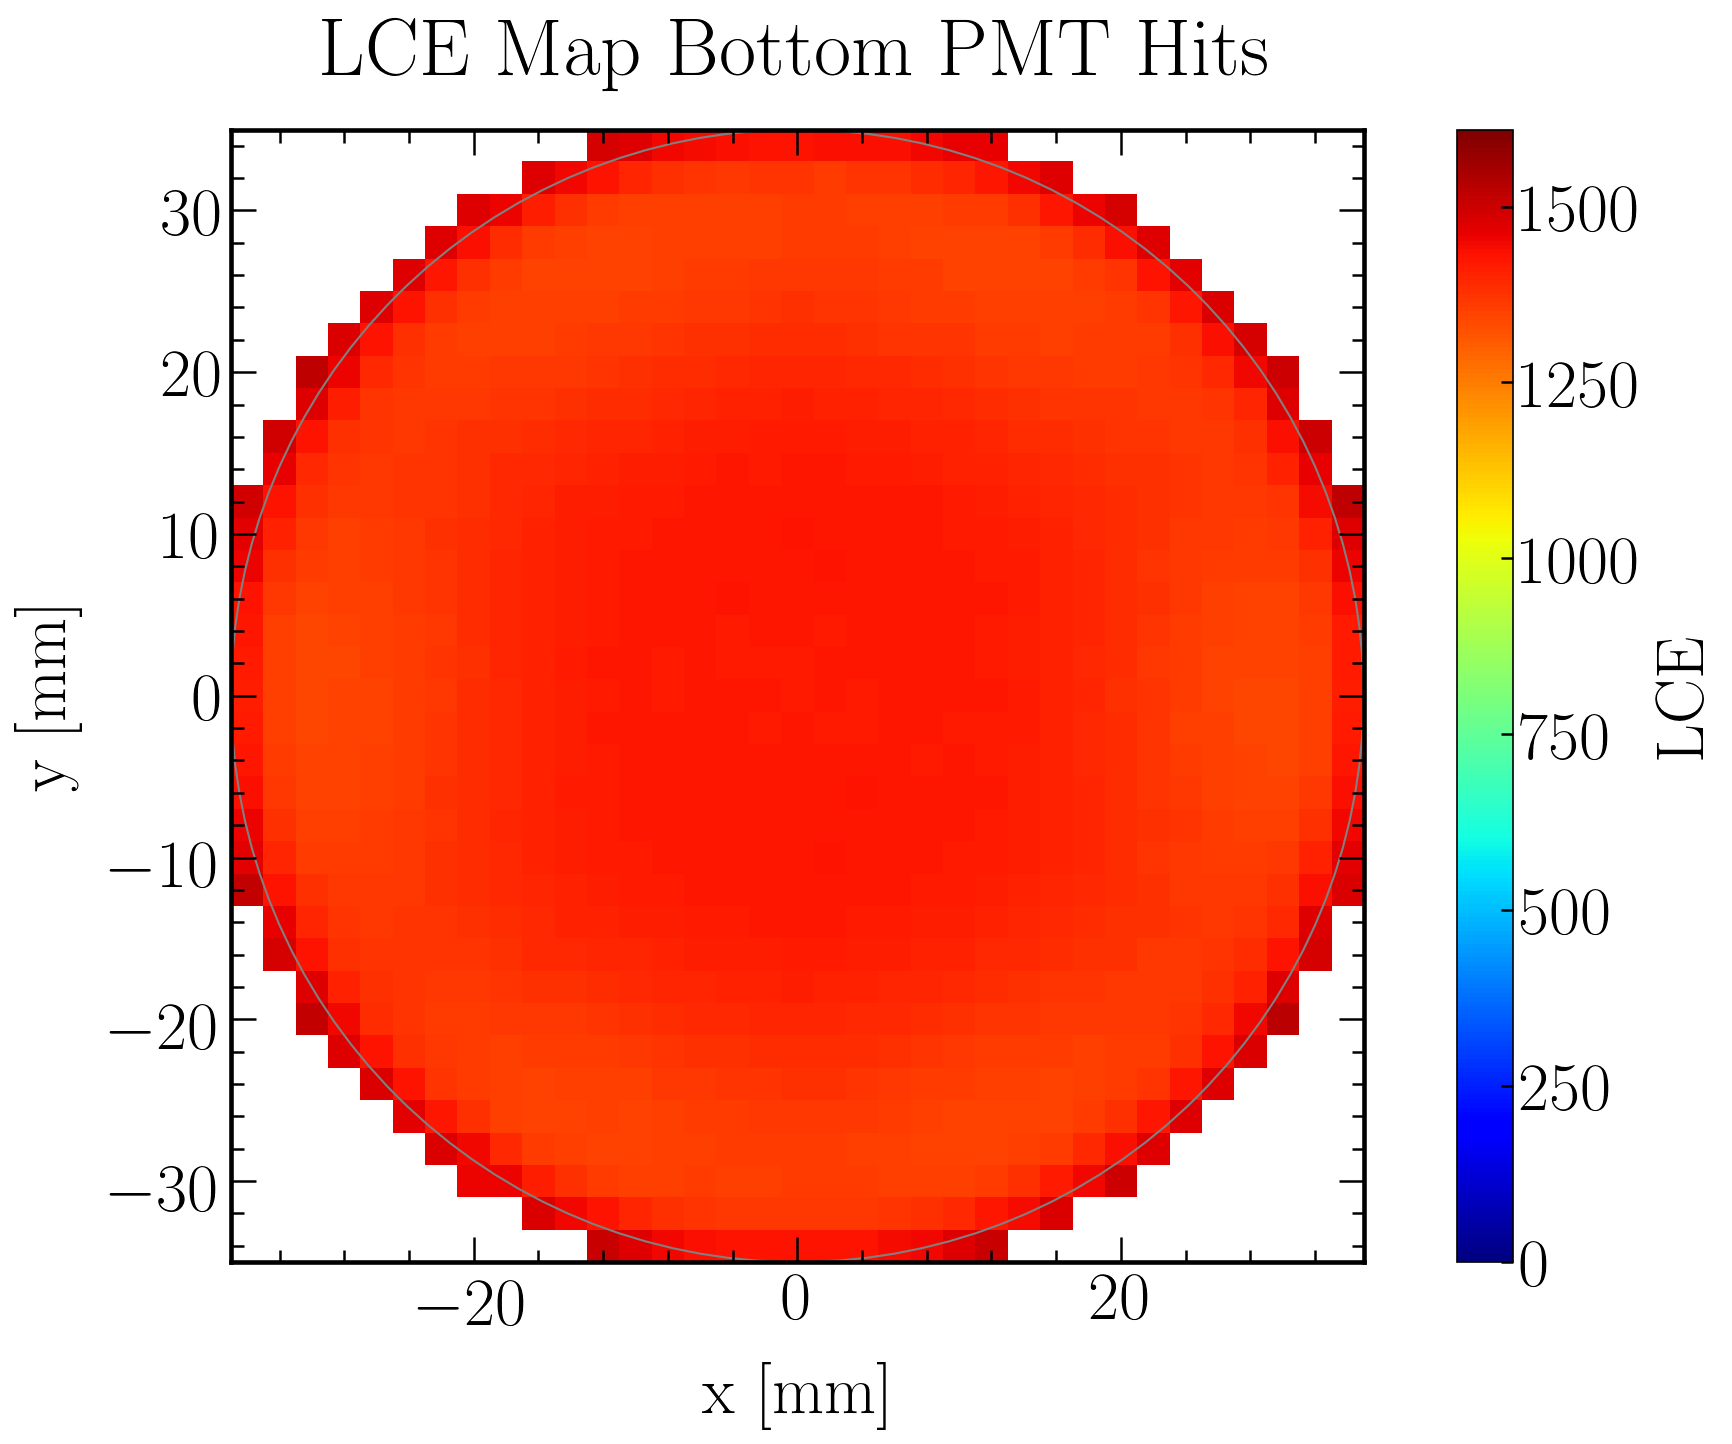

In [53]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwBottom*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_xy_hist['LCE.T'].loc['bottom'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['LCE.T'].loc['bottom']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0., val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Bottom.png")
plt.show()

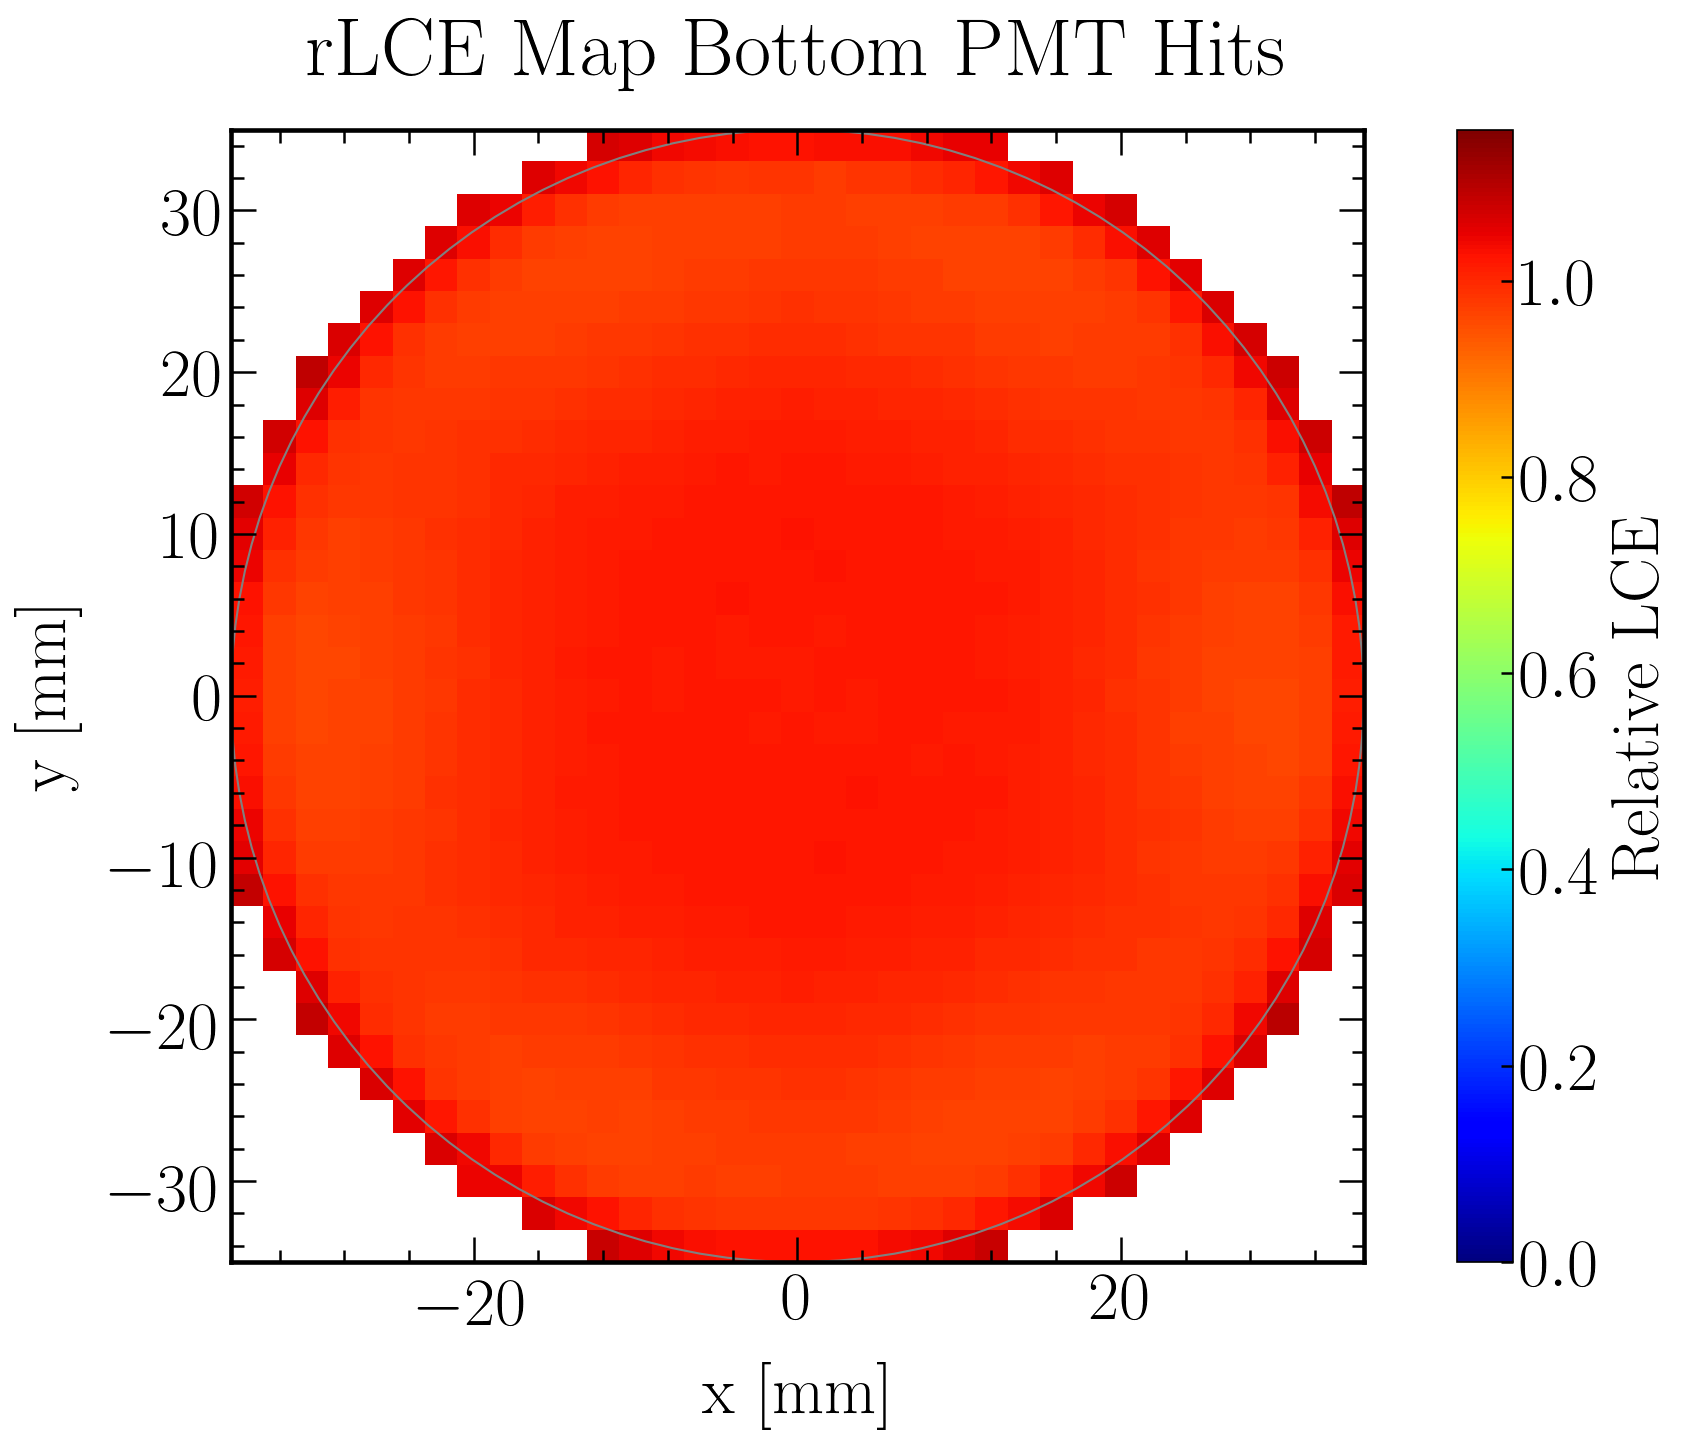

In [54]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwBottom*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_xy_hist['rLCE.T'].loc['bottom'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['rLCE.T'].loc['bottom']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Bottom_rel.png")
plt.show()

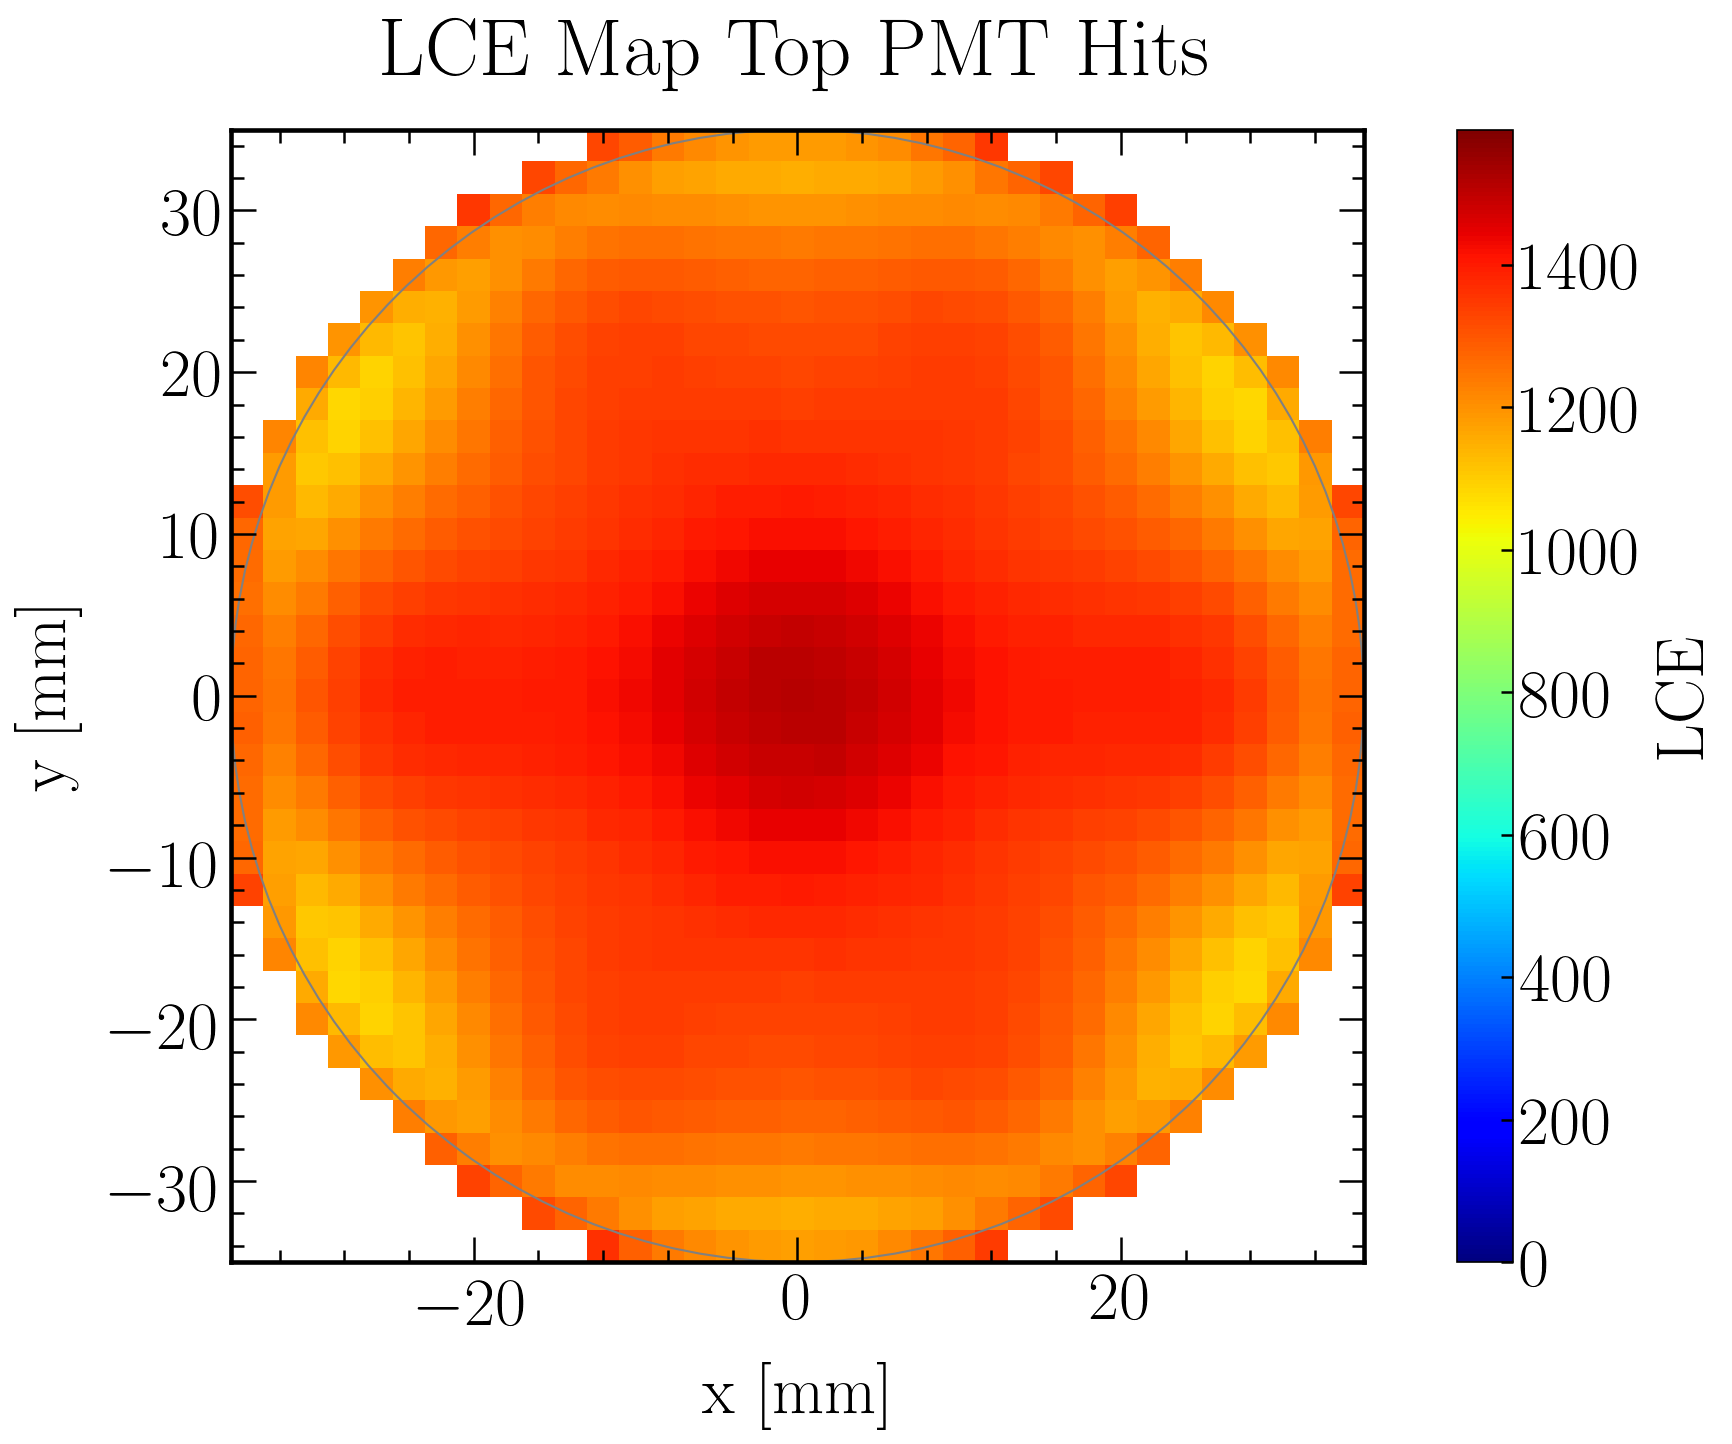

In [55]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwTop*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_xy_hist['LCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['LCE.T'].loc['top']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Top.png")
plt.show()

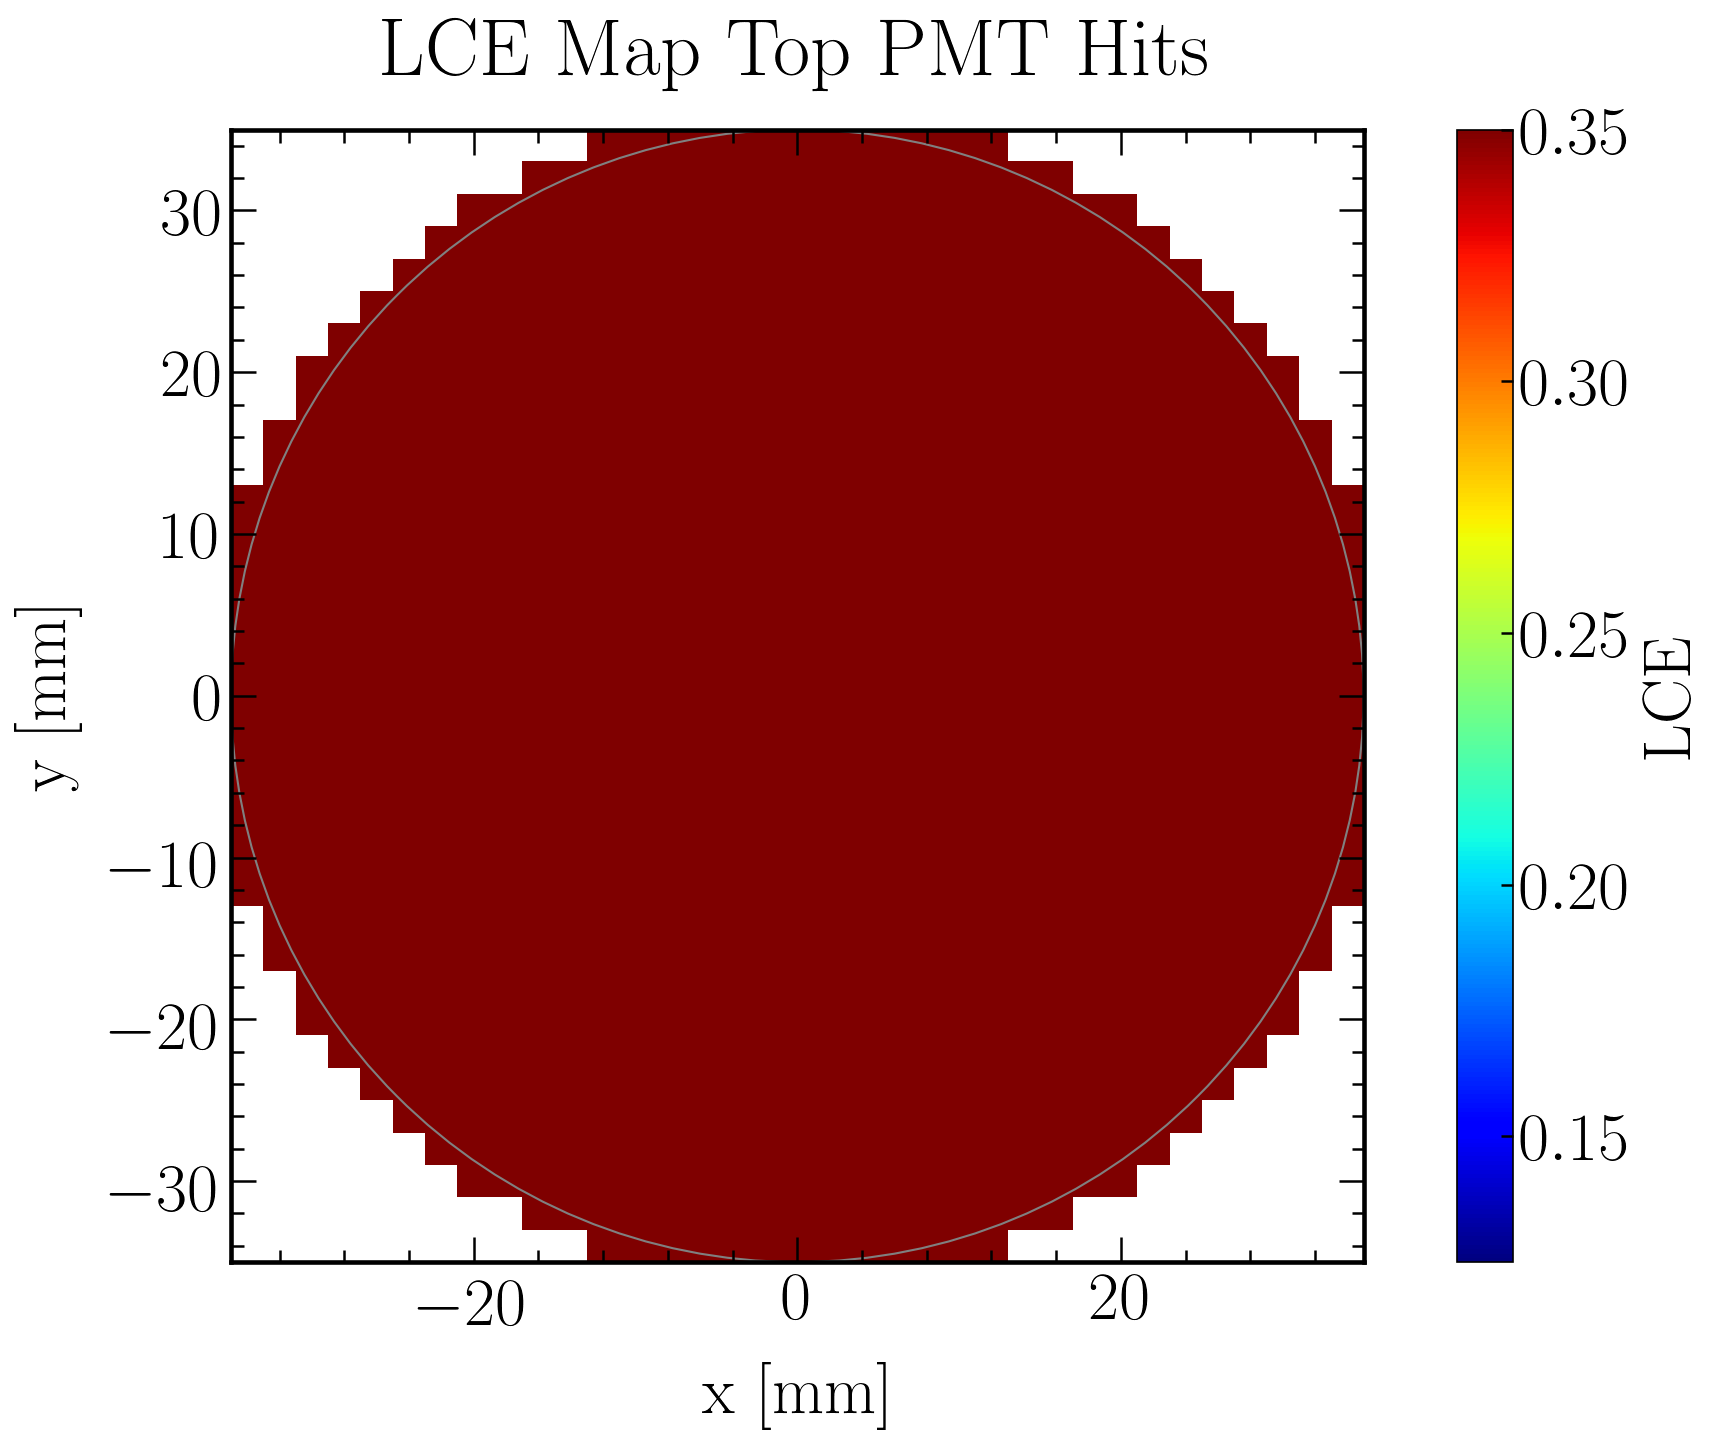

In [56]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwTop*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_xy_hist['LCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)
plt.clim(0.125, 0.35)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Top_scaled.png")
plt.show()

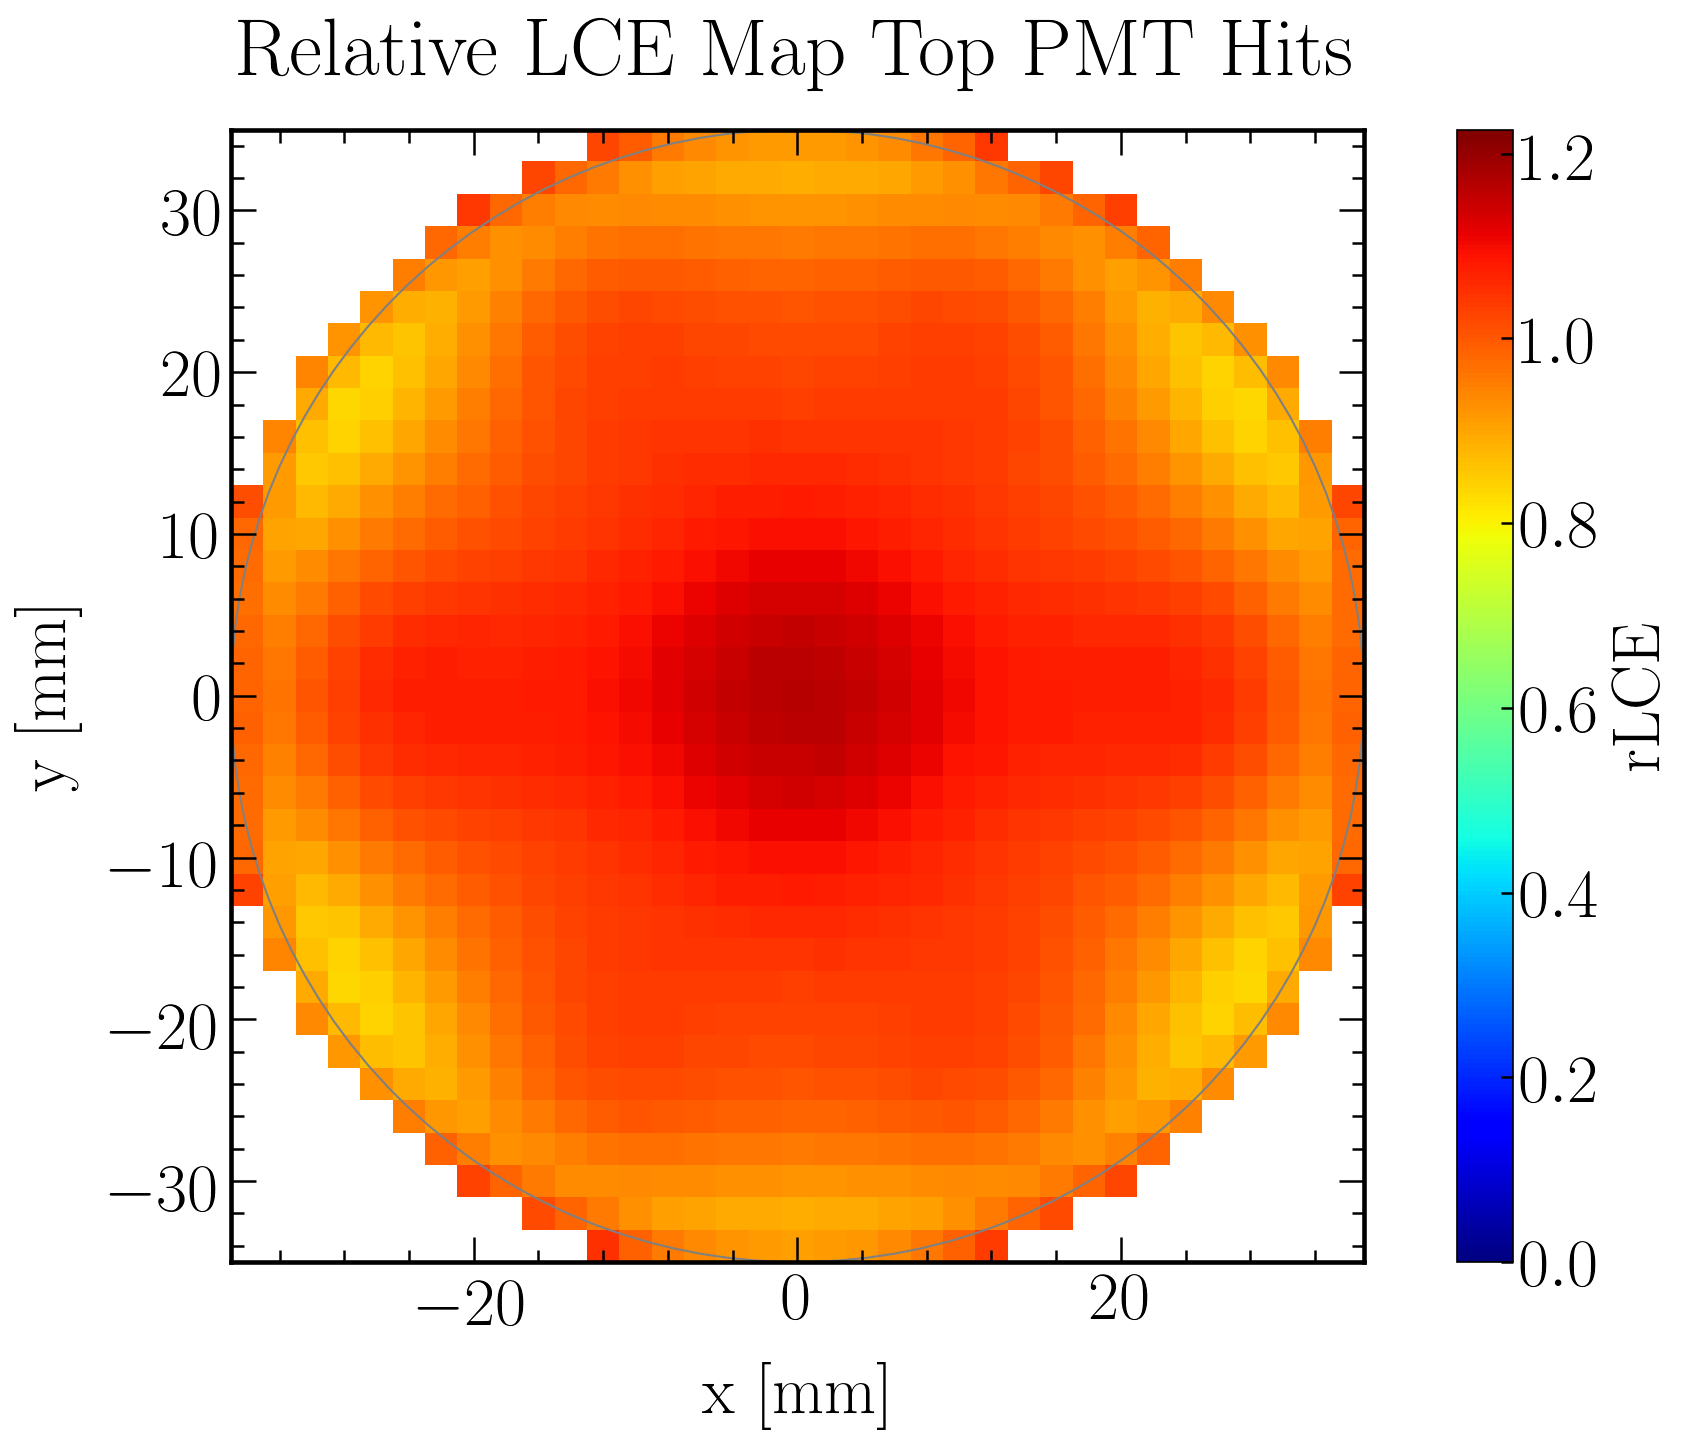

In [57]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwTop*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
plt.imshow(LCE_xy_hist['rLCE.T'].loc['top'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Relative LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='rLCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['rLCE.T'].loc['top']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Top_rel.png")
plt.show()

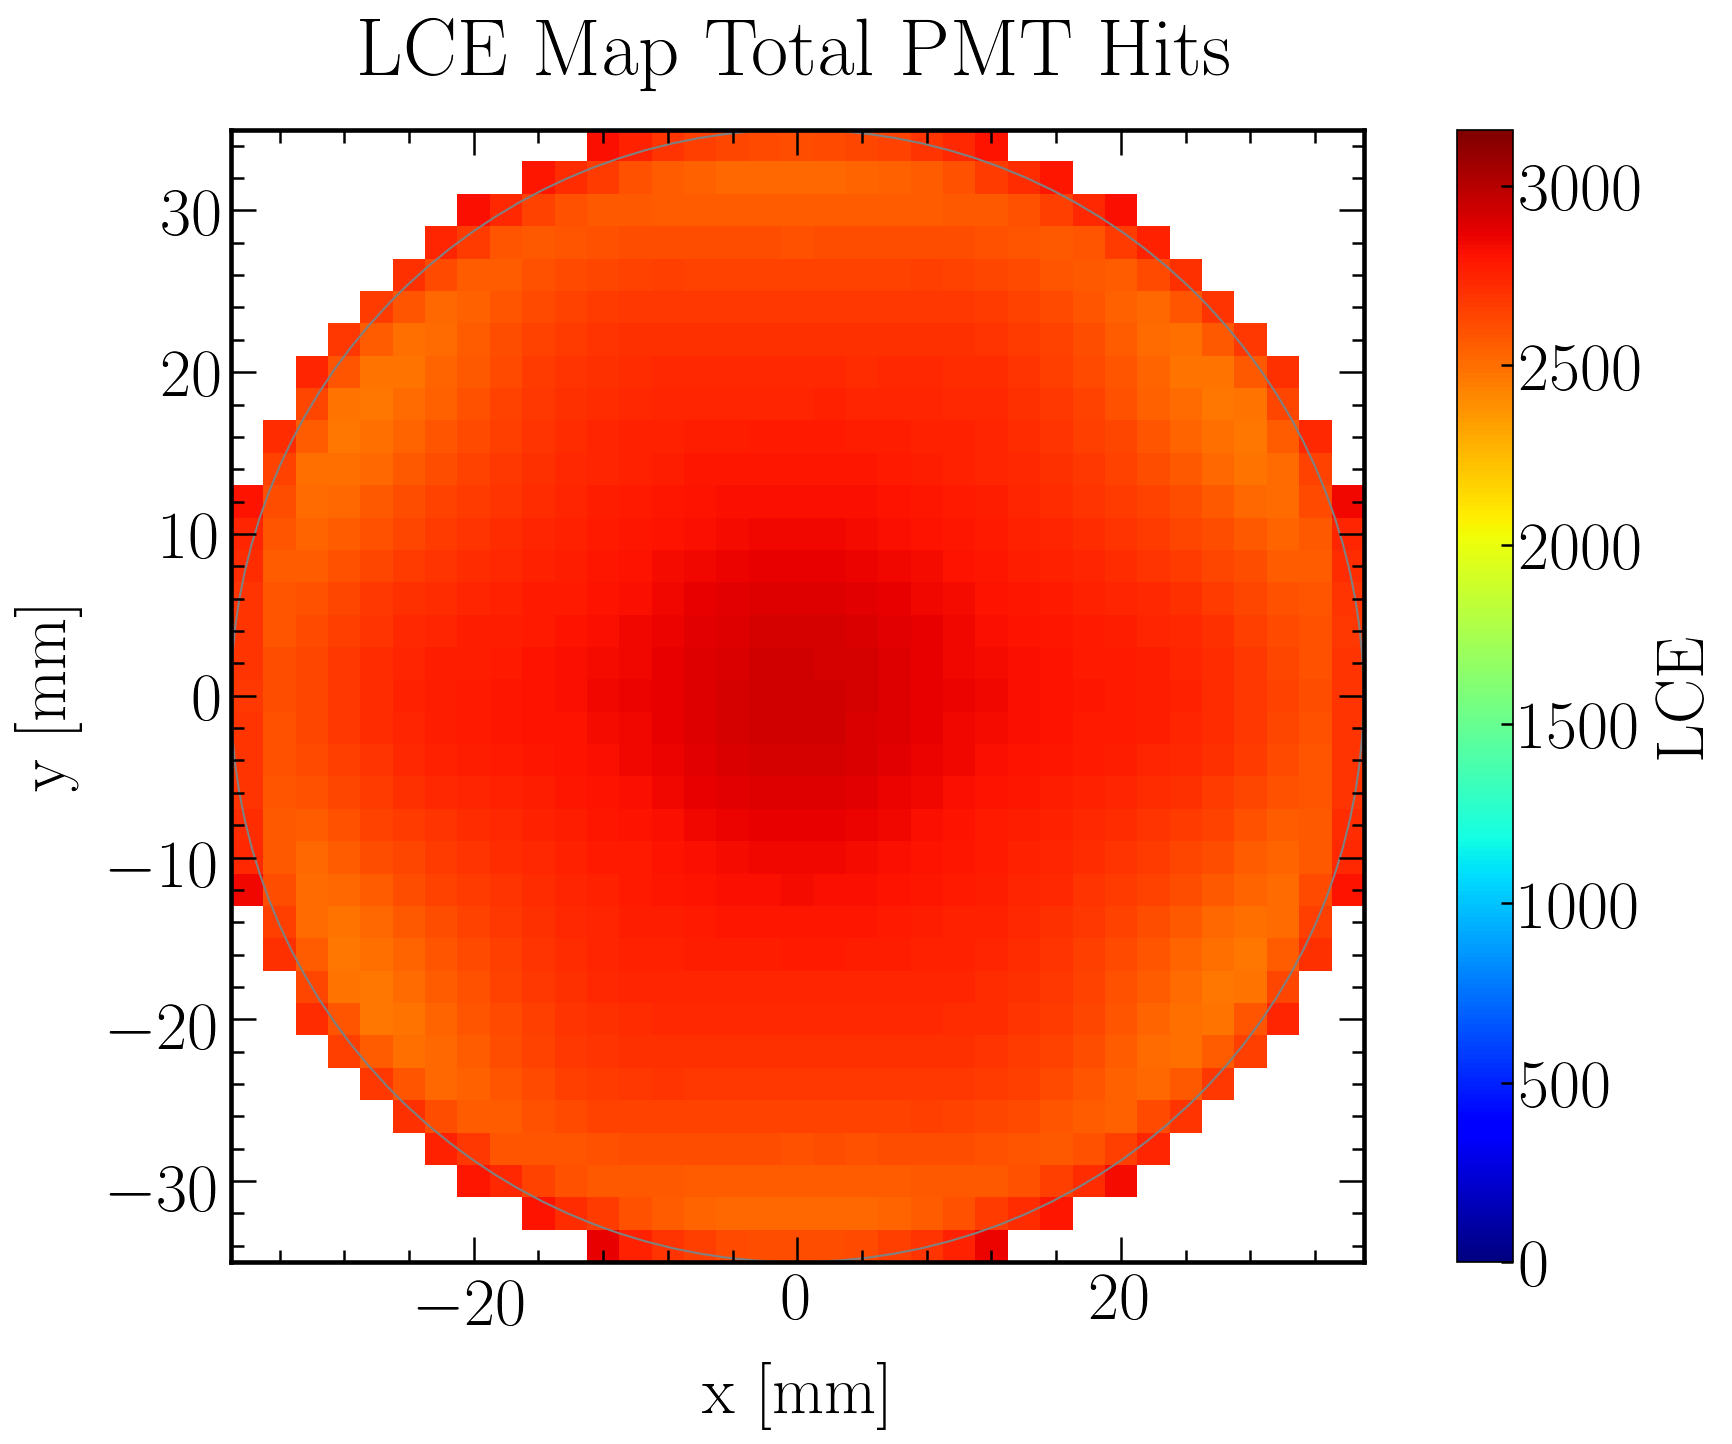

In [58]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwAll*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
#, vmin=0.2
plt.imshow(LCE_xy_hist['LCE.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')


plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['LCE.T'].loc['all']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Total.png")
plt.show()

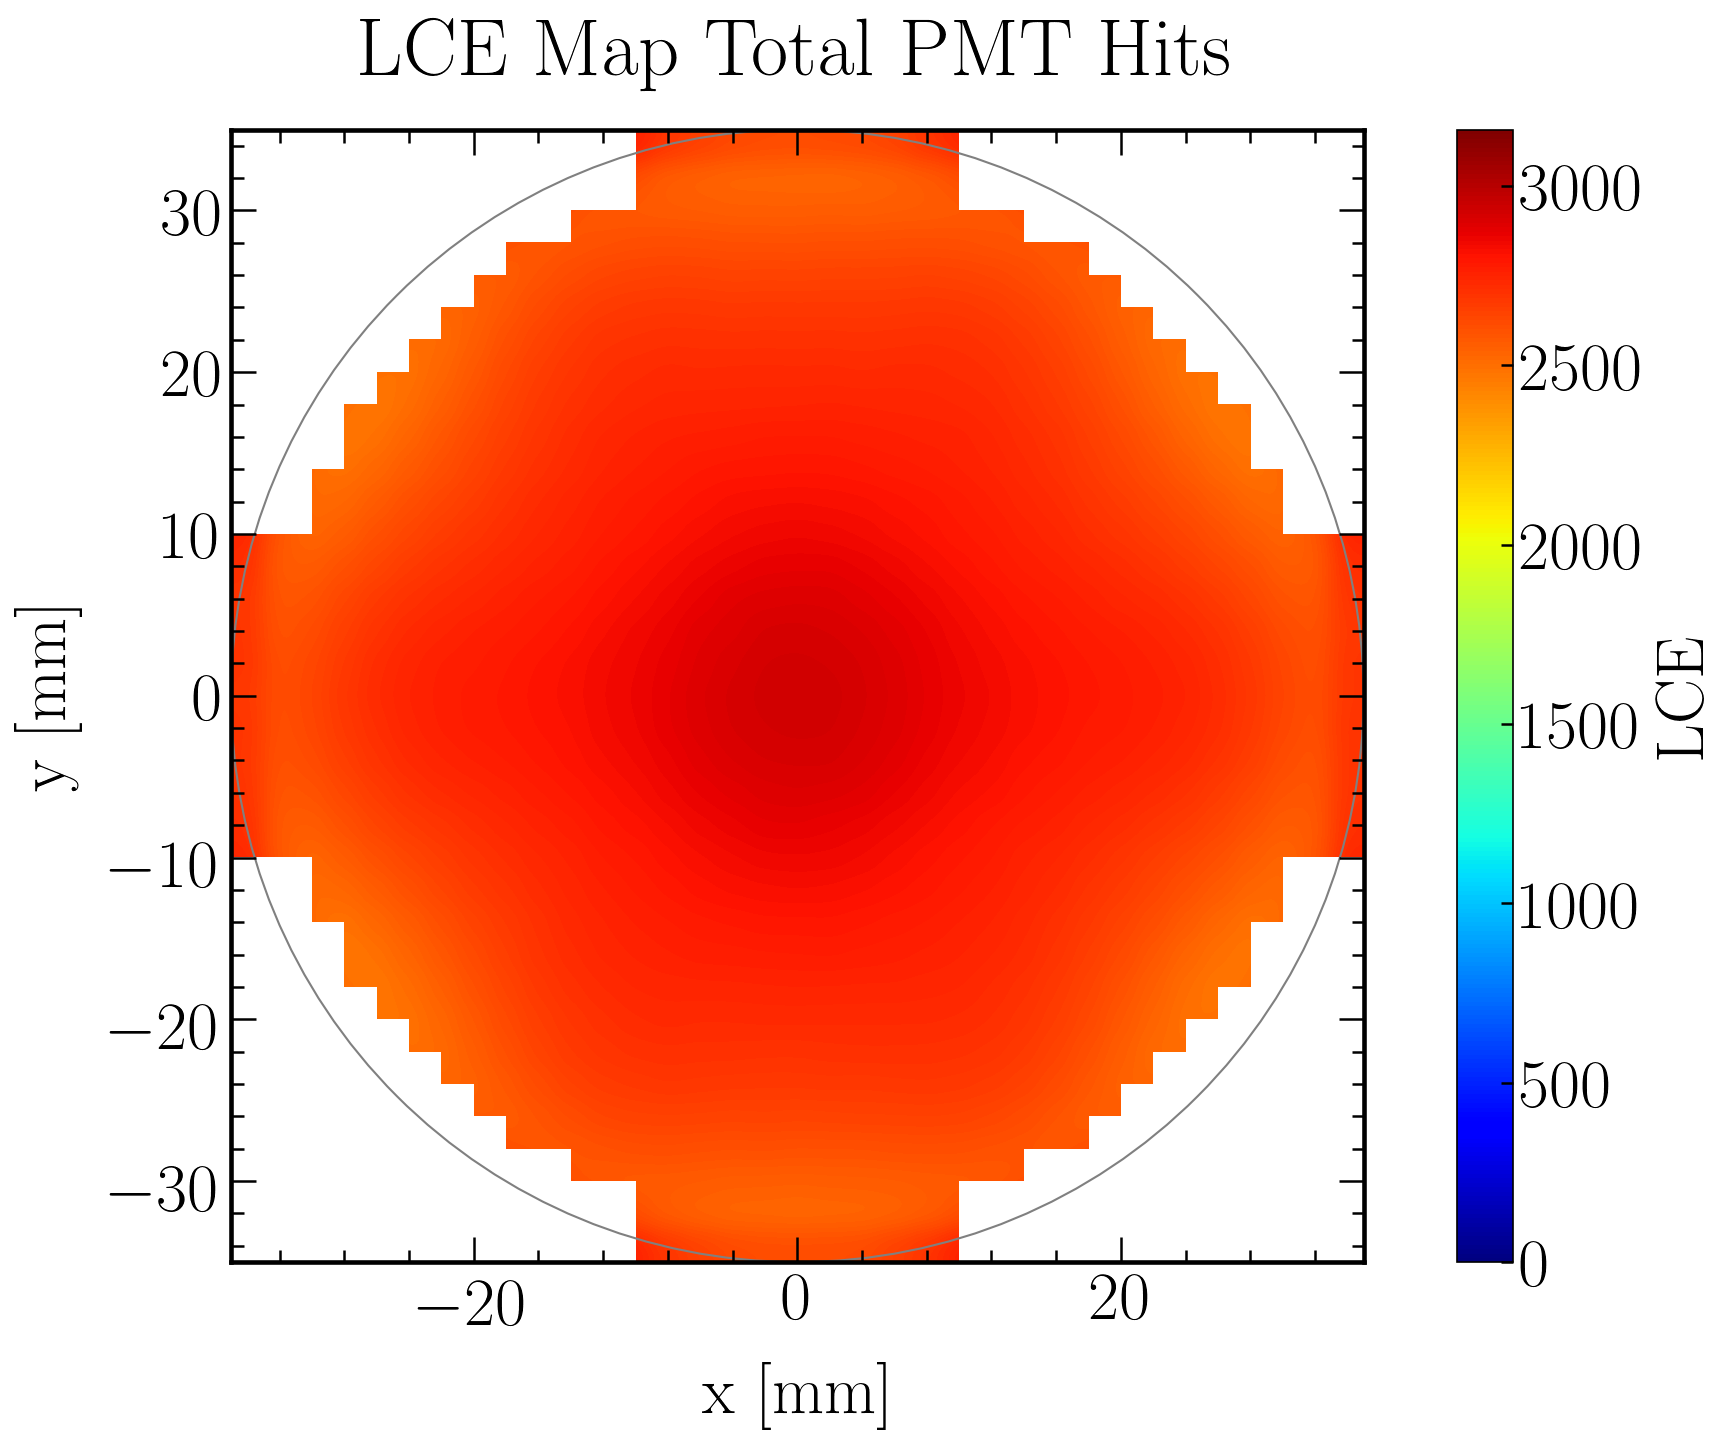

In [59]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwAll*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
#, vmin=0.2
plt.imshow(LCE_xy_hist['LCE.T'].loc['all'], interpolation='gaussian', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')


plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

val = LCE_xy_hist['LCE.T'].loc['all']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

fig.savefig(filenameprefix+"_LCE_x_y_Total_smooth.png")
plt.show()

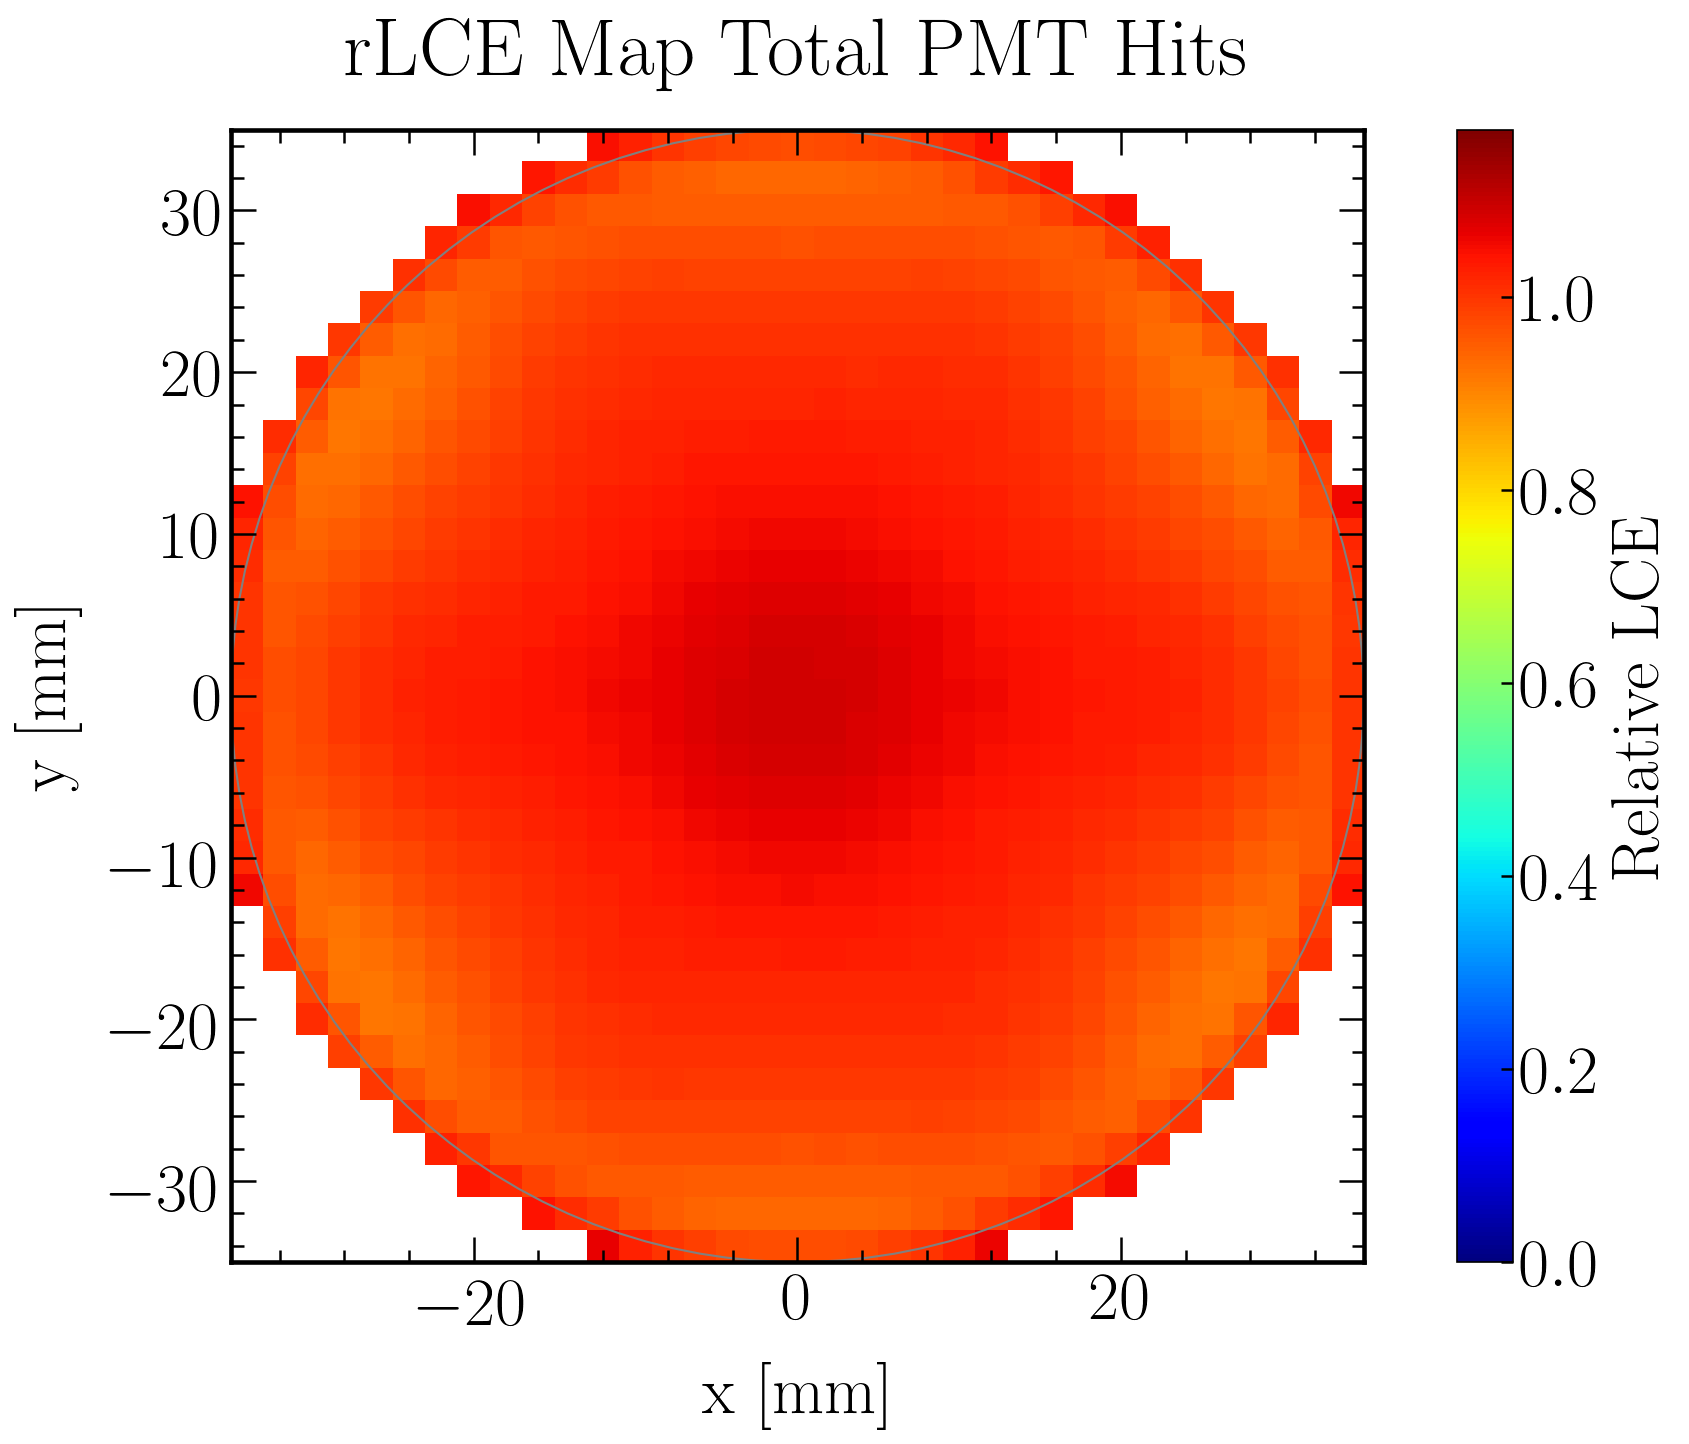

In [60]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwAll*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
#, vmin=0.2
plt.imshow(LCE_xy_hist['rLCE.T'].loc['all'], interpolation='nearest', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')


plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

'''val = LCE_xy_hist['rLCE.T'].loc['all']
val = val[~np.isnan(val)]
plt.clim(np.percentile(val, 5), np.percentile(val, 95))'''

val = LCE_xy_hist['rLCE.T'].loc['all']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Total_rel.png")
plt.show()

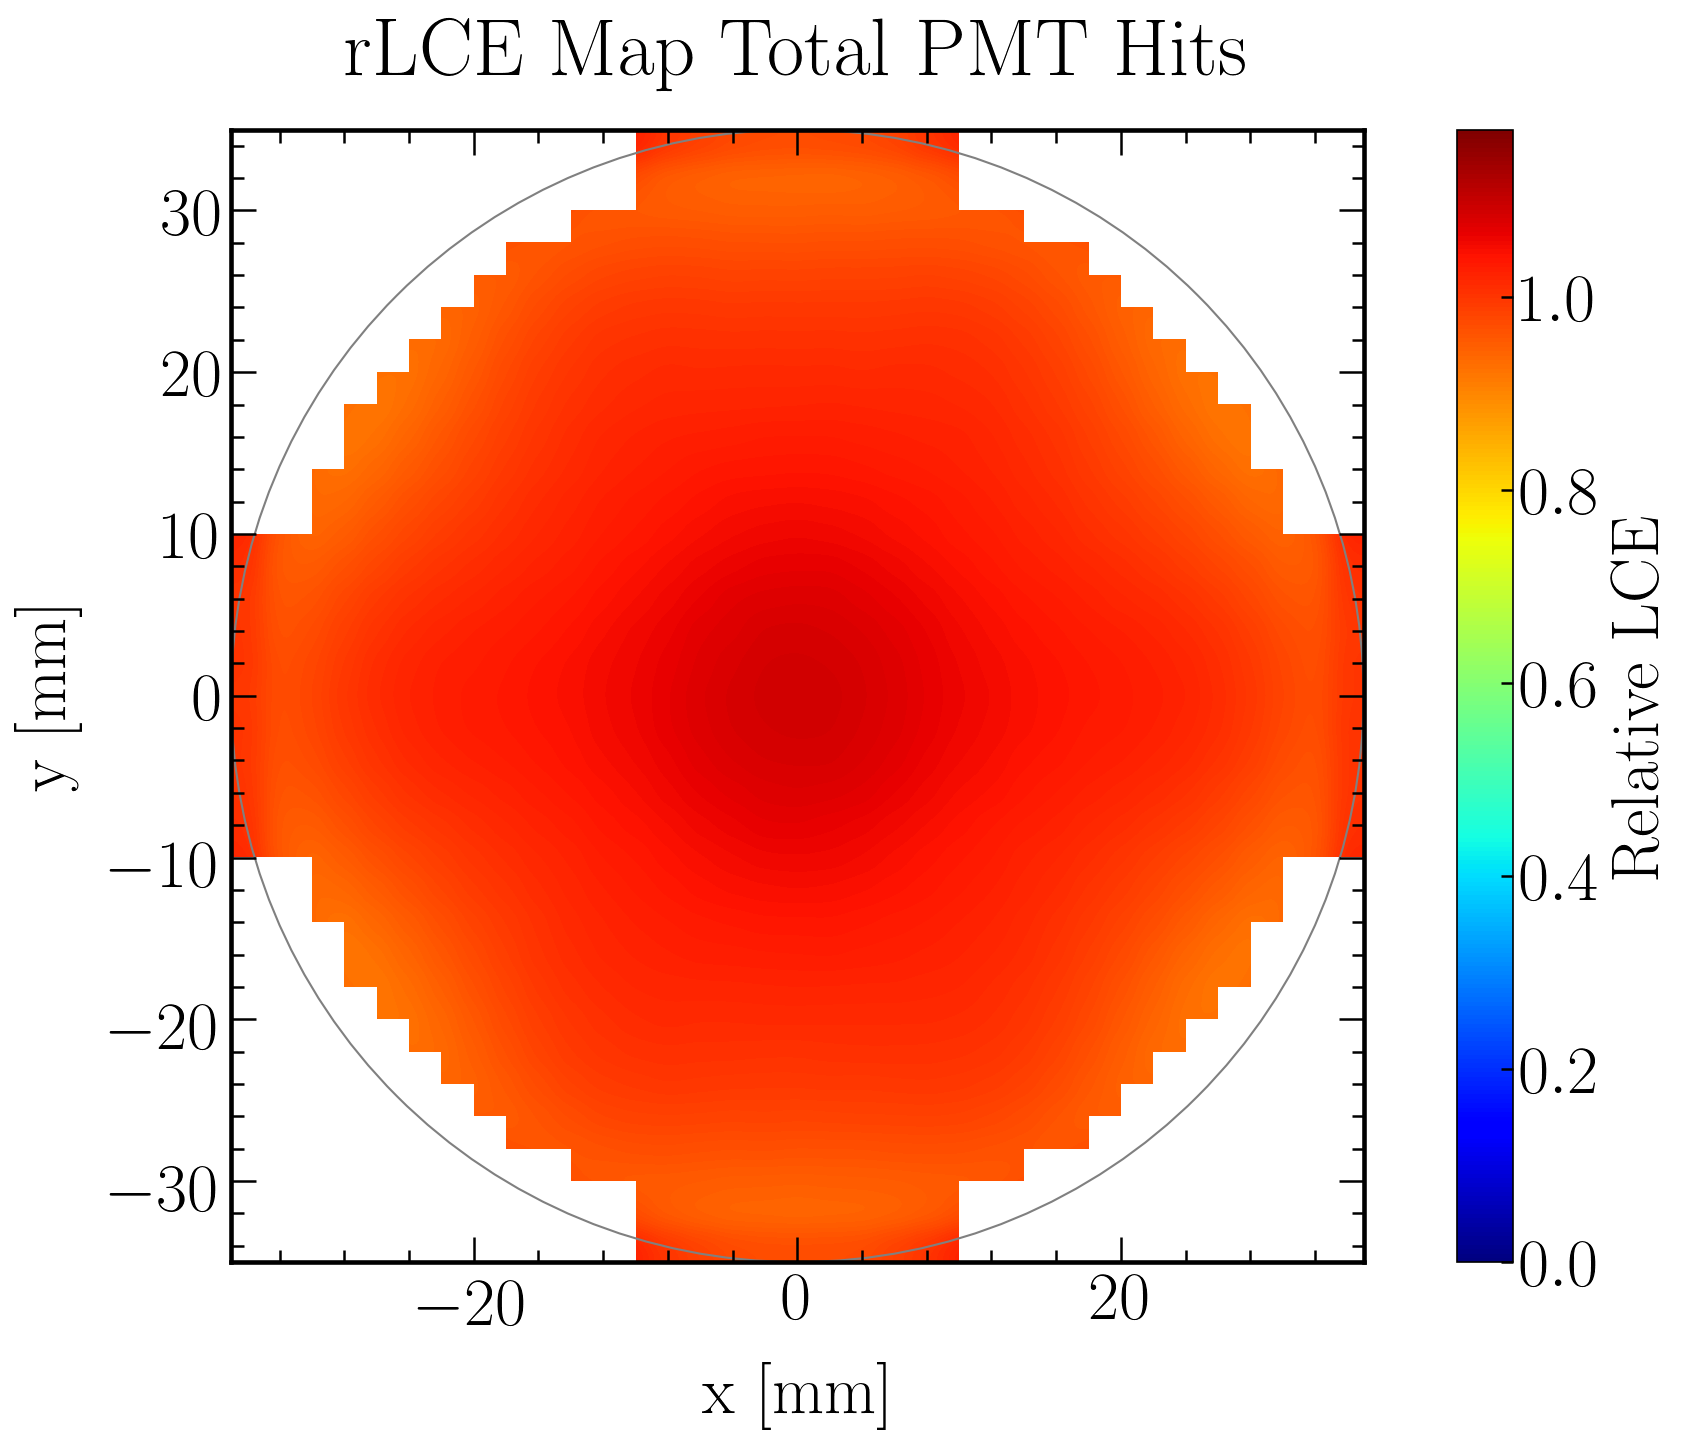

In [61]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
#plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwAll*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
#, vmin=0.2
plt.imshow(LCE_xy_hist['rLCE.T'].loc['all'], interpolation='gaussian', origin='low', extent=[range_x[0], range_x[1], range_y[0], range_y[1]], cmap = 'jet')


plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

'''val = LCE_xy_hist['rLCE.T'].loc['all']
val = val[~np.isnan(val)]
plt.clim(np.percentile(val, 5), np.percentile(val, 95))'''

val = LCE_xy_hist['rLCE.T'].loc['all']
val = val[~np.isnan(val)]
val = 1.1*np.percentile(val, 95)
plt.clim(0, val)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Total_rel_smooth.png")
plt.show()

### Hits fraction per PMT

In [62]:
if b_preprocessed == False:
    hitfractions = [0]*8
    for i in range(0,8):
        hitfractions[i] = sum(nth_tuple_subentries(_chunk_collect.pmthits, i))/napmthits_sum
    #print(hitfractions)
    print(sum(hitfractions))

1.0


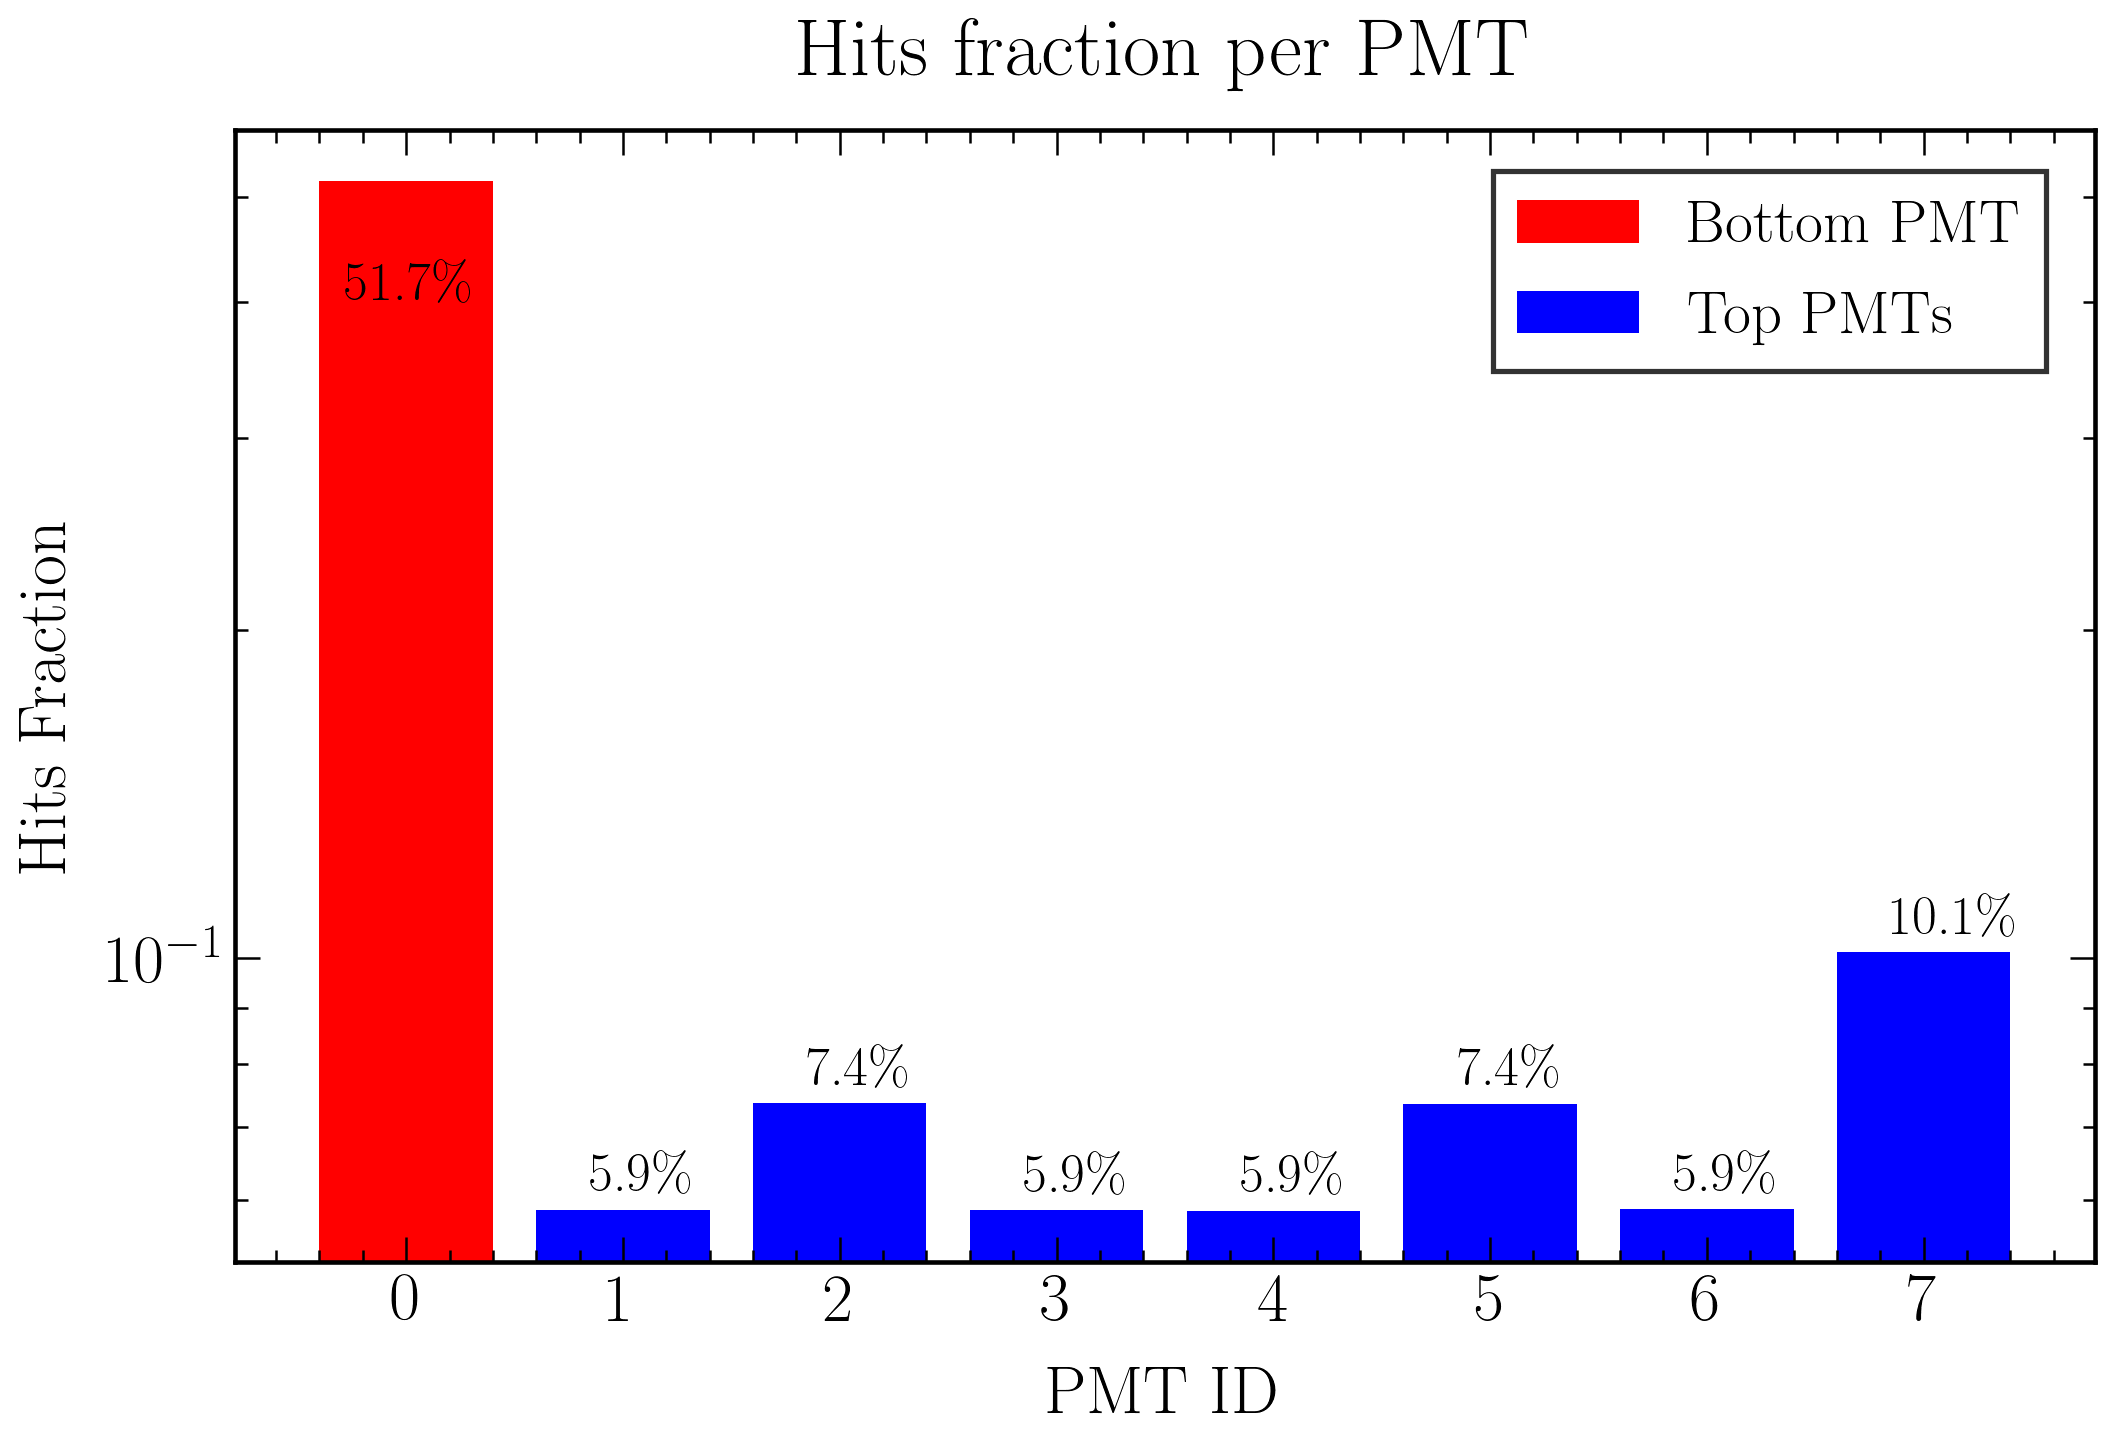

In [63]:
if b_preprocessed == False:
    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    plt.bar(0, hitfractions[0], color = 'red', label = 'Bottom PMT')
    plt.bar(range(1,8), hitfractions[1:], color = 'blue', label = 'Top PMTs')

    plt.xlabel('PMT ID', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
    plt.title('Hits fraction per PMT', fontsize = title_size, pad = title_pad)

    # Legend
    leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    # Axes ---> Range
    #plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
    #plt.ylim(0,0.45)
    #plt.xlim(left=0)
    plt.yscale('log', nonposy='clip')

    # Label bars with values
    barlabel = [str(round(100*hitfractions[0],1))+'$\%$', str(round(100*hitfractions[1],1))+'$\%$', str(round(100*hitfractions[2],1))+'$\%$', str(round(100*hitfractions[3],1))+'$\%$', str(round(100*hitfractions[4],1))+'$\%$', str(round(100*hitfractions[5],1))+'$\%$', str(round(100*hitfractions[6],1))+'$\%$', str(round(100*hitfractions[7],1))+'$\%$']
    plt.text(x = -0.28 , y = (hitfractions[0])*math.log(6,10), s = barlabel[0], size = 0.8*label_size)
    for i in range(1,8):
        plt.text(x = i -0.15 , y = (hitfractions[i])*math.log(11,10), s = barlabel[i], size = 0.8*label_size)

    fig.savefig(filenameprefix+"_Hits_Fraction_PMTs.png")
    plt.show()

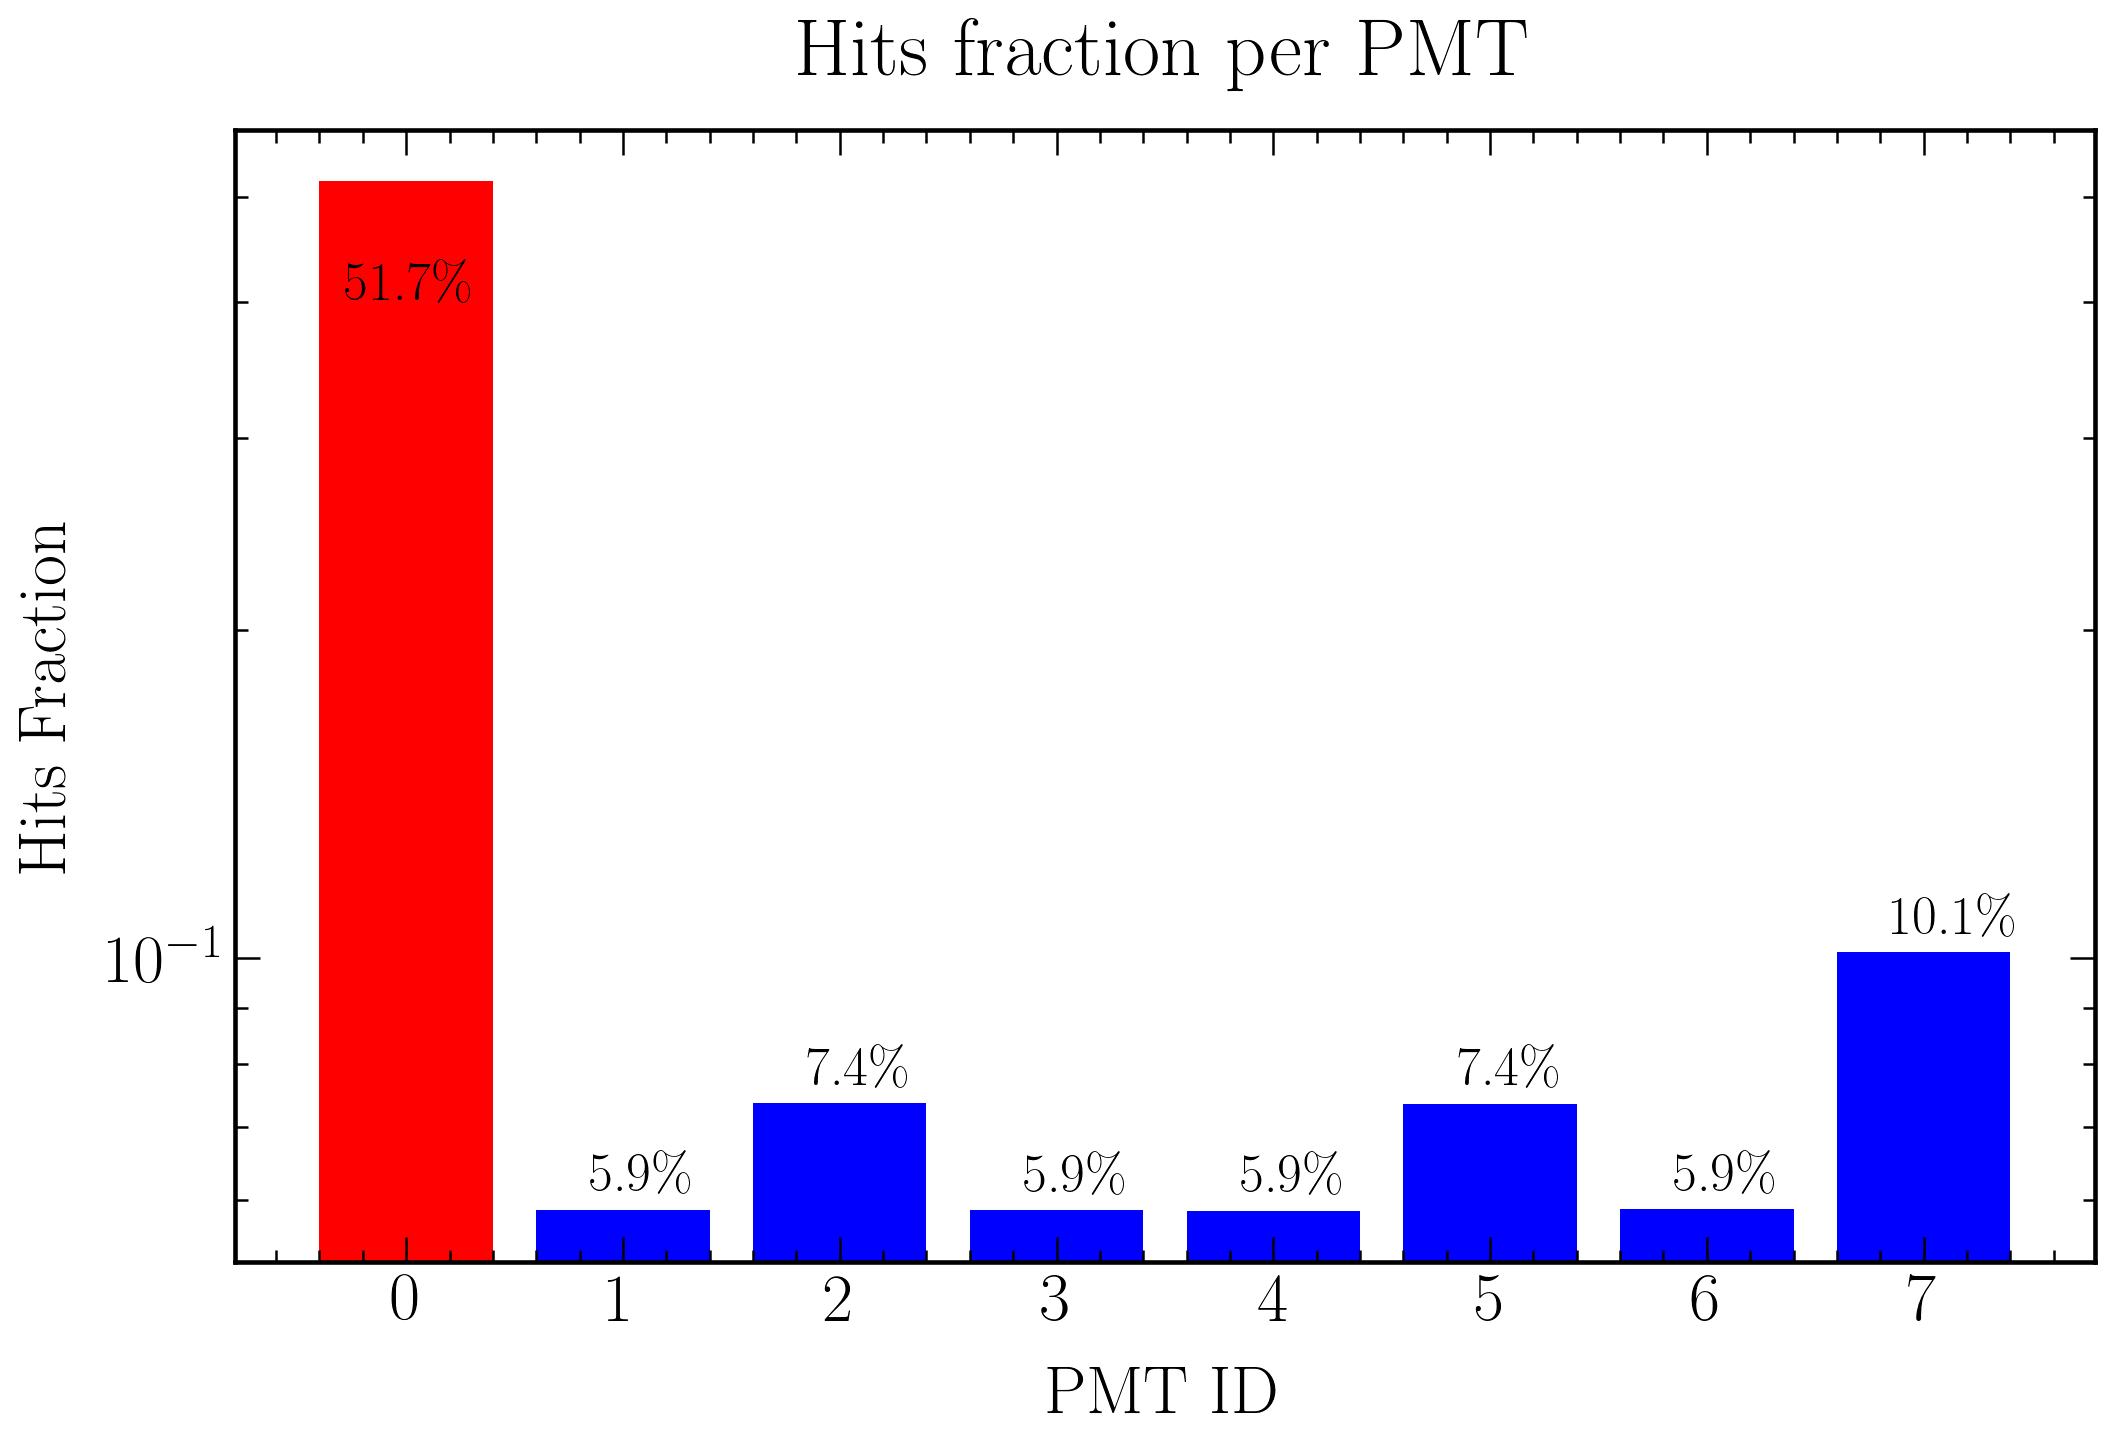

In [64]:
if b_preprocessed == False:
    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    plt.bar(0, hitfractions[0], color = 'red', label = 'Bottom PMT')
    plt.bar(range(1,8), hitfractions[1:], color = 'blue', label = 'Top PMTs')

    plt.xlabel('PMT ID', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
    plt.title('Hits fraction per PMT', fontsize = title_size, pad = title_pad)

    # Axes ---> Range
    #plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
    #plt.ylim(0,0.45)
    #plt.xlim(left=0)
    plt.yscale('log', nonposy='clip')

    # Label bars with values
    barlabel = [str(round(100*hitfractions[0],1))+'$\%$', str(round(100*hitfractions[1],1))+'$\%$', str(round(100*hitfractions[2],1))+'$\%$', str(round(100*hitfractions[3],1))+'$\%$', str(round(100*hitfractions[4],1))+'$\%$', str(round(100*hitfractions[5],1))+'$\%$', str(round(100*hitfractions[6],1))+'$\%$', str(round(100*hitfractions[7],1))+'$\%$']
    plt.text(x = -0.28 , y = (hitfractions[0])*math.log(6,10), s = barlabel[0], size = 0.8*label_size)
    for i in range(1,8):
        plt.text(x = i -0.15 , y = (hitfractions[i])*math.log(11,10), s = barlabel[i], size = 0.8*label_size)

    fig.savefig(filenameprefix+"_Hits_Fraction_PMTs_nolabel.png")
    plt.show()